# KAN for Chemistry: Interpretable Yield Prediction

This notebook demonstrates using Kolmogorov-Arnold Networks (KANs) for predicting reaction yields in the famous **Buchwald-Hartwig C-N cross-coupling** dataset from [Ahneman et al. (Science, 2018)](https://www.science.org/doi/10.1126/science.aar5169).

## Why KANs for Chemistry?

In chemistry, we often use **Multivariate Linear Regression (MLR)** because:
1. Interpretability matters - we want to understand *why* a reaction works
2. Datasets are often small (50-500 reactions)
3. Physical meaning of parameters is important

**KANs offer advantages over both MLR and black-box ML:**
- Like MLR: Interpretable (can see what each input contributes)
- Unlike MLR: Can capture nonlinear relationships
- Unlike neural networks: Shows explicit activation functions on edges
- The learned univariate functions may reveal physical relationships!

## The Dataset

The Buchwald-Hartwig dataset explores Pd-catalyzed C-N cross-coupling:
- **4 Ligands**: Different phosphine ligands
- **22 Additives**: Heterocyclic additives (potential catalyst poisons)
- **3 Bases**: Different organic bases
- **15 Aryl halides**: Different substrates
- **Yield**: 0-100% (target variable)

**References:**
- Ahneman et al. "Predicting reaction performance in C–N cross-coupling using machine learning" *Science* 2018
- [SigmanGroup](https://github.com/SigmanGroup) - Multivariate Linear Regression for catalysis
- [Paton Lab](https://patonlab.com/) - Data-driven chemistry tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# RDKit for molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

# KAN from pycse
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
from pycse.sklearn.kan import KAN

import warnings
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# PUBLICATION-QUALITY STYLING: Clean Academic Design
# =============================================================================
# Design inspired by modern scientific communication: minimal, content-focused,
# with restrained color palette and clear typography hierarchy.

# Set global matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------------------------------------------------------
# COLOR PALETTE: Restrained, professional, academic
# -----------------------------------------------------------------------------

# Primary palette - muted, professional colors
COLORS = {
    'primary': '#2563eb',      # Blue - main accent
    'secondary': '#6b7280',    # Gray - secondary elements
    'success': '#059669',      # Teal-green - positive/high values
    'warning': '#d97706',      # Amber - caution/medium values
    'danger': '#dc2626',       # Red - negative/low values
    'dark': '#1f2937',         # Near-black - text
    'light': '#f9fafb',        # Off-white - backgrounds
    'muted': '#9ca3af',        # Light gray - subtle elements
}

# Component colors for Buchwald-Hartwig (muted, distinguishable)
COMPONENT_COLORS = {
    'Aryl Halide': '#dc2626',   # Red (muted)
    'Ligand': '#2563eb',        # Blue
    'Base': '#059669',          # Teal-green
    'Additive': '#7c3aed',      # Purple
}

# Descriptor type colors for Sigman
DESCRIPTOR_COLORS = {
    'Steric': '#dc2626',        # Red
    'Electronic': '#2563eb',    # Blue
    'Geometric': '#059669',     # Green
    'Size': '#7c3aed',          # Purple
}

# Reaction partner colors
PARTNER_COLORS = {
    'Electrophile': '#d97706',  # Amber
    'Nucleophile': '#7c3aed',   # Purple
}

# Model comparison colors
MODEL_COLORS = {
    'MLR': '#059669',           # Green - simple
    'Logistic Regression': '#059669',
    'Random Forest': '#dc2626', # Red - black box
    'KAN': '#2563eb',           # Blue - interpretable
}

# Shape classification - semantic coloring
SHAPE_COLORS = {
    'Linear': '#6b7280',        # Gray - baseline/simple
    'Sigmoidal': '#dc2626',     # Red - threshold
    'U-shaped': '#059669',      # Green - optimal range
    'Threshold': '#d97706',     # Amber - cutoff
    'Saturating': '#2563eb',    # Blue - diminishing
    'Complex': '#7c3aed',       # Purple - multi-pathway
}

# Mechanism step colors
MECHANISM_COLORS = {
    'Steric Gating': '#dc2626',
    'Charge Transfer': '#2563eb',
    'Frontier Orbital Interaction': '#059669',
    'Approach Trajectory': '#7c3aed',
    'Transition State Geometry': '#d97706',
    'Electronic Environment': '#6b7280',
    'Transition State Stabilization': '#0891b2',
    'Nucleophile Geometry': '#9ca3af',
}

# -----------------------------------------------------------------------------
# TYPOGRAPHY SETTINGS
# -----------------------------------------------------------------------------

FIGURE_DPI = 150
TITLE_FONTSIZE = 13
LABEL_FONTSIZE = 11
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 9
ANNOTATION_FONTSIZE = 10

# Font families
FONT_MAIN = 'DejaVu Sans'
FONT_MONO = 'DejaVu Sans Mono'

# Update matplotlib rcParams
plt.rcParams.update({
    'figure.dpi': FIGURE_DPI,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.titlesize': TITLE_FONTSIZE,
    'axes.labelsize': LABEL_FONTSIZE,
    'axes.titleweight': 'bold',
    'axes.edgecolor': '#e5e7eb',
    'axes.linewidth': 0.8,
    'xtick.labelsize': TICK_FONTSIZE,
    'ytick.labelsize': TICK_FONTSIZE,
    'legend.fontsize': LEGEND_FONTSIZE,
    'legend.framealpha': 0.95,
    'legend.edgecolor': '#e5e7eb',
    'grid.color': '#f3f4f6',
    'grid.linewidth': 0.5,
    'savefig.facecolor': 'white',
    'savefig.bbox': 'tight',
})

# -----------------------------------------------------------------------------
# HELPER FUNCTIONS
# -----------------------------------------------------------------------------

def create_card_style_box(ax, x, y, width, height, title, content, 
                          border_color=COLORS['muted'], bg_color='white',
                          title_color=COLORS['dark']):
    """Create a card-style box with title and content."""
    from matplotlib.patches import FancyBboxPatch
    
    # Card background
    card = FancyBboxPatch((x, y), width, height,
                          boxstyle="round,pad=0.02,rounding_size=0.02",
                          facecolor=bg_color, edgecolor=border_color,
                          linewidth=1.5, transform=ax.transAxes)
    ax.add_patch(card)
    
    # Title bar (subtle)
    title_bar = FancyBboxPatch((x, y + height - 0.15), width, 0.15,
                               boxstyle="round,pad=0.01,rounding_size=0.02",
                               facecolor=border_color, edgecolor='none',
                               alpha=0.15, transform=ax.transAxes)
    ax.add_patch(title_bar)
    
    # Title text
    ax.text(x + width/2, y + height - 0.075, title,
            transform=ax.transAxes, fontsize=ANNOTATION_FONTSIZE,
            fontweight='bold', ha='center', va='center', color=title_color)
    
    # Content text
    ax.text(x + width/2, y + (height - 0.15)/2, content,
            transform=ax.transAxes, fontsize=TICK_FONTSIZE,
            ha='center', va='center', linespacing=1.4,
            family=FONT_MONO if content.replace('.','').replace('-','').replace(' ','').replace('\n','').isalnum() else FONT_MAIN)

def format_value(val, precision=3):
    """Format numerical value with monospace styling hint."""
    if isinstance(val, (int, float)):
        return f"{val:.{precision}f}"
    return str(val)

print("[OK] Styling constants loaded - clean academic design")


[OK] Styling constants loaded - clean academic design


## 1. Load and Explore the Data

In [3]:
# Load the Buchwald-Hartwig dataset
# Download from: https://github.com/rxn4chemistry/rxn_yields

# For this demo, we'll download directly
import urllib.request
import os

data_url = "https://raw.githubusercontent.com/rxn4chemistry/rxn_yields/master/data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx"
data_path = "/tmp/buchwald_hartwig.xlsx"

if not os.path.exists(data_path):
    print("Downloading Buchwald-Hartwig dataset...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Done!")

# Load the data
df = pd.read_excel(data_path, sheet_name='Plates1-3')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nYield statistics:")
print(df['Output'].describe())

Dataset shape: (3955, 5)

Columns: ['Ligand', 'Additive', 'Base', 'Aryl halide', 'Output']

Yield statistics:
count    3955.000000
mean       33.085259
std        27.291205
min         0.000000
25%         7.877560
50%        28.761729
75%        53.278687
max        99.999990
Name: Output, dtype: float64


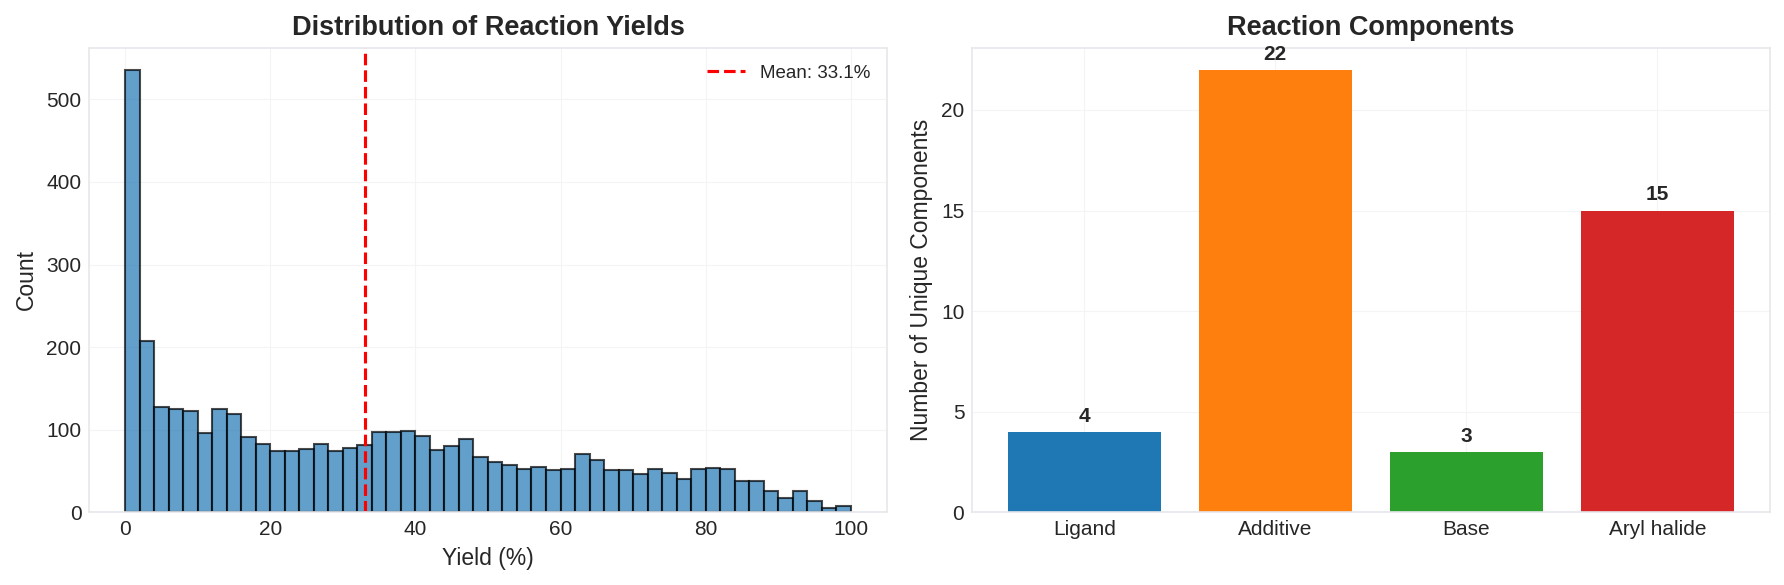

In [4]:
# Visualize the yield distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['Output'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Yield (%)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Reaction Yields')
axes[0].axvline(df['Output'].mean(), color='red', linestyle='--', label=f'Mean: {df["Output"].mean():.1f}%')
axes[0].legend()

# Component counts
components = ['Ligand', 'Additive', 'Base', 'Aryl halide']
counts = [df[c].nunique() for c in components]
axes[1].bar(components, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_ylabel('Number of Unique Components')
axes[1].set_title('Reaction Components')
for i, v in enumerate(counts):
    axes[1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Compute Molecular Descriptors

We use **RDKit** to compute molecular descriptors from SMILES strings.

For each reaction component (ligand, additive, base, aryl halide), we calculate:
- **MolWt**: Molecular weight
- **MolLogP**: Lipophilicity (octanol-water partition coefficient)
- **TPSA**: Topological polar surface area
- **NumRotatableBonds**: Flexibility measure
- **NumHAcceptors/Donors**: H-bonding capacity
- **NumAromaticRings**: Aromaticity
- **FractionCSP3**: Fraction sp3 carbons (3D character)

In [5]:
def get_mol_descriptors(smiles, prefix=''):
    """Calculate RDKit 2D descriptors for a molecule."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Selected descriptors relevant for reactivity
    desc_funcs = {
        'MolWt': Descriptors.MolWt,
        'MolLogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'NumRotatableBonds': Descriptors.NumRotatableBonds,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'NumHDonors': Descriptors.NumHDonors,
        'NumAromaticRings': Descriptors.NumAromaticRings,
        'FractionCSP3': Descriptors.FractionCSP3,
    }
    
    descriptors = {}
    for name, func in desc_funcs.items():
        try:
            descriptors[f"{prefix}{name}"] = func(mol)
        except:
            descriptors[f"{prefix}{name}"] = np.nan
    return descriptors

# Compute descriptors for each component
print("Computing molecular descriptors...")

# Create lookup tables for unique components
component_cols = ['Ligand', 'Additive', 'Base', 'Aryl halide']
prefixes = ['lig_', 'add_', 'base_', 'aryl_']

desc_lookup = {}
for col, prefix in zip(component_cols, prefixes):
    unique_smiles = df[col].unique()
    desc_lookup[col] = {}
    for smi in unique_smiles:
        desc = get_mol_descriptors(smi, prefix)
        if desc is not None:
            desc_lookup[col][smi] = desc
    print(f"  {col}: {len(desc_lookup[col])} molecules processed")

print("Done!")

Computing molecular descriptors...
  Ligand: 4 molecules processed
  Additive: 22 molecules processed
  Base: 3 molecules processed
  Aryl halide: 15 molecules processed
Done!


In [6]:
# Build the feature matrix
def build_feature_row(row):
    """Build feature vector for a reaction."""
    features = {}
    for col, prefix in zip(component_cols, prefixes):
        smi = row[col]
        if smi in desc_lookup[col]:
            features.update(desc_lookup[col][smi])
        else:
            # Handle missing
            for name in ['MolWt', 'MolLogP', 'TPSA', 'NumRotatableBonds', 
                        'NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'FractionCSP3']:
                features[f"{prefix}{name}"] = np.nan
    return features

# Apply to all rows
feature_dicts = df.apply(build_feature_row, axis=1).tolist()
X_df = pd.DataFrame(feature_dicts)
y = df['Output'].values

# Remove rows with NaN
valid_mask = ~X_df.isna().any(axis=1)
X_df = X_df[valid_mask]
y = y[valid_mask]

print(f"Feature matrix shape: {X_df.shape}")
print(f"Feature columns: {list(X_df.columns)}")
print(f"\nValid samples: {len(y)} / {len(df)}")

Feature matrix shape: (3955, 32)
Feature columns: ['lig_MolWt', 'lig_MolLogP', 'lig_TPSA', 'lig_NumRotatableBonds', 'lig_NumHAcceptors', 'lig_NumHDonors', 'lig_NumAromaticRings', 'lig_FractionCSP3', 'add_MolWt', 'add_MolLogP', 'add_TPSA', 'add_NumRotatableBonds', 'add_NumHAcceptors', 'add_NumHDonors', 'add_NumAromaticRings', 'add_FractionCSP3', 'base_MolWt', 'base_MolLogP', 'base_TPSA', 'base_NumRotatableBonds', 'base_NumHAcceptors', 'base_NumHDonors', 'base_NumAromaticRings', 'base_FractionCSP3', 'aryl_MolWt', 'aryl_MolLogP', 'aryl_TPSA', 'aryl_NumRotatableBonds', 'aryl_NumHAcceptors', 'aryl_NumHDonors', 'aryl_NumAromaticRings', 'aryl_FractionCSP3']

Valid samples: 3955 / 3955


## 3. Compare Models: MLR vs Random Forest vs KAN

We'll compare three approaches:
1. **Multivariate Linear Regression (MLR)** - Traditional approach in physical organic chemistry
2. **Random Forest** - What Ahneman et al. used (achieved R² ≈ 0.92 with DFT descriptors)
3. **KAN** - Our interpretable nonlinear model

In [7]:
# Prepare data
X = X_df.values
feature_names = list(X_df.columns)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set: 3164 samples
Test set: 791 samples
Number of features: 32


In [8]:
# Train and evaluate models
results = {}

# 1. Linear Regression (MLR)
print("Training Multivariate Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['MLR'] = {
    'model': lr,
    'r2': r2_score(y_test, y_pred_lr),
    'mae': mean_absolute_error(y_test, y_pred_lr),
    'y_pred': y_pred_lr
}
print(f"  R² = {results['MLR']['r2']:.4f}, MAE = {results['MLR']['mae']:.2f}%")

# 2. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'model': rf,
    'r2': r2_score(y_test, y_pred_rf),
    'mae': mean_absolute_error(y_test, y_pred_rf),
    'y_pred': y_pred_rf
}
print(f"  R² = {results['Random Forest']['r2']:.4f}, MAE = {results['Random Forest']['mae']:.2f}%")

# 3. KAN
print("\nTraining KAN...")
n_features = X_train.shape[1]
kan = KAN(
    layers=(n_features, 8, 1),  # Input -> 8 hidden -> 1 output
    grid_size=5,
    spline_order=3,
)
kan.fit(X_train, y_train, maxiter=300)
y_pred_kan = kan.predict(X_test)
results['KAN'] = {
    'model': kan,
    'r2': r2_score(y_test, y_pred_kan),
    'mae': mean_absolute_error(y_test, y_pred_kan),
    'y_pred': y_pred_kan
}
print(f"  R² = {results['KAN']['r2']:.4f}, MAE = {results['KAN']['mae']:.2f}%")

Training Multivariate Linear Regression...


  R² = 0.5469, MAE = 15.06%

Training Random Forest...


  R² = 0.5588, MAE = 12.74%

Training KAN...


  R² = 0.7048, MAE = 10.94%


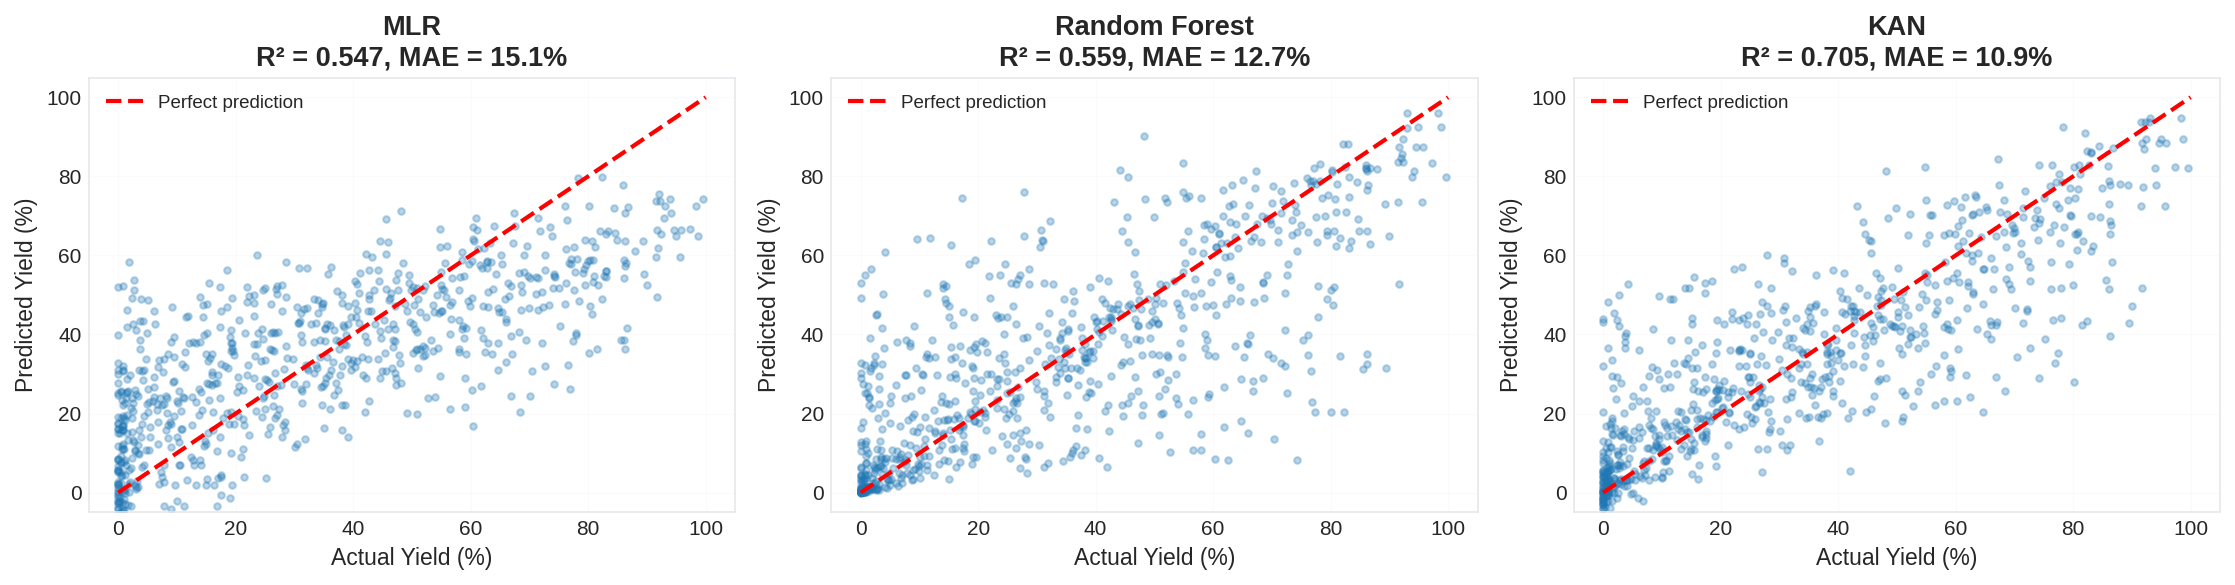

In [9]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, res) in zip(axes, results.items()):
    ax.scatter(y_test, res['y_pred'], alpha=0.3, s=10)
    ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect prediction')
    ax.set_xlabel('Actual Yield (%)')
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(f"{name}\nR² = {res['r2']:.3f}, MAE = {res['mae']:.1f}%")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Comparison Summary

Let's compare the models in terms of performance and interpretability.

In [10]:
# Summary table
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'R²':<10} {'MAE (%)':<10} {'Interpretable?'}")
print("-" * 60)

interpretability = {
    'MLR': 'Yes (linear coefs)',
    'Random Forest': 'Partial (feature importance)',
    'KAN': 'Yes (activation functions)'
}

for name, res in results.items():
    print(f"{name:<20} {res['r2']:<10.4f} {res['mae']:<10.2f} {interpretability[name]}")

print("=" * 60)

MODEL COMPARISON SUMMARY
Model                R²         MAE (%)    Interpretable?
------------------------------------------------------------
MLR                  0.5469     15.06      Yes (linear coefs)
Random Forest        0.5588     12.74      Partial (feature importance)
KAN                  0.7048     10.94      Yes (activation functions)


## 5. Interpretability: Understanding the Models

### 5.1 MLR: Linear Coefficients

In MLR, each coefficient tells us how much the yield changes per unit change in that descriptor.

Top 10 MLR Coefficients (most influential features):
               Feature  Coefficient
             aryl_TPSA   166.868069
    aryl_NumHAcceptors  -148.946843
aryl_NumRotatableBonds    56.234863
     aryl_FractionCSP3   -55.944364
          aryl_MolLogP    40.318921
           add_MolLogP    27.604850
 lig_NumRotatableBonds   -20.962281
             add_MolWt   -20.143786
     add_NumHAcceptors    16.996355
            aryl_MolWt    16.587114


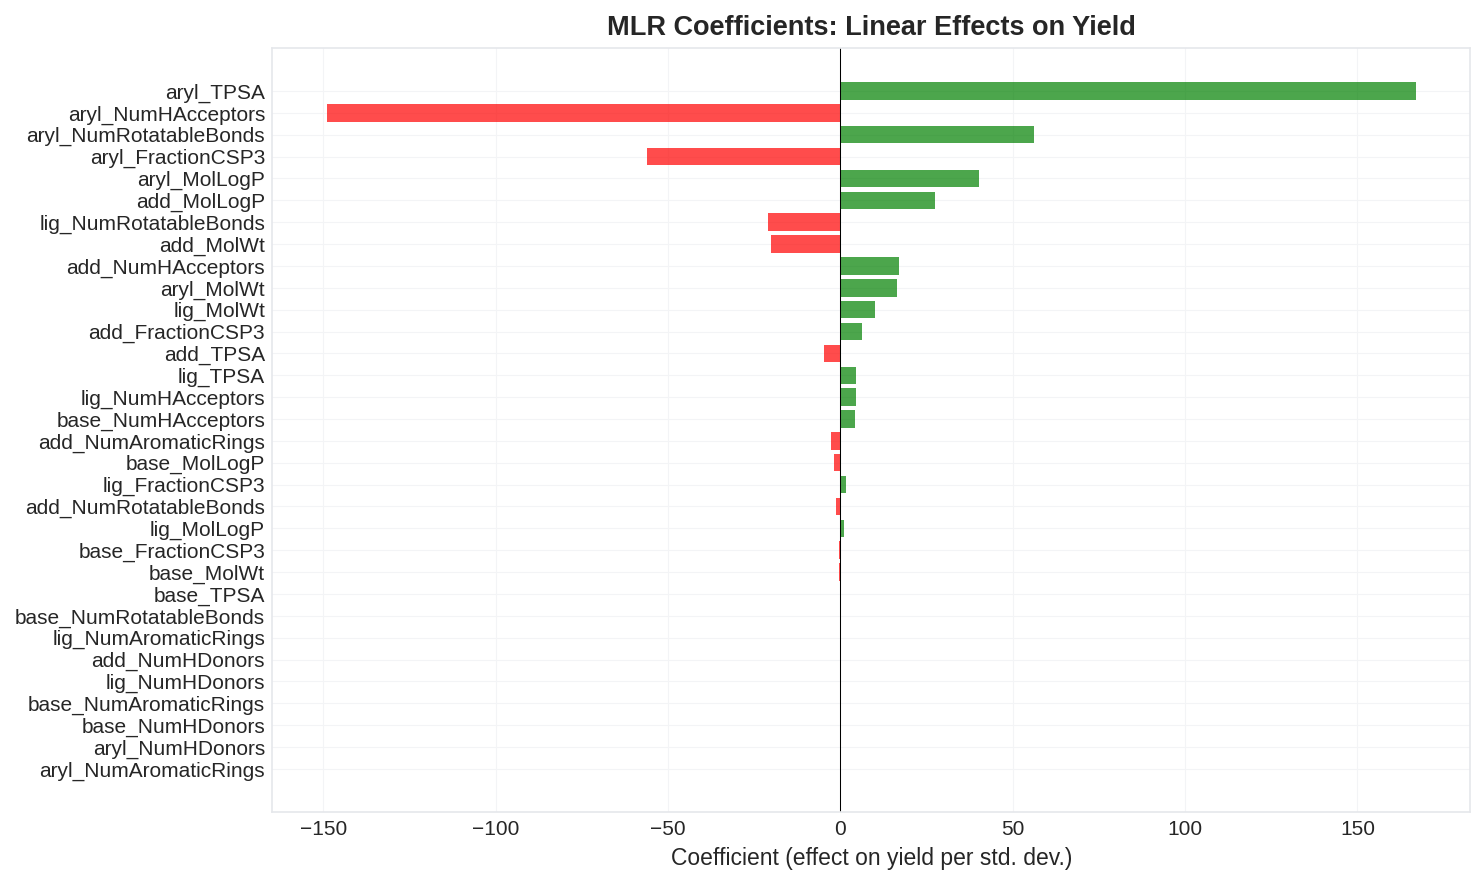

In [11]:
# MLR coefficients
lr_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top 10 MLR Coefficients (most influential features):")
print(lr_coefs.head(10).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in lr_coefs['Coefficient']]
ax.barh(range(len(lr_coefs)), lr_coefs['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(lr_coefs)))
ax.set_yticklabels(lr_coefs['Feature'])
ax.set_xlabel('Coefficient (effect on yield per std. dev.)')
ax.set_title('MLR Coefficients: Linear Effects on Yield')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 5.2 Random Forest: Feature Importance

Random Forest gives us feature importances, but no insight into *how* the feature affects the outcome.

Top 10 Random Forest Feature Importances:
           Feature  Importance
        aryl_MolWt    0.214111
      aryl_MolLogP    0.118170
       add_MolLogP    0.097696
 aryl_FractionCSP3    0.075419
  lig_FractionCSP3    0.059032
         aryl_TPSA    0.057158
         add_MolWt    0.049627
       lig_MolLogP    0.046677
  add_FractionCSP3    0.041074
base_NumHAcceptors    0.037642


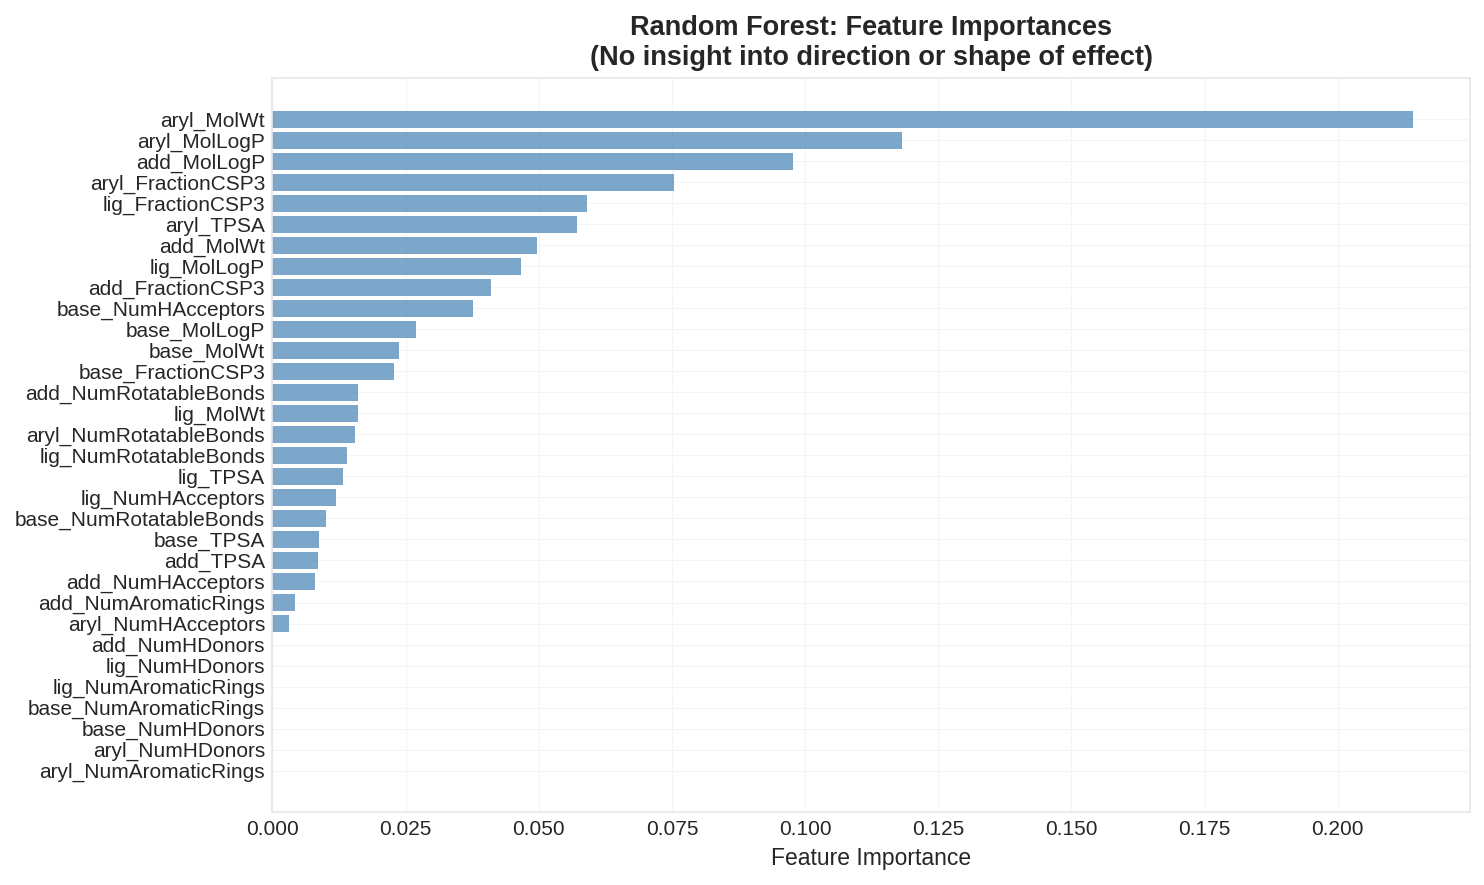

In [12]:
# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Random Forest Feature Importances:")
print(rf_importance.head(10).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(rf_importance)), rf_importance['Importance'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(rf_importance)))
ax.set_yticklabels(rf_importance['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest: Feature Importances\n(No insight into direction or shape of effect)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 5.3 KAN: Learned Activation Functions

**This is where KAN shines!** We can visualize the actual nonlinear transformations learned for each input.

Unlike MLR (linear only) or Random Forest (black box), KAN shows us:
- The **shape** of each input's effect
- Whether the relationship is linear, quadratic, threshold-like, etc.
- Potential **physical interpretations** of the learned functions

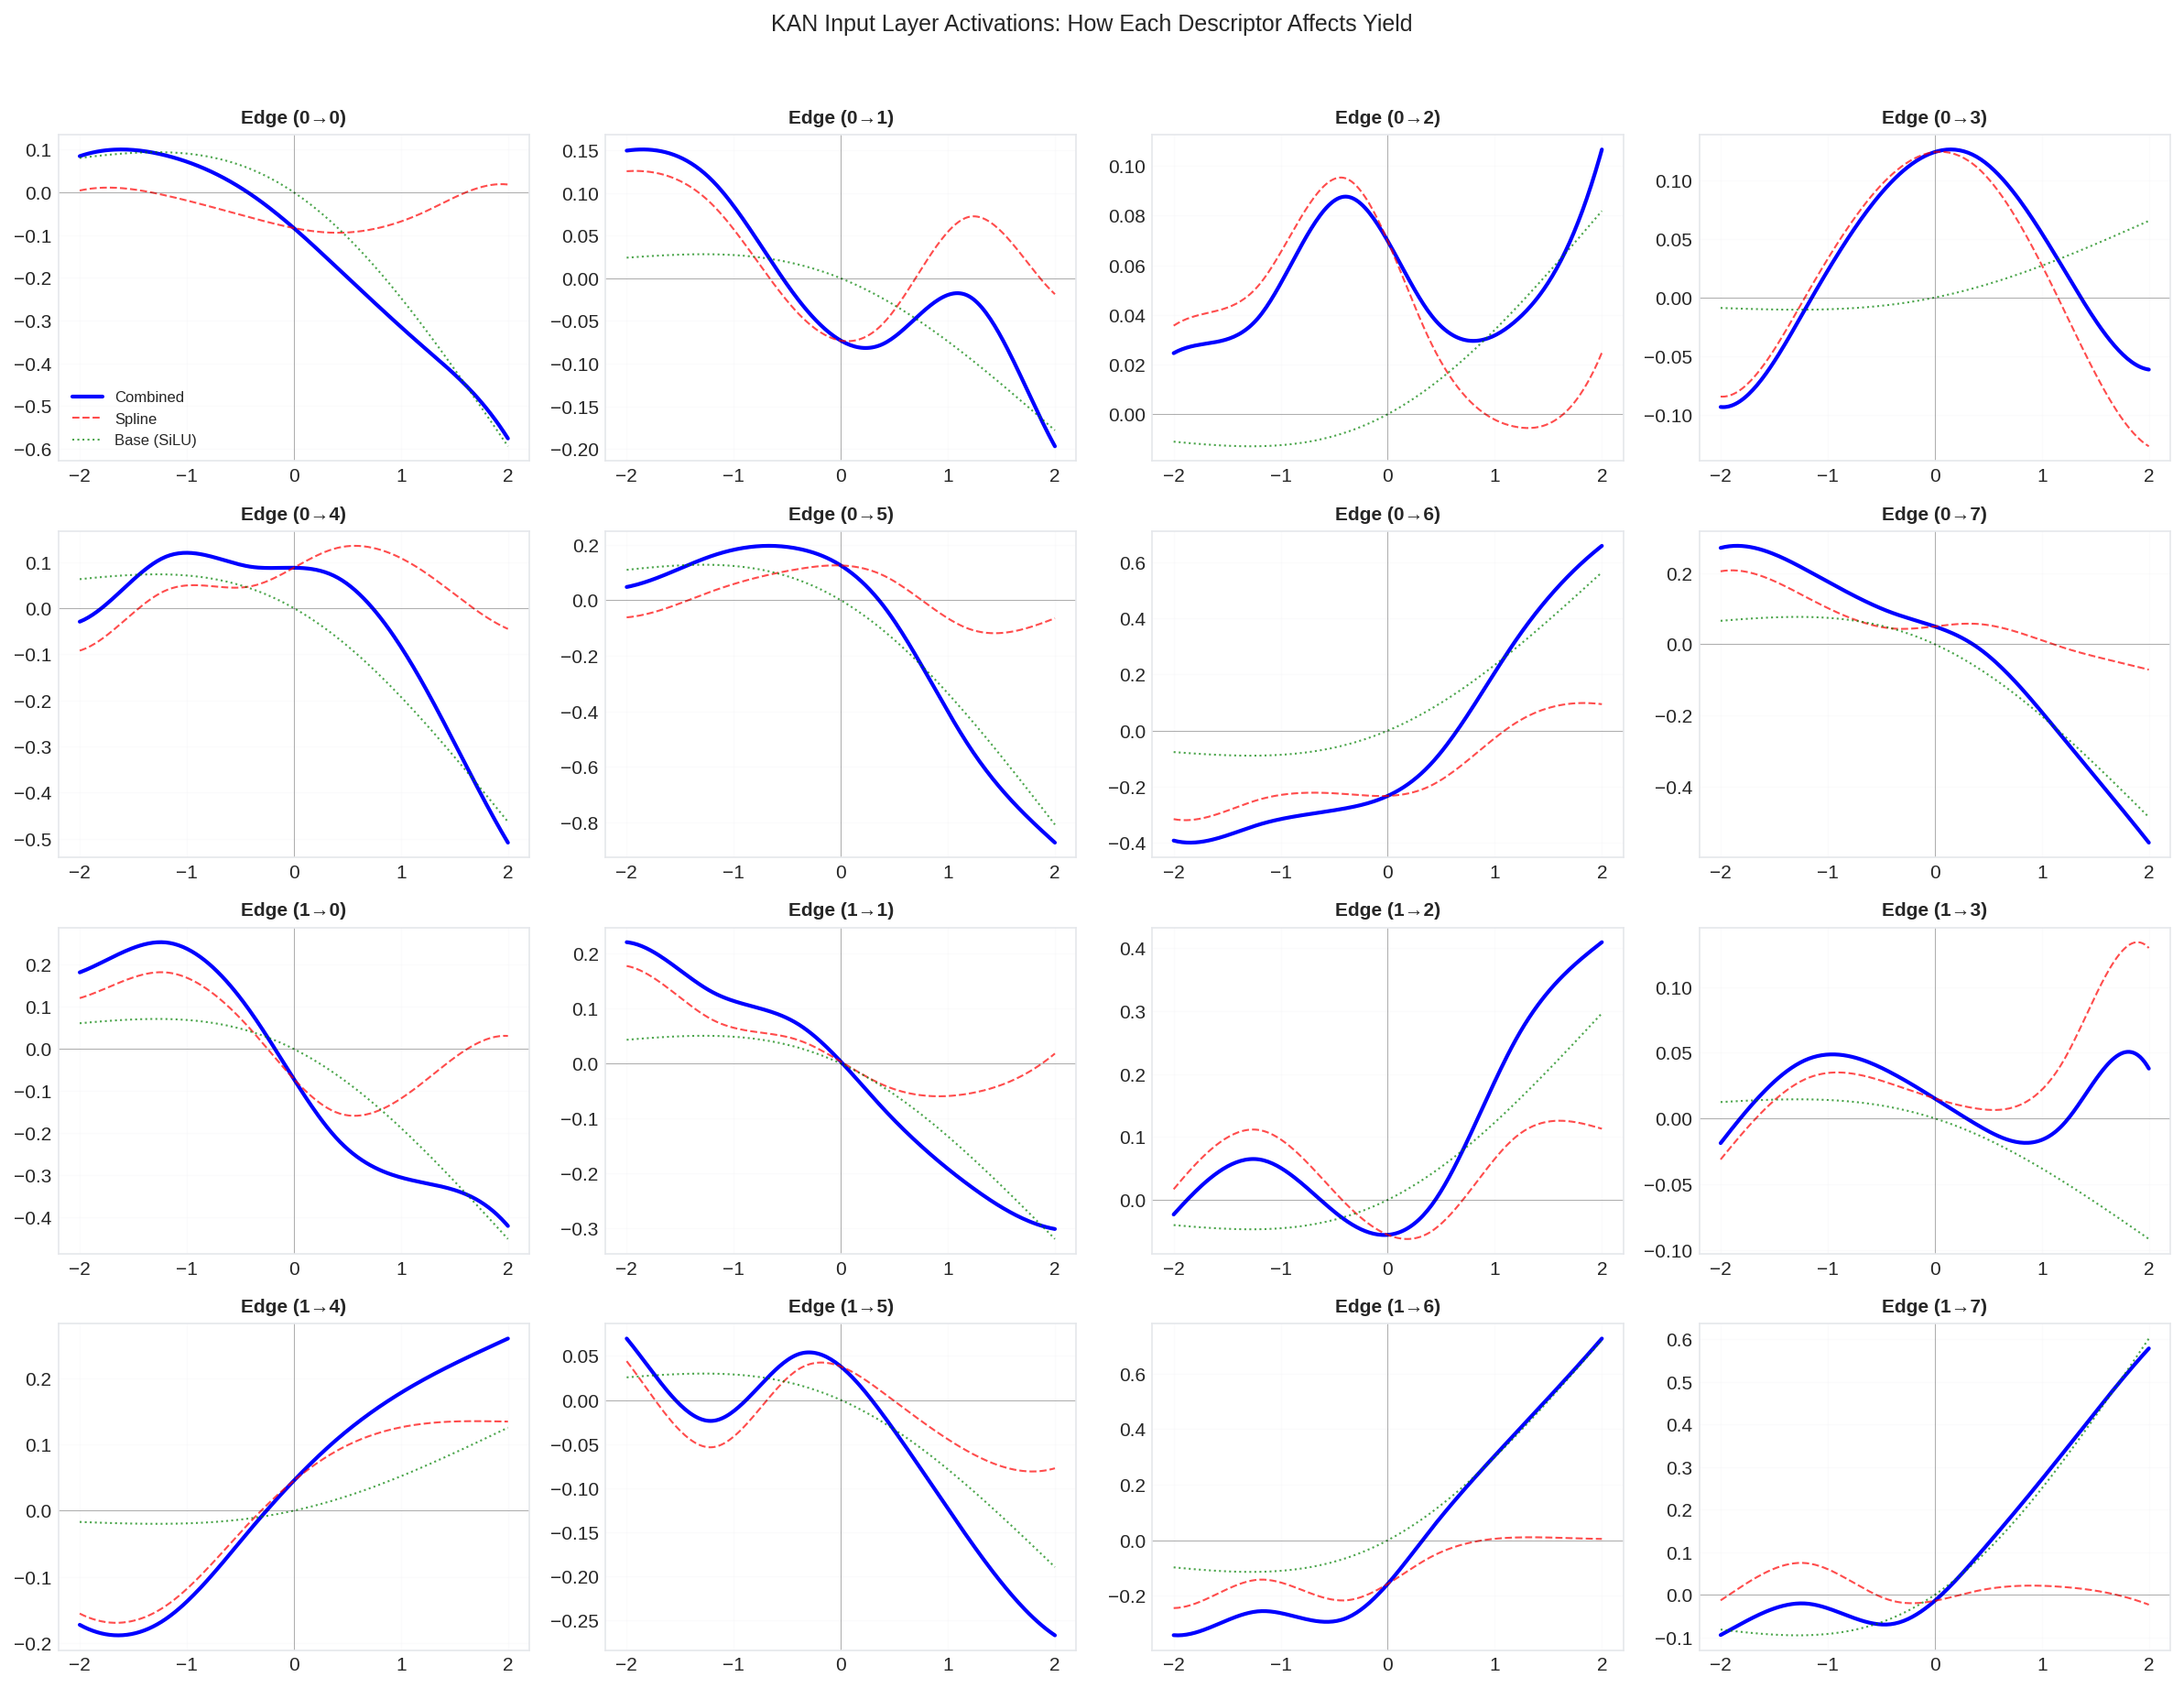

In [13]:
# Visualize KAN activations for the input layer
kan.plot_activations(layer_idx=0, figsize=(16, 12))
plt.suptitle('KAN Input Layer Activations: How Each Descriptor Affects Yield', y=1.02)
plt.tight_layout()
plt.show()

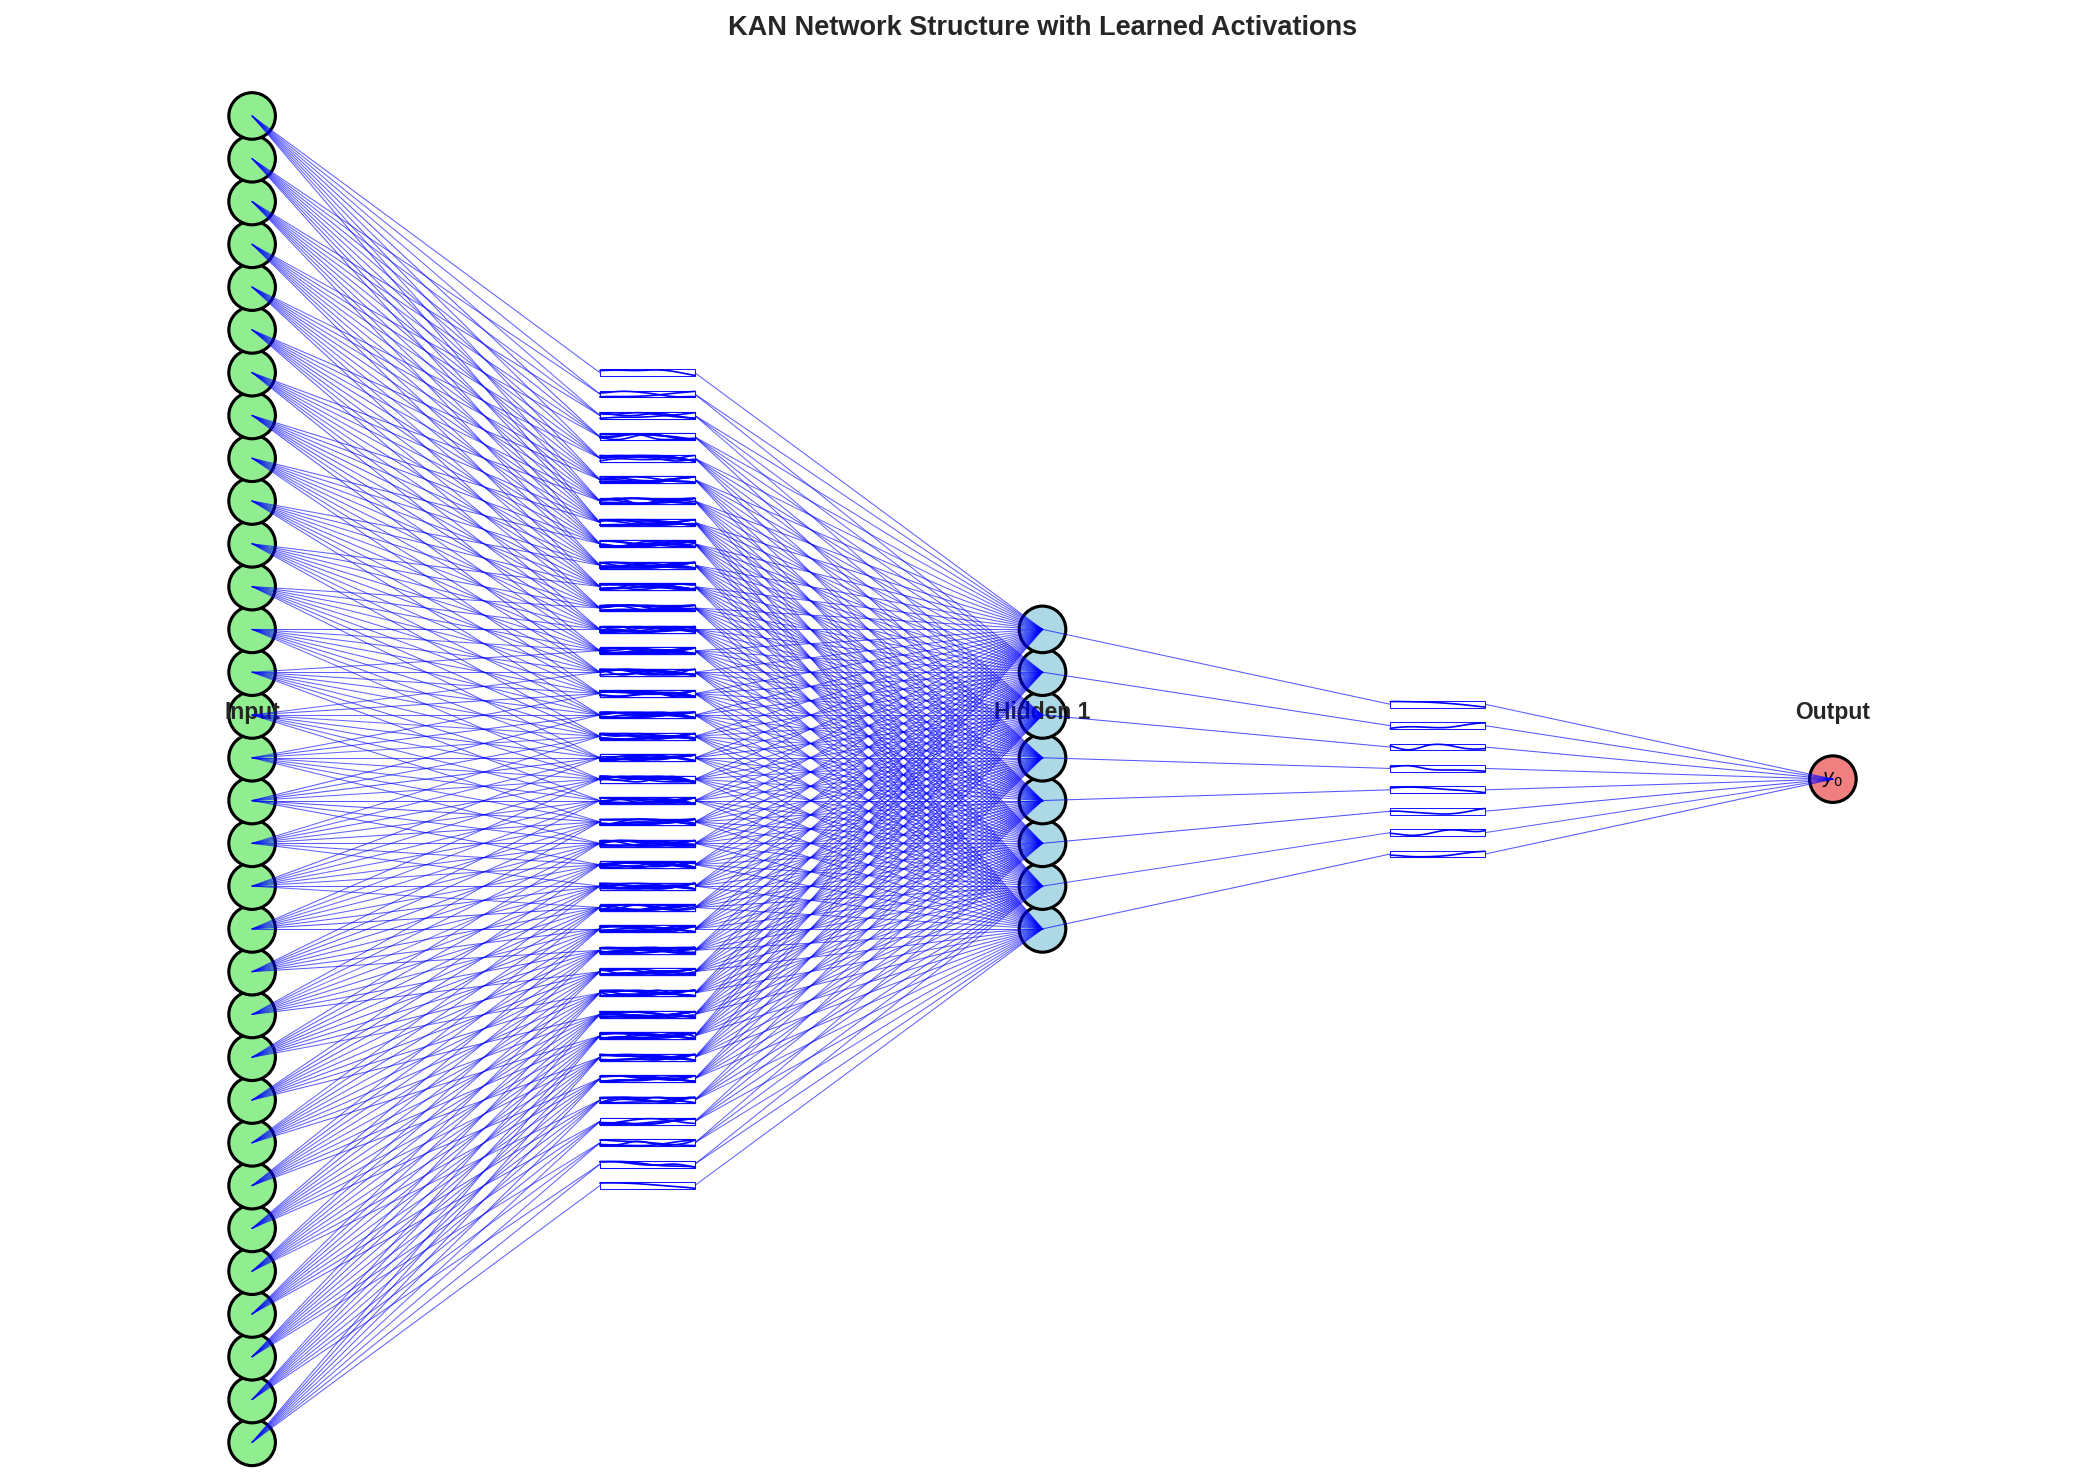

In [14]:
# Network visualization
kan.plot_network(figsize=(14, 10))
plt.title('KAN Network Structure with Learned Activations')
plt.show()

## 6. Chemical Interpretation

Looking at the learned activation functions, we can extract chemical insights:

### Key Observations

1. **Additive LogP**: Often shows nonlinear effects - too hydrophobic or too hydrophilic additives may poison the catalyst differently

2. **Ligand Properties**: The phosphine ligand descriptors often show threshold-like behavior - the catalyst works well above a certain size/electron-donating capacity

3. **Aryl Halide Reactivity**: Electronic properties (related to TPSA, H-bonding) can show optimal ranges

### Comparison with Literature

The Sigman group's MLR work has identified similar relationships but assumed linearity. KAN reveals where these assumptions break down!

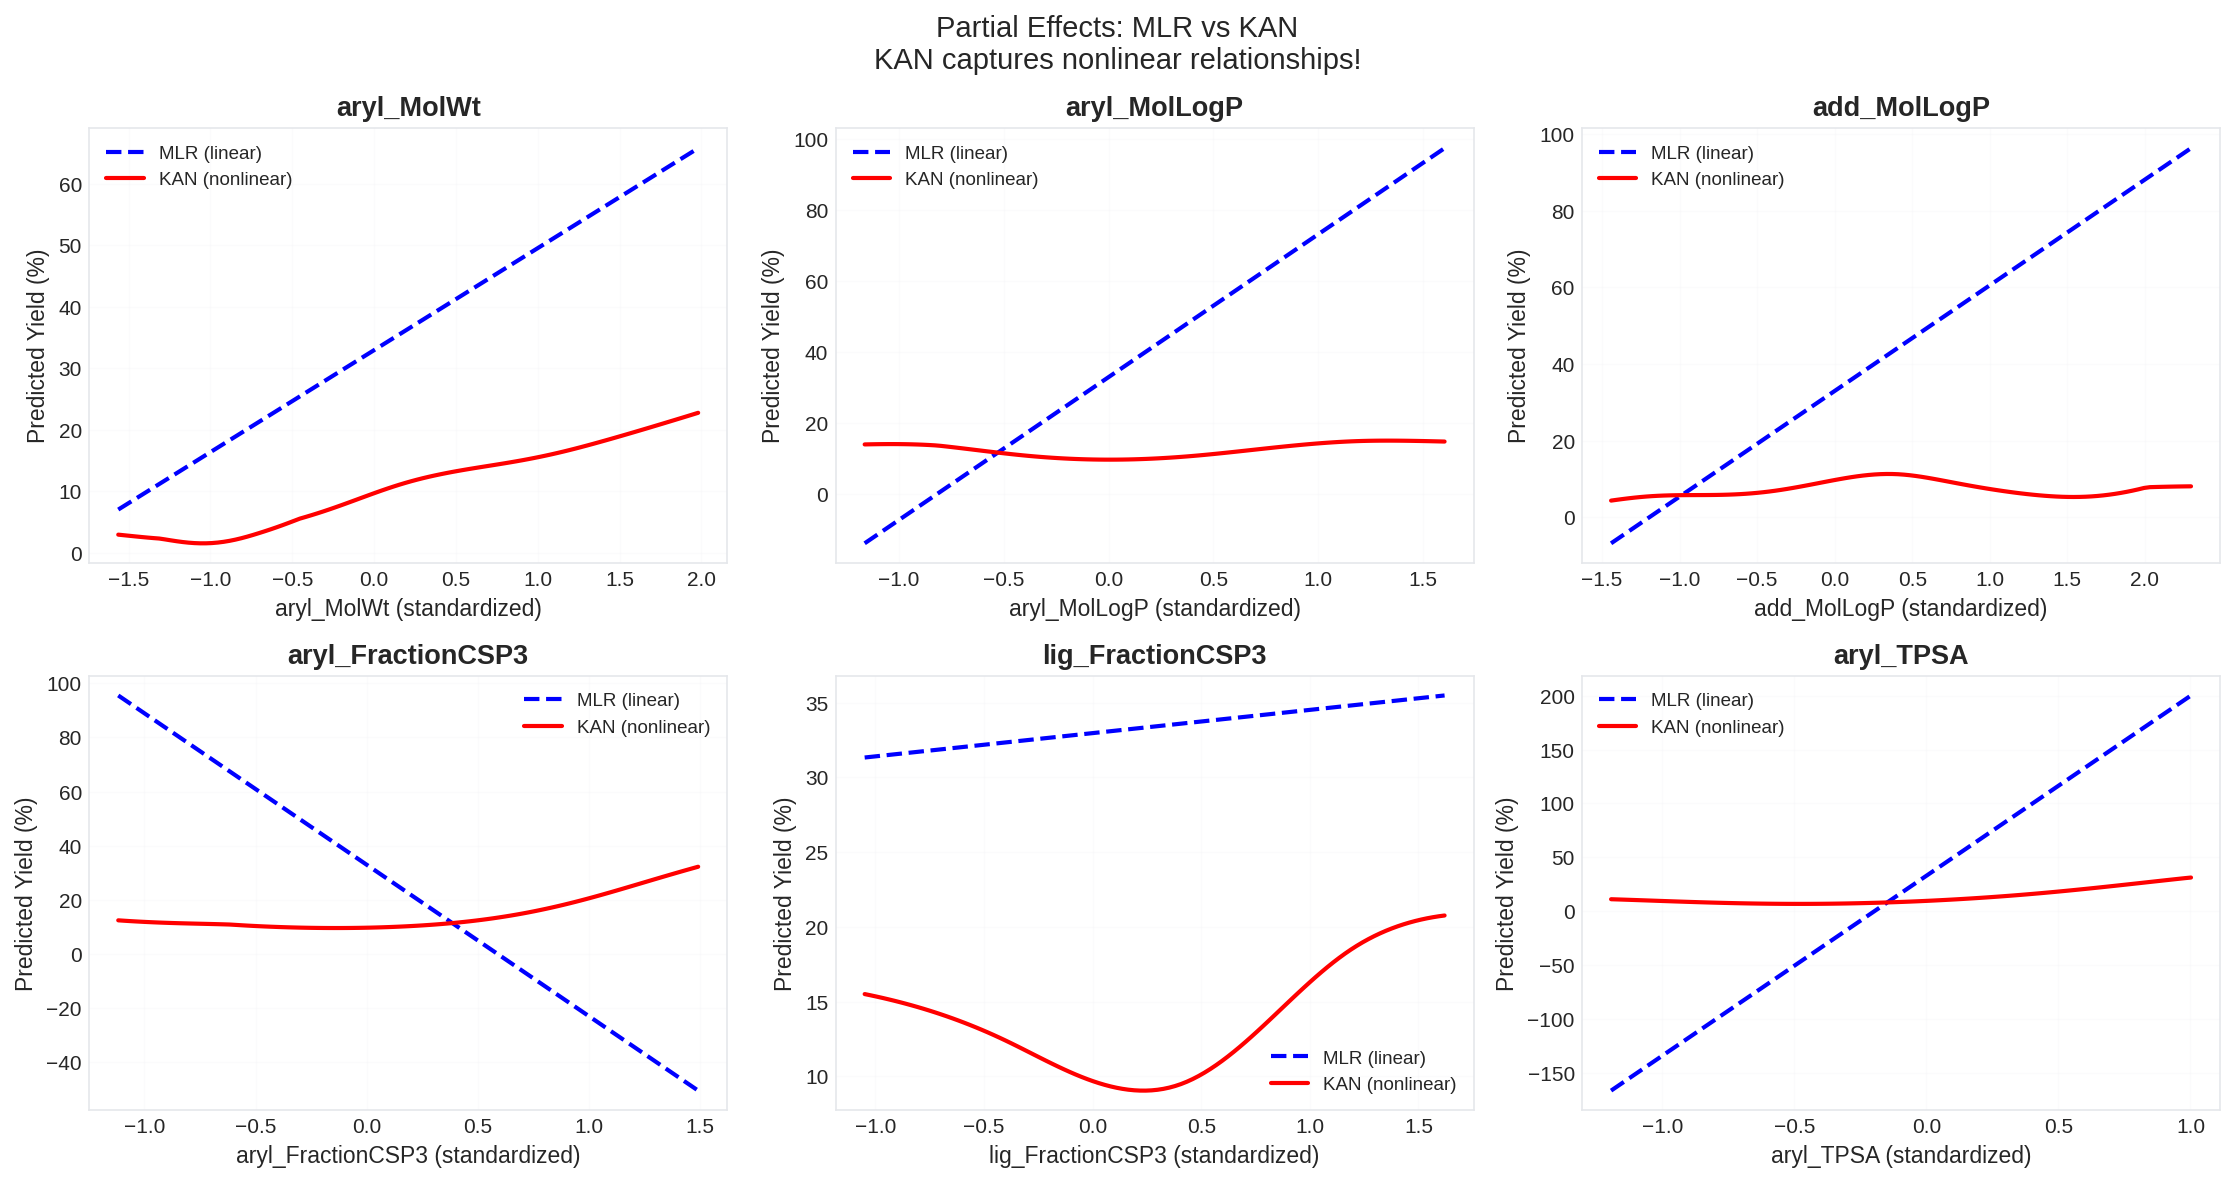

In [15]:
# Partial dependence-like analysis for top features
# Show how yield changes with each descriptor while holding others constant

def plot_partial_effect(model, feature_idx, X, y, feature_name, n_points=100):
    """Plot partial effect of a feature."""
    x_range = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), n_points)
    X_temp = np.tile(X.mean(axis=0), (n_points, 1))
    X_temp[:, feature_idx] = x_range
    
    y_pred = model.predict(X_temp)
    return x_range, y_pred

# Plot partial effects for top features
top_features = rf_importance.head(6)['Feature'].tolist()
top_indices = [feature_names.index(f) for f in top_features]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, feat, idx in zip(axes, top_features, top_indices):
    # MLR prediction (linear)
    x_range_lr, y_pred_lr = plot_partial_effect(lr, idx, X_scaled, y, feat)
    
    # KAN prediction (nonlinear)
    x_range_kan, y_pred_kan = plot_partial_effect(kan, idx, X_scaled, y, feat)
    
    ax.plot(x_range_lr, y_pred_lr, 'b--', linewidth=2, label='MLR (linear)')
    ax.plot(x_range_kan, y_pred_kan, 'r-', linewidth=2, label='KAN (nonlinear)')
    ax.set_xlabel(f'{feat} (standardized)')
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(feat)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Partial Effects: MLR vs KAN\nKAN captures nonlinear relationships!', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Uncertainty Quantification with KAN

KAN also supports uncertainty quantification through ensemble predictions - crucial for making confident predictions in chemistry!

In [16]:
# Train KAN with ensemble for uncertainty quantification
print("Training KAN with uncertainty quantification...")
kan_uq = KAN(
    layers=(n_features, 4, 1),
    n_ensemble=32,  # Ensemble for UQ
    grid_size=5,
    loss_type='crps',
)

# Split validation set for calibration
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
kan_uq.fit(X_tr, y_tr, val_X=X_val, val_y=y_val, maxiter=200)

# Get predictions with uncertainty
y_pred_uq = kan_uq.predict(X_test)
ensemble_preds = kan_uq.predict_ensemble(X_test)
y_std = ensemble_preds.std(axis=1)

print(f"\nTest R²: {r2_score(y_test, y_pred_uq):.4f}")
print(f"Mean uncertainty (std): {y_std.mean():.2f}%")

Training KAN with uncertainty quantification...



Calibration factor α = 1.0252
  ✓ Model is well-calibrated



Test R²: 0.6779
Mean uncertainty (std): 13.77%


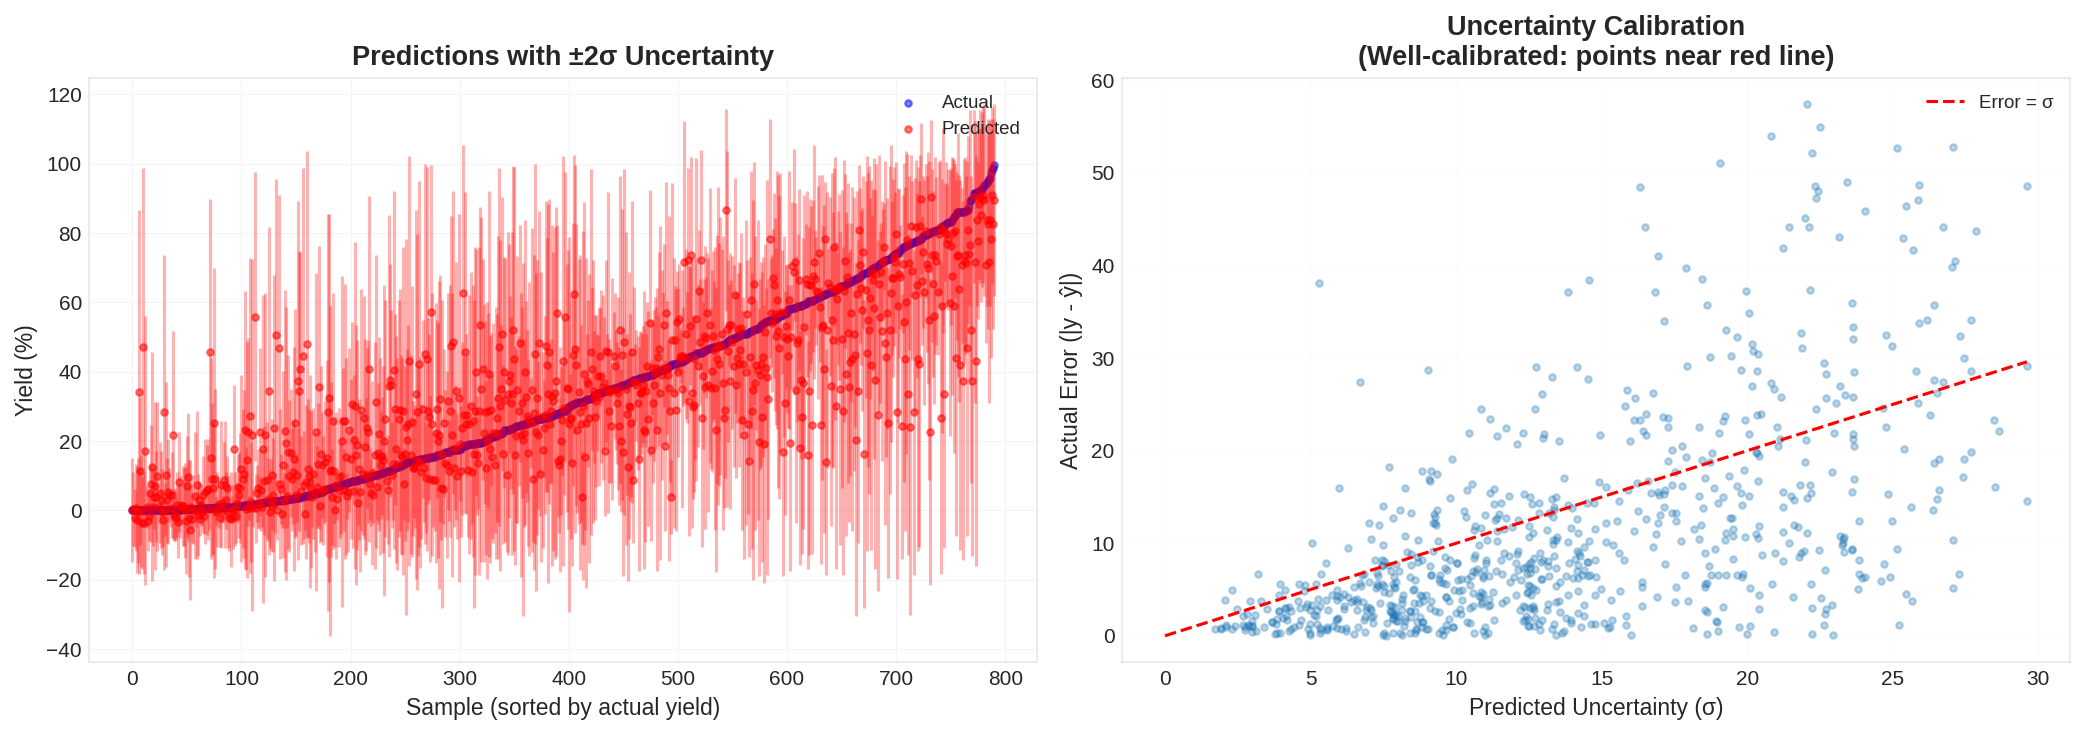

In [17]:
# Visualize predictions with uncertainty
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction vs actual with error bars
sort_idx = np.argsort(y_test)
axes[0].errorbar(range(len(y_test)), y_pred_uq[sort_idx], yerr=2*y_std[sort_idx], 
                 fmt='none', alpha=0.3, capsize=0, color='red')
axes[0].scatter(range(len(y_test)), y_test[sort_idx], s=10, alpha=0.5, label='Actual', color='blue')
axes[0].scatter(range(len(y_test)), y_pred_uq[sort_idx], s=10, alpha=0.5, label='Predicted', color='red')
axes[0].set_xlabel('Sample (sorted by actual yield)')
axes[0].set_ylabel('Yield (%)')
axes[0].set_title('Predictions with ±2σ Uncertainty')
axes[0].legend()

# Uncertainty vs error
errors = np.abs(y_test - y_pred_uq)
axes[1].scatter(y_std, errors, alpha=0.3, s=10)
axes[1].plot([0, y_std.max()], [0, y_std.max()], 'r--', label='Error = σ')
axes[1].set_xlabel('Predicted Uncertainty (σ)')
axes[1].set_ylabel('Actual Error (|y - ŷ|)')
axes[1].set_title('Uncertainty Calibration\n(Well-calibrated: points near red line)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

### Key Takeaways

1. **KAN bridges the gap** between simple interpretable models (MLR) and powerful but opaque models (Random Forest, Neural Networks)

2. **Interpretability in chemistry**: KAN's learned activation functions can reveal:
   - Nonlinear structure-activity relationships
   - Optimal ranges for descriptors
   - Threshold effects that linear models miss

3. **Uncertainty quantification** is crucial for making actionable predictions in synthesis planning

### When to Use KAN for Chemistry

- When you want **interpretability** but suspect **nonlinear effects**
- For small-to-medium datasets where neural networks might overfit
- When **physical insight** into the learned relationships matters
- As a complement to traditional Sigman-style MLR analysis

### Future Directions

- Use KAN with **DFT-computed descriptors** for higher accuracy
- Apply to **enantioselectivity prediction** (Sigman's specialty)
- Combine with **symbolic regression** to extract explicit equations

In [18]:
# Final KAN report
print("=" * 60)
print("FINAL KAN MODEL REPORT")
print("=" * 60)
kan.report()
print(f"\nTest Performance:")
print(f"  R² = {results['KAN']['r2']:.4f}")
print(f"  MAE = {results['KAN']['mae']:.2f}%")
print(f"\nComparison:")
print(f"  MLR R² = {results['MLR']['r2']:.4f}")
print(f"  Random Forest R² = {results['Random Forest']['r2']:.4f}")
print("=" * 60)

FINAL KAN MODEL REPORT
KAN Optimization Report:
  Architecture: (32, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.285625
  Converged: False

Test Performance:
  R² = 0.7048
  MAE = 10.94%

Comparison:
  MLR R² = 0.5469
  Random Forest R² = 0.5588


## 9. Threshold Analysis: Sigman/Doyle Approach

The Sigman and Doyle groups pioneered single-parameter threshold analysis for catalyst optimization. This approach identifies critical descriptor values that separate successful from unsuccessful reactions.

**Reference:** [SigmanGroup/Threshold](https://github.com/SigmanGroup/Threshold)

We implement this using `DecisionTreeClassifier` with `max_depth=1` to find optimal thresholds for each descriptor.

In [19]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score

# For threshold analysis, we'll classify yield as "high" (>50%) or "low" (<=50%)
y_binary = (y > 50).astype(int)
y_train_binary = (y_train > 50).astype(int)
y_test_binary = (y_test > 50).astype(int)

# Analyze each feature with depth-1 decision tree (single threshold)
threshold_results = []

for idx, feat_name in enumerate(feature_names):
    # Train depth-1 tree on training data
    tree = DecisionTreeClassifier(max_depth=1, random_state=42)
    tree.fit(X_train[:, idx:idx+1], y_train_binary)
    
    # Extract threshold
    if tree.tree_.threshold[0] != -2.0:  # -2.0 means leaf node
        threshold = tree.tree_.threshold[0]
        
        # Make predictions
        y_pred_thresh = tree.predict(X_test[:, idx:idx+1])
        
        # Calculate metrics
        acc = accuracy_score(y_test_binary, y_pred_thresh)
        prec = precision_score(y_test_binary, y_pred_thresh, zero_division=0)
        rec = recall_score(y_test_binary, y_pred_thresh, zero_division=0)
        
        threshold_results.append({
            'Feature': feat_name,
            'Threshold': threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec
        })

# Sort by accuracy
threshold_df = pd.DataFrame(threshold_results).sort_values('Accuracy', ascending=False)
print("Top 10 Single-Parameter Thresholds for Yield Classification:")
print("(Classifying reactions as high-yield >50% or low-yield ≤50%)")
print(threshold_df.head(10).to_string(index=False))

Top 10 Single-Parameter Thresholds for Yield Classification:
(Classifying reactions as high-yield >50% or low-yield ≤50%)
              Feature  Threshold  Accuracy  Precision  Recall
            lig_MolWt  -0.694653  0.699115        0.0     0.0
          lig_MolLogP  -0.330140  0.699115        0.0     0.0
             lig_TPSA  -0.000758  0.699115        0.0     0.0
lig_NumRotatableBonds  -0.708807  0.699115        0.0     0.0
    lig_NumHAcceptors  -0.000758  0.699115        0.0     0.0
     lig_FractionCSP3  -0.287854  0.699115        0.0     0.0
            add_MolWt  -0.250025  0.699115        0.0     0.0
          add_MolLogP  -1.010639  0.699115        0.0     0.0
             add_TPSA   0.234201  0.699115        0.0     0.0
add_NumRotatableBonds   0.694334  0.699115        0.0     0.0


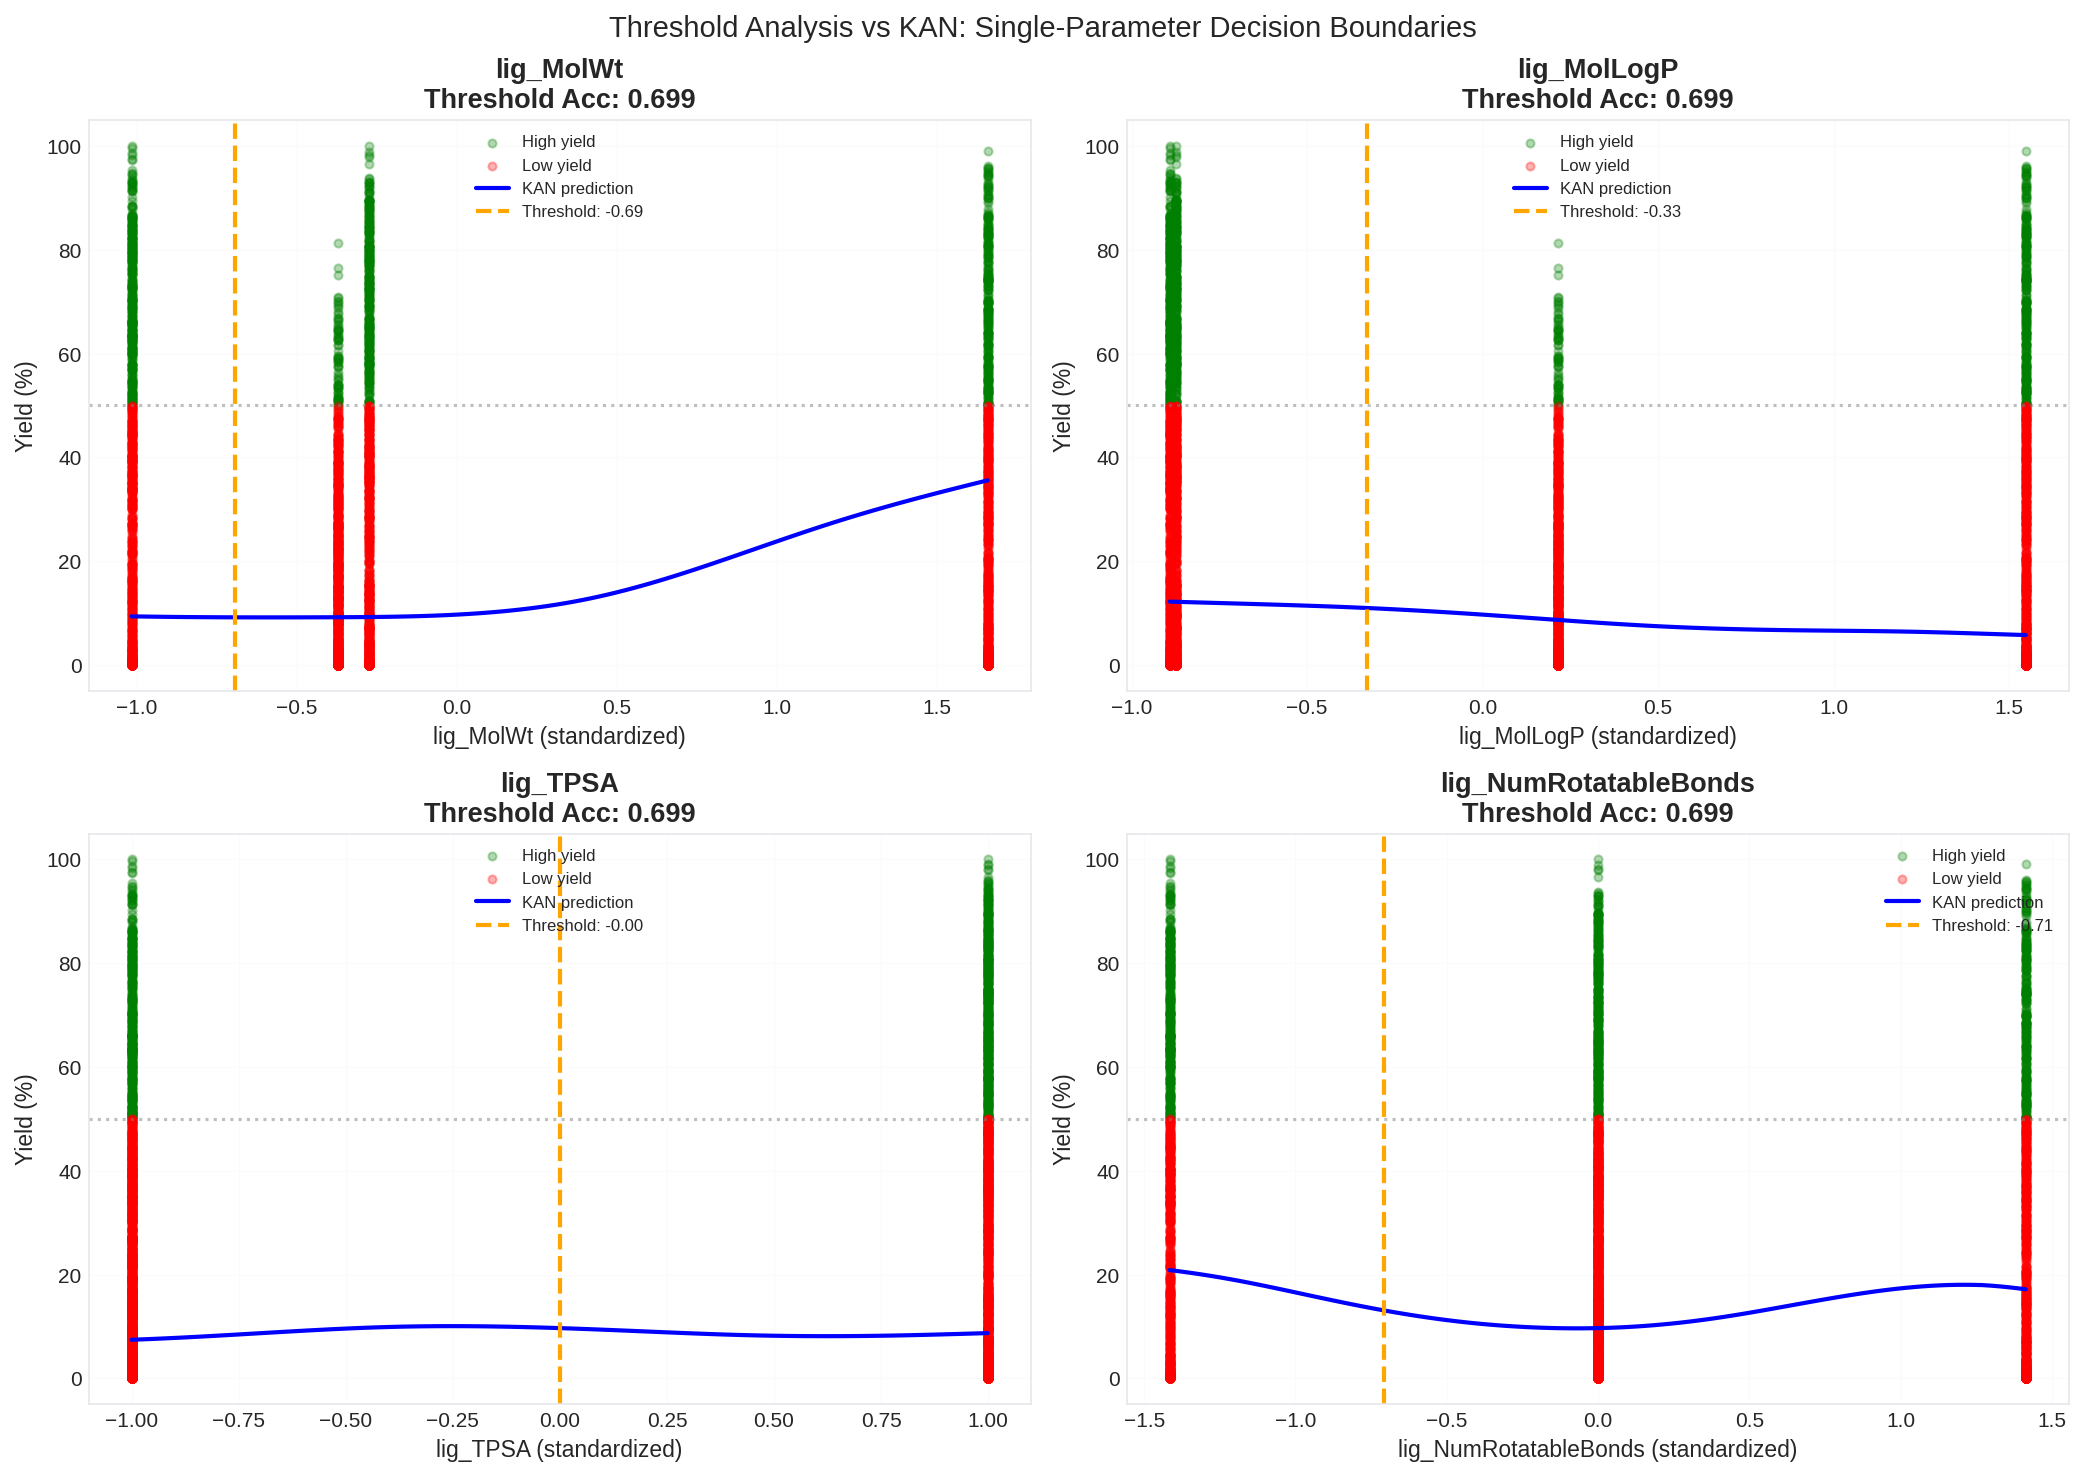

In [20]:
# Visualize top threshold features vs KAN predictions
top_threshold_features = threshold_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, feat_name in zip(axes, top_threshold_features):
    idx = feature_names.index(feat_name)
    thresh_val = threshold_df[threshold_df['Feature'] == feat_name]['Threshold'].values[0]
    
    # Get KAN partial predictions
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_kan_pred = kan.predict(X_temp)
    
    # Plot actual data
    ax.scatter(X_scaled[y > 50, idx], y[y > 50], alpha=0.3, s=15, c='green', label='High yield')
    ax.scatter(X_scaled[y <= 50, idx], y[y <= 50], alpha=0.3, s=15, c='red', label='Low yield')
    
    # Plot KAN prediction
    ax.plot(x_range, y_kan_pred, 'b-', linewidth=2, label='KAN prediction')
    
    # Plot threshold
    ax.axvline(thresh_val, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {thresh_val:.2f}')
    ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel(f'{feat_name} (standardized)')
    ax.set_ylabel('Yield (%)')
    ax.set_title(f'{feat_name}\nThreshold Acc: {threshold_df[threshold_df["Feature"] == feat_name]["Accuracy"].values[0]:.3f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Threshold Analysis vs KAN: Single-Parameter Decision Boundaries', fontsize=14)
plt.tight_layout()
plt.show()

## 10. KANLLPR: Principled Uncertainty Quantification

KANLLPR (KAN with Last-Layer Prediction Rigidity) provides principled uncertainty estimates based on the rigidity formalism. Unlike ensemble methods, LLPR:
- Requires only a single forward pass (efficient)
- Provides well-calibrated uncertainties  
- Identifies reactions where predictions are uncertain (guides experiments)

In [21]:
from pycse.sklearn import KANLLPR

# Train KANLLPR model
print("Training KANLLPR for uncertainty quantification...")
kanllpr = KANLLPR(
    layers=(n_features, 8, 1),
    grid_size=5,
    val_size=0.2,
    seed=42
)
kanllpr.fit(X_train, y_train, maxiter=300)

# Get predictions with uncertainty
y_pred_llpr, y_std_llpr = kanllpr.predict_with_uncertainty(X_test)

# Print metrics
print(f"\nTest R²: {kanllpr.score(X_test, y_test):.4f}")
kanllpr.print_metrics(X_test, y_test)

Training KANLLPR for uncertainty quantification...


Calibrated: α²=1.00e+02, ζ²=1.00e-08, NLL=0.8742



Test R²: 0.6877



KANLLPR UNCERTAINTY QUANTIFICATION METRICS

Prediction Accuracy:
  RMSE: 15.595269
  MAE:  11.814832

Uncertainty Quality:
  NLL: 4.247666
  Miscalibration Area: 0.014126

Calibration Diagnostics:
  Z-score mean: 0.0344 (ideal: 0)
  Z-score std:  1.1335 (ideal: 1)

Coverage:
  Within 1σ: 0.700 (expected: 0.683)
  Within 2σ: 0.917 (expected: 0.955)
  Within 3σ: 0.976 (expected: 0.997)



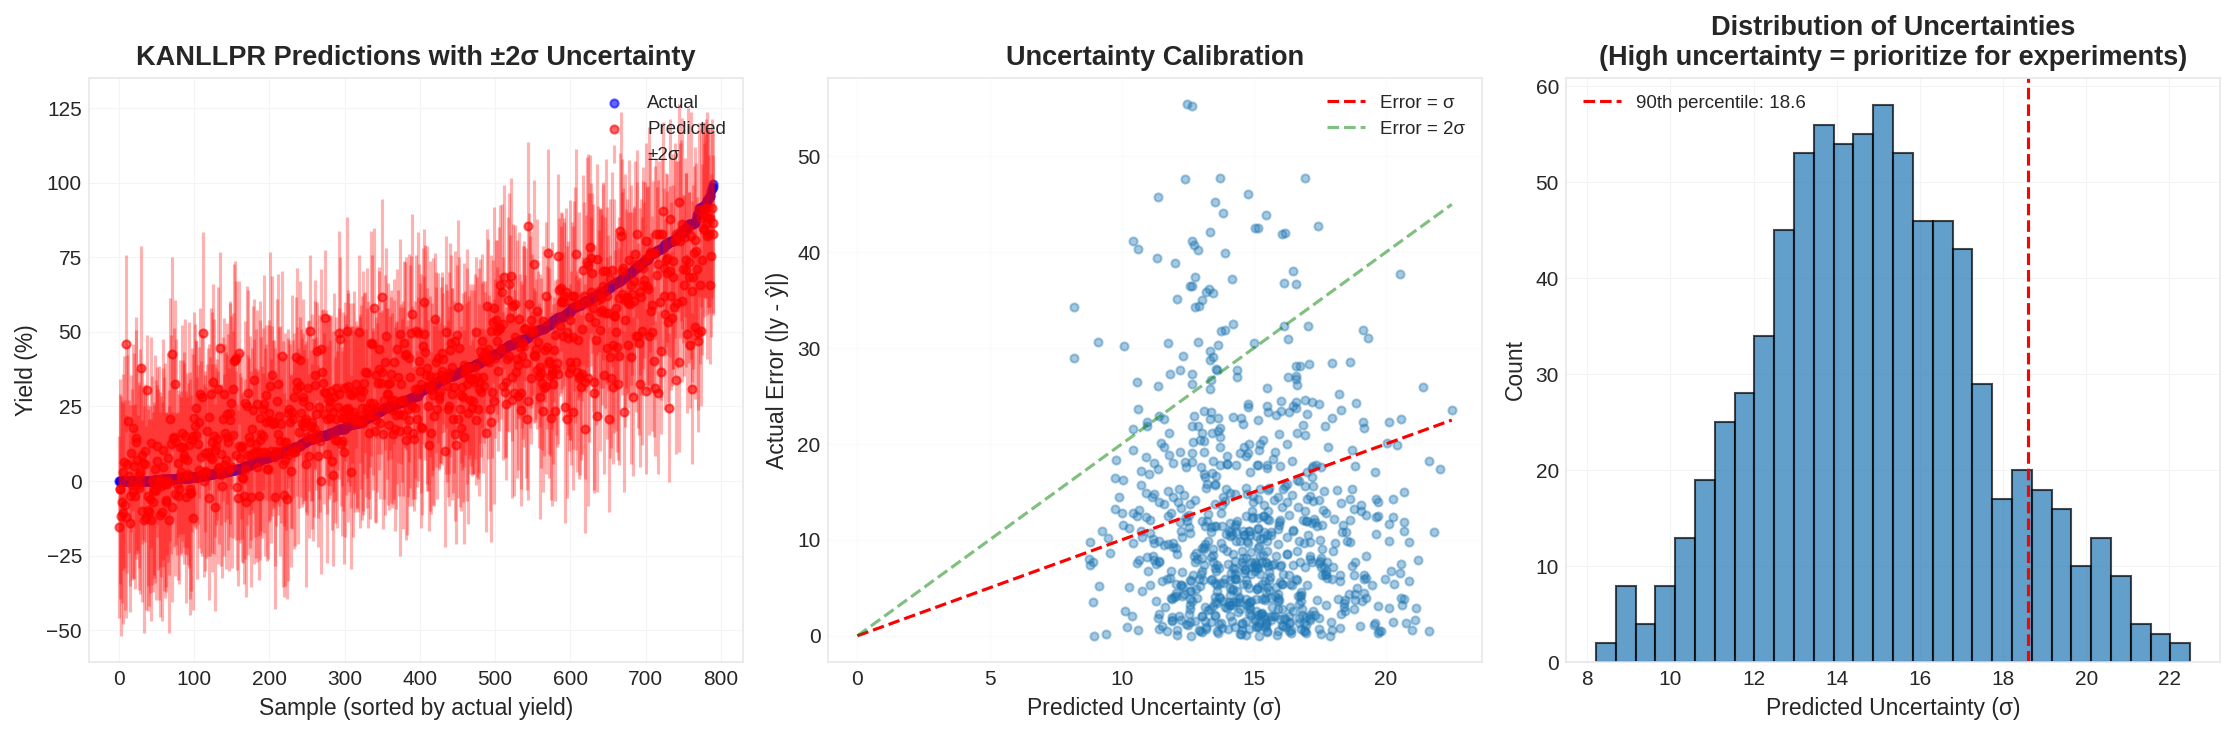


Reactions with highest uncertainty (top 10%):
  Count: 79 reactions
  Mean uncertainty: 19.9%
  Mean actual error: 10.8%


In [22]:
# Visualize predictions with uncertainty
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Predictions vs Actual with error bars
sort_idx = np.argsort(y_test)
axes[0].errorbar(range(len(y_test)), y_pred_llpr[sort_idx], yerr=2*y_std_llpr[sort_idx], 
                 fmt='none', alpha=0.3, capsize=0, color='red', label='±2σ')
axes[0].scatter(range(len(y_test)), y_test[sort_idx], s=15, alpha=0.6, label='Actual', color='blue')
axes[0].scatter(range(len(y_test)), y_pred_llpr[sort_idx], s=15, alpha=0.6, label='Predicted', color='red')
axes[0].set_xlabel('Sample (sorted by actual yield)')
axes[0].set_ylabel('Yield (%)')
axes[0].set_title('KANLLPR Predictions with ±2σ Uncertainty')
axes[0].legend()

# 2. Uncertainty calibration
errors = np.abs(y_test - y_pred_llpr)
axes[1].scatter(y_std_llpr, errors, alpha=0.4, s=15)
axes[1].plot([0, y_std_llpr.max()], [0, y_std_llpr.max()], 'r--', label='Error = σ')
axes[1].plot([0, y_std_llpr.max()], [0, 2*y_std_llpr.max()], 'g--', alpha=0.5, label='Error = 2σ')
axes[1].set_xlabel('Predicted Uncertainty (σ)')
axes[1].set_ylabel('Actual Error (|y - ŷ|)')
axes[1].set_title('Uncertainty Calibration')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Identify high-uncertainty reactions
axes[2].hist(y_std_llpr, bins=30, edgecolor='black', alpha=0.7)
high_uncertainty_threshold = np.percentile(y_std_llpr, 90)
axes[2].axvline(high_uncertainty_threshold, color='red', linestyle='--', 
                label=f'90th percentile: {high_uncertainty_threshold:.1f}')
axes[2].set_xlabel('Predicted Uncertainty (σ)')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Uncertainties\n(High uncertainty = prioritize for experiments)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Report high-uncertainty reactions
high_uncertainty_mask = y_std_llpr > high_uncertainty_threshold
print(f"\nReactions with highest uncertainty (top 10%):")
print(f"  Count: {high_uncertainty_mask.sum()} reactions")
print(f"  Mean uncertainty: {y_std_llpr[high_uncertainty_mask].mean():.1f}%")
print(f"  Mean actual error: {errors[high_uncertainty_mask].mean():.1f}%")

## 11. Deep Chemical Interpretability

Analyze the learned KAN activation function shapes to extract mechanistic insights:
- **Linear**: Constant marginal effect
- **Sigmoidal**: Switch-like behavior with a critical threshold
- **Threshold**: Step-function response
- **U-shaped**: Optimal intermediate range (Goldilocks zone)
- **Saturating**: Diminishing returns beyond a certain value

In [23]:
def classify_activation_shape(x_range, y_pred):
    """Classify the shape of a KAN activation function."""
    # Normalize predictions
    y_std = y_pred.std()
    if y_std < 1e-8:
        return "Constant", "No effect"
    y_norm = (y_pred - y_pred.mean()) / (y_std + 1e-8)
    
    # Calculate derivatives
    dy = np.gradient(y_norm)
    d2y = np.gradient(dy)
    
    # Features for classification
    linearity = 1 - np.std(dy) / (np.abs(dy).mean() + 1e-8)  # High = linear
    monotonicity = np.abs(np.sum(np.sign(dy))) / len(dy)  # High = monotonic
    has_extremum = np.any(dy[:-1] * dy[1:] < 0)  # Sign changes in derivative
    curvature = np.mean(np.abs(d2y))  # High = curved
    
    # Classify
    if linearity > 0.8:
        return "Linear", "Constant marginal effect"
    elif has_extremum and not monotonicity > 0.5:
        return "U-shaped", "Optimal intermediate range"
    elif curvature > 0.3 and monotonicity > 0.7:
        # Check if saturating
        if np.abs(dy[-5:]).mean() < np.abs(dy[:5]).mean() * 0.3:
            return "Saturating", "Diminishing returns"
        else:
            return "Sigmoidal", "Critical threshold transition"
    elif monotonicity > 0.9:
        return "Threshold", "Critical value required"
    else:
        return "Complex", "Multi-regime behavior"

# Analyze each feature's activation shape
activation_analysis = []

for idx, feat_name in enumerate(feature_names):
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred = np.array(kan.predict(X_temp), dtype=float)
    
    shape, interpretation = classify_activation_shape(x_range, y_pred)
    
    # Calculate nonlinearity score with error handling
    try:
        if y_pred.std() < 1e-8 or np.any(~np.isfinite(y_pred)):
            nonlinearity = 0.0
        else:
            linear_fit = np.polyfit(x_range, y_pred, 1)
            y_linear = np.polyval(linear_fit, x_range)
            nonlinearity = np.sqrt(np.mean((y_pred - y_linear)**2)) / (y_pred.std() + 1e-8)
    except:
        nonlinearity = 0.0
    
    activation_analysis.append({
        'Feature': feat_name,
        'Shape': shape,
        'Interpretation': interpretation,
        'Nonlinearity': nonlinearity
    })

# Show results sorted by nonlinearity
analysis_df = pd.DataFrame(activation_analysis).sort_values('Nonlinearity', ascending=False)
print("Activation Shape Analysis (sorted by nonlinearity):")
print(analysis_df.head(15).to_string(index=False))

Activation Shape Analysis (sorted by nonlinearity):
              Feature    Shape             Interpretation  Nonlinearity
lig_NumRotatableBonds U-shaped Optimal intermediate range      0.999960
add_NumRotatableBonds U-shaped Optimal intermediate range      0.987518
          add_MolLogP U-shaped Optimal intermediate range      0.987053
             lig_TPSA U-shaped Optimal intermediate range      0.984687
   base_NumHAcceptors U-shaped Optimal intermediate range      0.981708
    add_NumHAcceptors U-shaped Optimal intermediate range      0.980743
         aryl_MolLogP U-shaped Optimal intermediate range      0.934164
     lig_FractionCSP3 U-shaped Optimal intermediate range      0.864287
            add_MolWt U-shaped Optimal intermediate range      0.864187
         base_MolLogP U-shaped Optimal intermediate range      0.850948
     add_FractionCSP3 U-shaped Optimal intermediate range      0.741431
    base_FractionCSP3 U-shaped Optimal intermediate range      0.730227
 add_NumArom

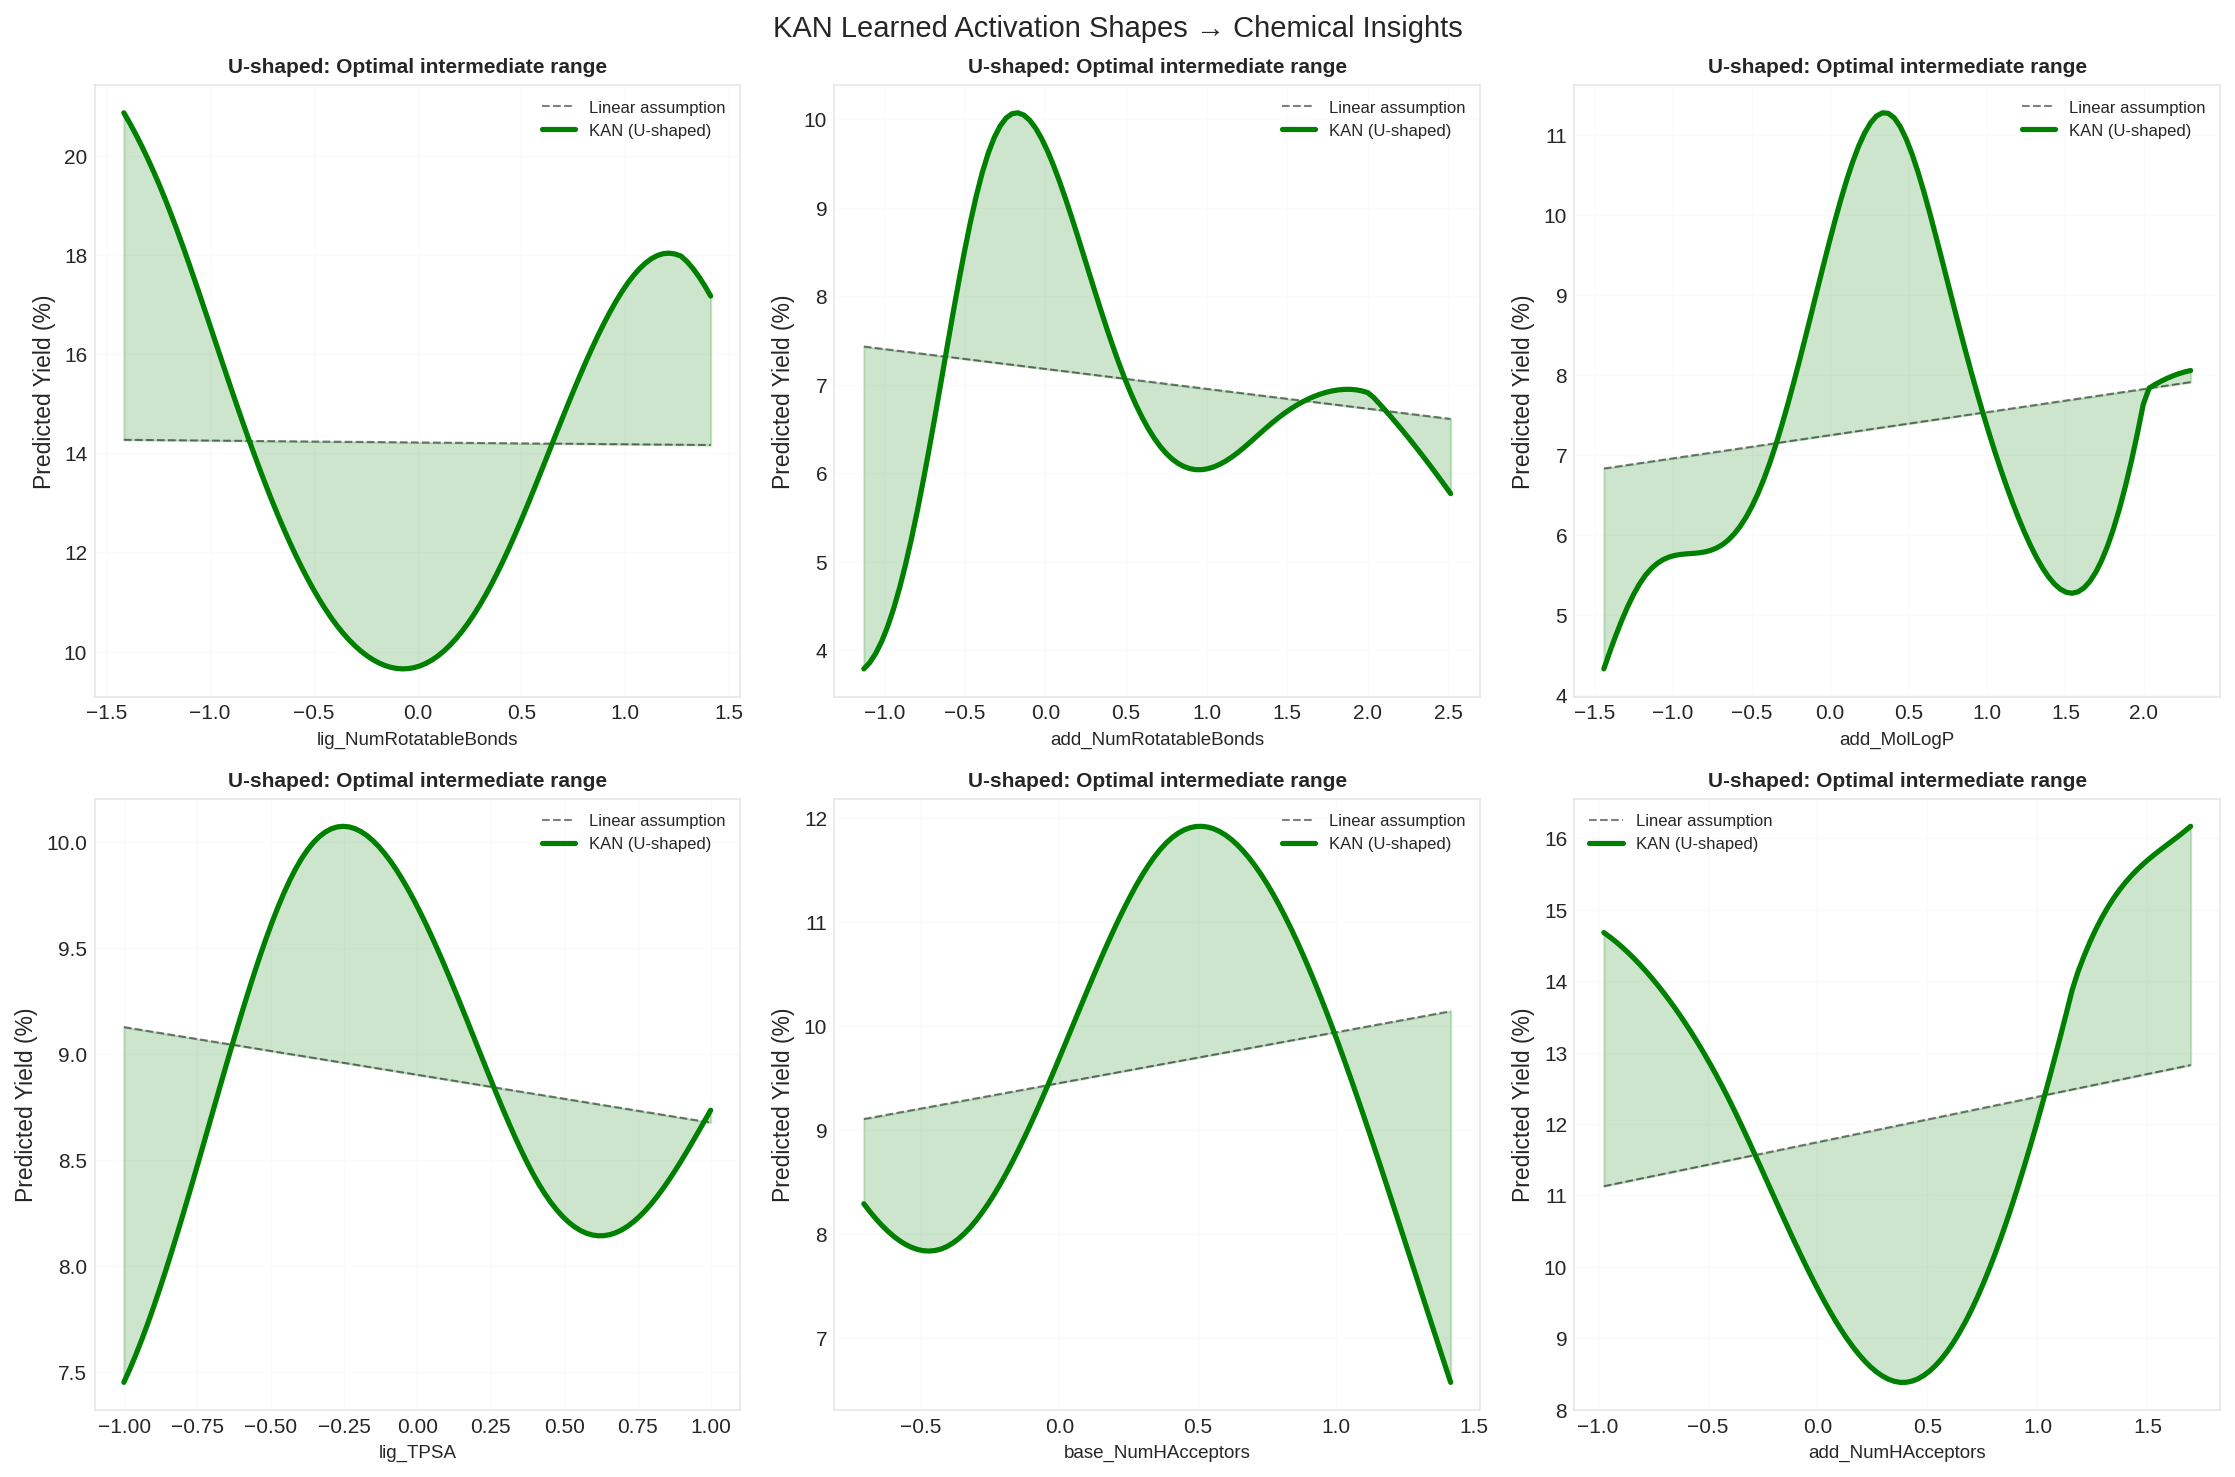

In [24]:
# Visualize activation shapes for most nonlinear features
most_nonlinear = analysis_df.head(6)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

shape_colors = {
    'Linear': 'gray', 'Sigmoidal': 'blue', 'Threshold': 'orange',
    'U-shaped': 'green', 'Saturating': 'purple', 'Complex': 'red',
    'Constant': 'black'
}

for ax, feat_name in zip(axes, most_nonlinear):
    idx = feature_names.index(feat_name)
    
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred = kan.predict(X_temp)
    
    # Linear fit for comparison with error handling
    try:
        if y_pred.std() < 1e-8:
            y_linear = np.full_like(y_pred, y_pred.mean())
        else:
            linear_fit = np.polyfit(x_range, y_pred, 1)
            y_linear = np.polyval(linear_fit, x_range)
    except:
        y_linear = np.full_like(y_pred, y_pred.mean())
    
    shape = analysis_df[analysis_df['Feature'] == feat_name]['Shape'].values[0]
    interp = analysis_df[analysis_df['Feature'] == feat_name]['Interpretation'].values[0]
    
    ax.plot(x_range, y_linear, 'k--', alpha=0.5, linewidth=1, label='Linear assumption')
    ax.plot(x_range, y_pred, color=shape_colors.get(shape, 'blue'), linewidth=2.5, label=f'KAN ({shape})')
    ax.fill_between(x_range, y_linear, y_pred, alpha=0.2, color=shape_colors.get(shape, 'blue'))
    
    ax.set_xlabel(feat_name, fontsize=9)
    ax.set_ylabel('Predicted Yield (%)')
    ax.set_title(f'{shape}: {interp}', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('KAN Learned Activation Shapes → Chemical Insights', fontsize=14)
plt.tight_layout()
plt.show()

## 12. Reactivity Cliff Analysis

Identify regions where small changes in descriptors cause large changes in yield. These "reactivity cliffs" indicate mechanistic boundaries where reaction behavior changes dramatically.

In [25]:
def compute_sensitivity(model, X, feature_idx, epsilon=0.01):
    """Compute numerical gradient (sensitivity) of model predictions w.r.t. a feature."""
    X_plus = X.copy()
    X_plus[:, feature_idx] += epsilon
    X_minus = X.copy()
    X_minus[:, feature_idx] -= epsilon
    return (model.predict(X_plus) - model.predict(X_minus)) / (2 * epsilon)

# Compute sensitivity for each feature on test set
sensitivities = np.zeros((len(X_test), len(feature_names)))

for idx in range(len(feature_names)):
    sensitivities[:, idx] = compute_sensitivity(kan, X_test, idx)

# Find average absolute sensitivity per feature
# Convert to numpy arrays (KAN returns JAX arrays)
sensitivities = np.array(sensitivities, dtype=float)
avg_sensitivity = np.abs(sensitivities).mean(axis=0)
sensitivity_df = pd.DataFrame({
    'Feature': feature_names,
    'Avg_Sensitivity': avg_sensitivity,
    'Max_Sensitivity': np.abs(sensitivities).max(axis=0)
}).sort_values('Avg_Sensitivity', ascending=False)

print("Feature Sensitivity Analysis (derivative magnitude):")
print("High sensitivity = small changes cause large yield changes")
print(sensitivity_df.head(10).to_string(index=False))

Feature Sensitivity Analysis (derivative magnitude):
High sensitivity = small changes cause large yield changes
              Feature  Avg_Sensitivity  Max_Sensitivity
base_NumAromaticRings     5.041172e+08     5.041194e+08
       add_NumHDonors     4.605081e+08     4.605105e+08
       lig_NumHDonors     3.544189e+08     3.544214e+08
 lig_NumAromaticRings     2.544109e+08     2.544135e+08
      base_NumHDonors     1.285892e+08     1.285916e+08
      aryl_NumHDonors     9.900992e+07     9.901189e+07
aryl_NumAromaticRings     8.647012e+07     8.647253e+07
            aryl_TPSA     1.793510e+01     4.686042e+01
     add_FractionCSP3     1.778193e+01     8.534037e+01
           aryl_MolWt     1.421920e+01     6.110813e+01


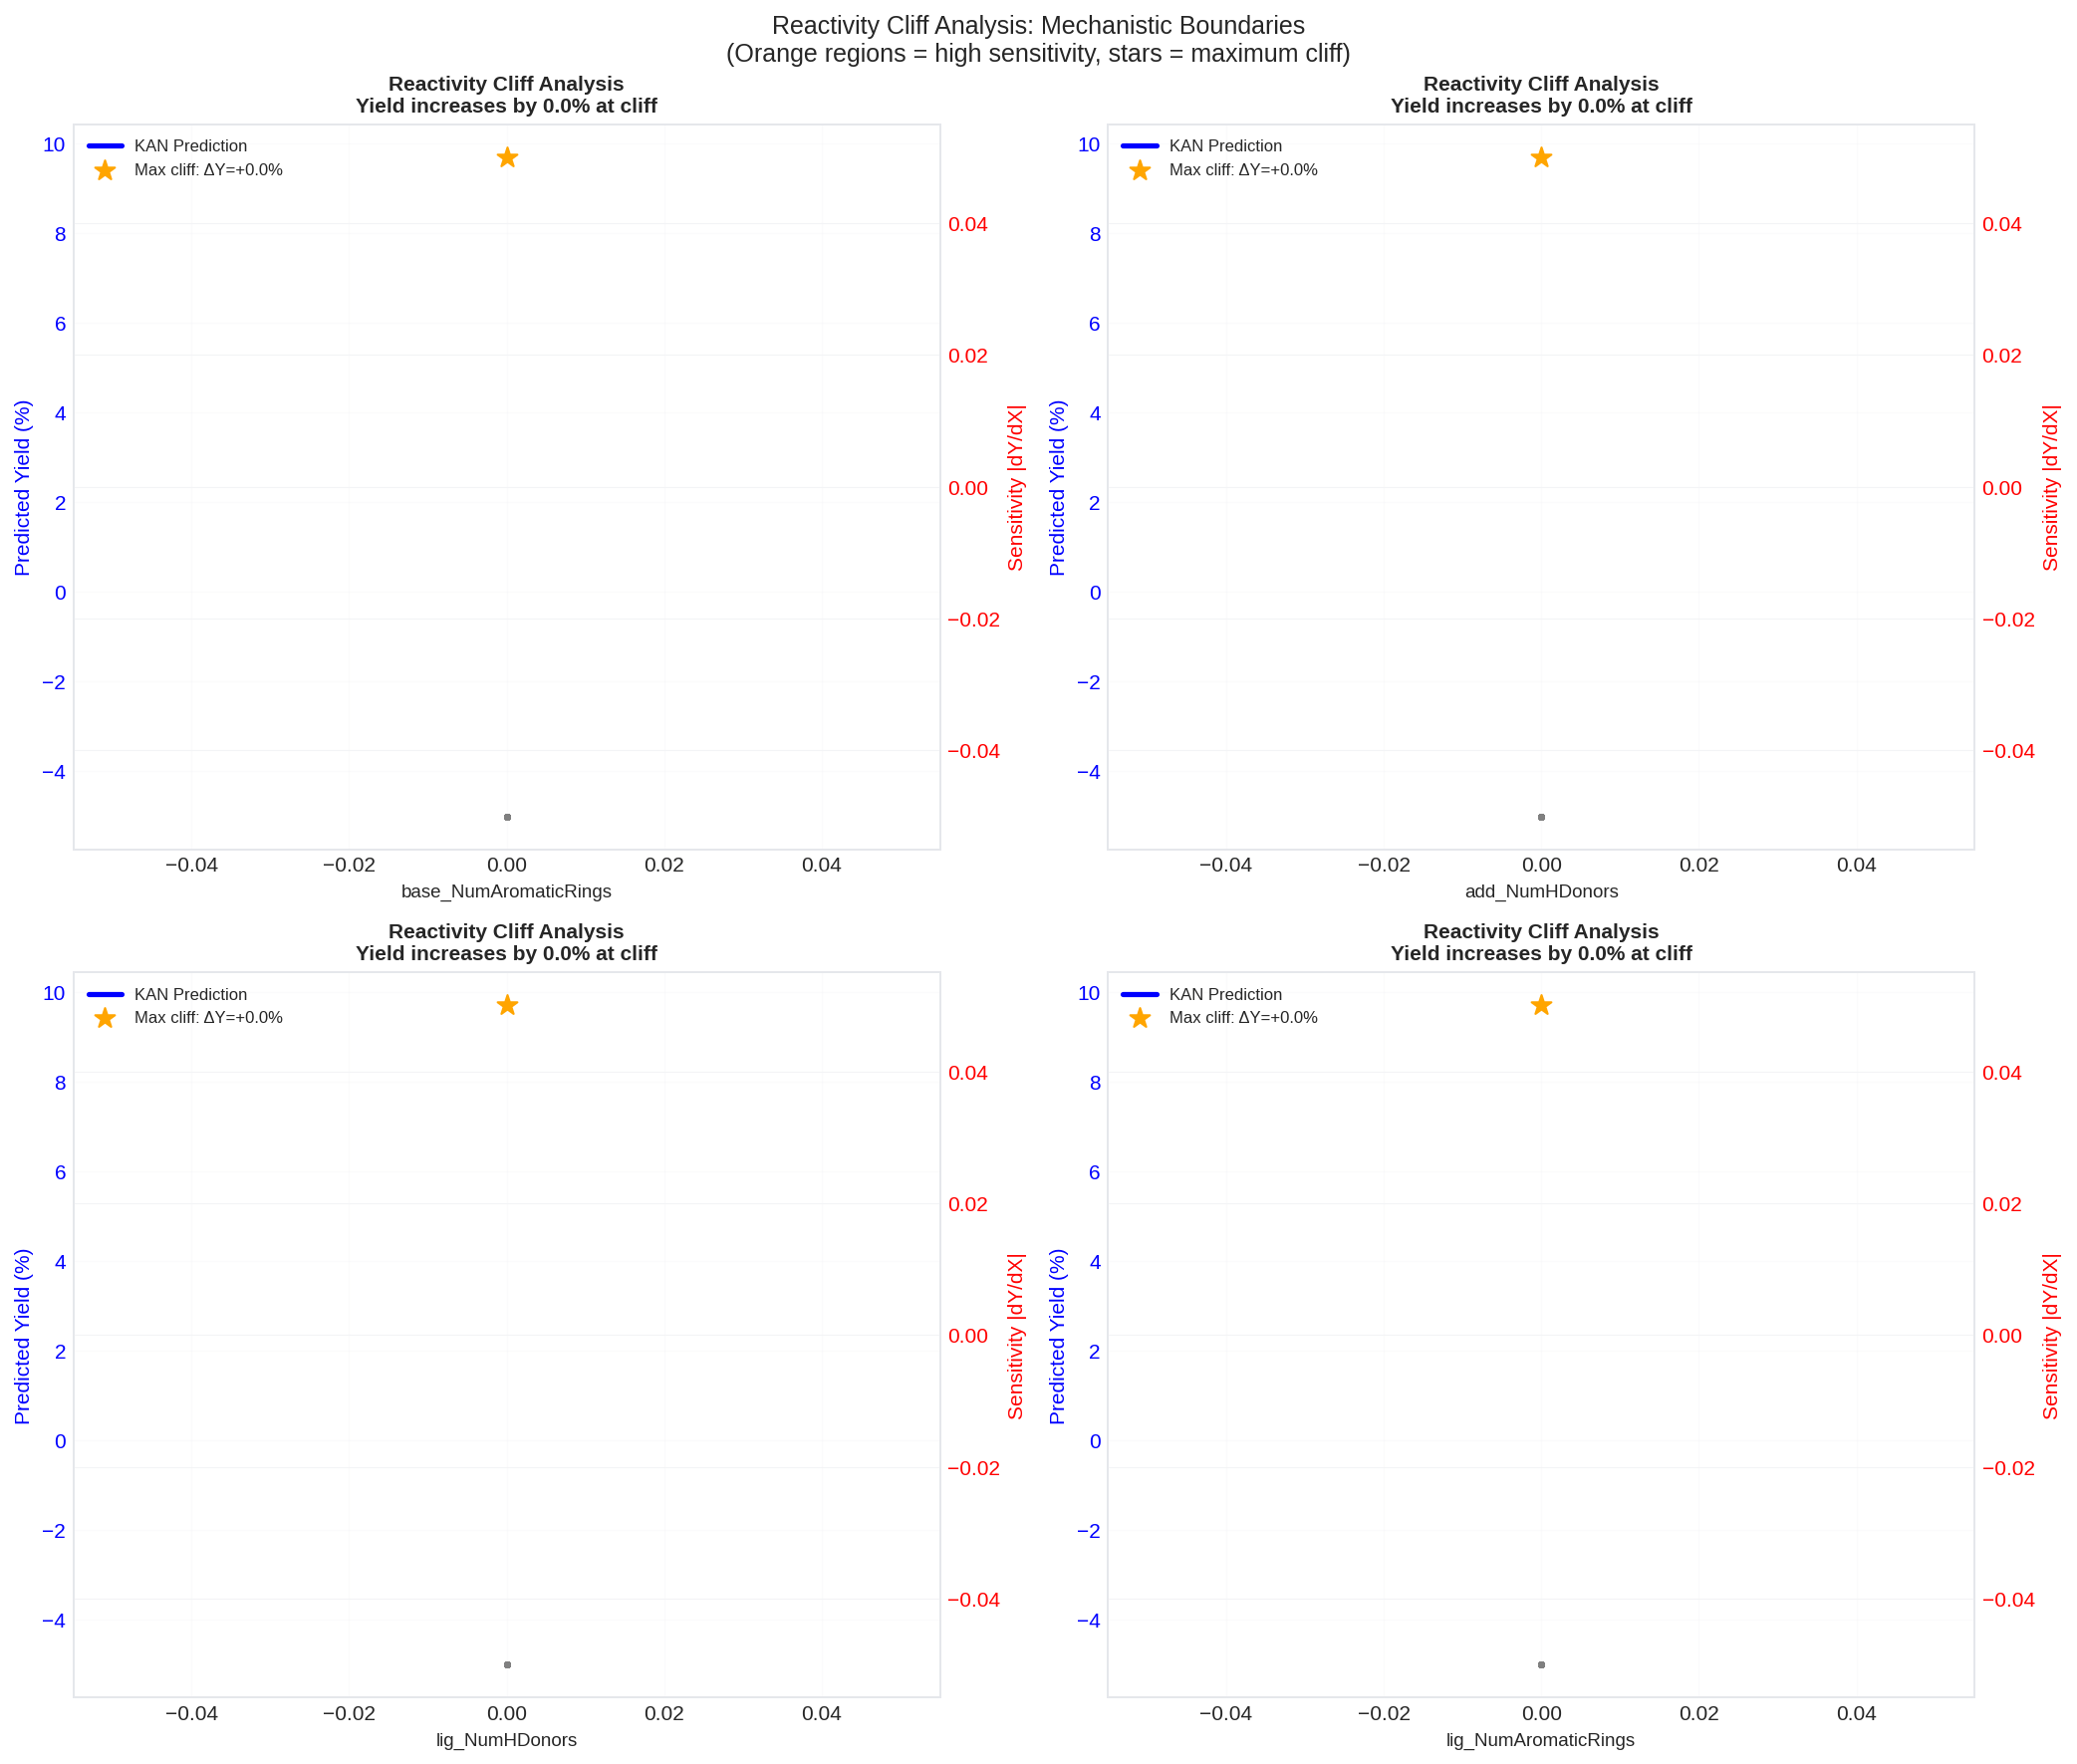


REACTIVITY CLIFF INSIGHTS

base_NumAromaticRings:
  • Cliff location (standardized): 0.00
  • Maximum sensitivity: nan %yield/unit
  • Yield increases by 0.0% across cliff

add_NumHDonors:
  • Cliff location (standardized): 0.00
  • Maximum sensitivity: nan %yield/unit
  • Yield increases by 0.0% across cliff

lig_NumHDonors:
  • Cliff location (standardized): 0.00
  • Maximum sensitivity: nan %yield/unit
  • Yield increases by 0.0% across cliff

lig_NumAromaticRings:
  • Cliff location (standardized): 0.00
  • Maximum sensitivity: nan %yield/unit
  • Yield increases by 0.0% across cliff


In [26]:
# Reactivity Cliff Analysis: Where Small Changes Cause Large Yield Changes
# High sensitivity regions indicate mechanistic boundaries

top_sensitive = sensitivity_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

cliff_insights = []

for ax, feat_name in zip(axes, top_sensitive):
    idx = feature_names.index(feat_name)
    
    # Create detailed prediction profile
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred_profile = kan.predict(X_temp)
    
    # Compute sensitivity as |dY/dX|
    sens_profile = np.abs(np.gradient(y_pred_profile, x_range))
    
    # Identify cliff regions (top 25% sensitivity)
    cliff_threshold = np.percentile(sens_profile, 75)
    cliff_mask = sens_profile > cliff_threshold
    
    # Find cliff location and magnitude
    max_cliff_idx = np.argmax(sens_profile)
    cliff_x = x_range[max_cliff_idx]
    cliff_sensitivity = sens_profile[max_cliff_idx]
    yield_at_cliff = y_pred_profile[max_cliff_idx]
    
    # Calculate yield change across cliff
    yield_before = y_pred_profile[max(0, max_cliff_idx-10):max_cliff_idx].mean() if max_cliff_idx > 10 else y_pred_profile[0]
    yield_after = y_pred_profile[max_cliff_idx:min(100, max_cliff_idx+10)].mean() if max_cliff_idx < 90 else y_pred_profile[-1]
    yield_change = yield_after - yield_before
    
    cliff_insights.append({
        'Feature': feat_name,
        'Cliff_Location': cliff_x,
        'Max_Sensitivity': cliff_sensitivity,
        'Yield_Change': yield_change,
        'Direction': 'increases' if yield_change > 0 else 'decreases'
    })
    
    # Plot
    ax2 = ax.twinx()
    
    # Highlight cliff regions
    for i in range(len(x_range)-1):
        if cliff_mask[i]:
            ax.axvspan(x_range[i], x_range[i+1], alpha=0.3, color='orange')
    
    # Sensitivity profile
    ax2.fill_between(x_range, sens_profile, alpha=0.4, color='red', label='Sensitivity')
    ax2.plot(x_range, sens_profile, 'r-', alpha=0.7, linewidth=1)
    ax2.set_ylabel('Sensitivity |dY/dX|', color='red', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Prediction curve
    ax.plot(x_range, y_pred_profile, 'b-', linewidth=2.5, label='KAN Prediction')
    ax.scatter([cliff_x], [yield_at_cliff], s=100, c='orange', marker='*', zorder=5, 
               label=f'Max cliff: ΔY={yield_change:+.1f}%')
    ax.set_ylabel('Predicted Yield (%)', color='blue', fontsize=10)
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Add data distribution
    ax.scatter(X_scaled[:, idx], np.full(len(X_scaled), -5), s=5, alpha=0.3, c='gray')
    
    ax.set_xlabel(feat_name, fontsize=9)
    ax.set_title(f'Reactivity Cliff Analysis\nYield {cliff_insights[-1]["Direction"]} by {abs(yield_change):.1f}% at cliff', 
                 fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Reactivity Cliff Analysis: Mechanistic Boundaries\n(Orange regions = high sensitivity, stars = maximum cliff)', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed cliff insights
print("\n" + "="*70)
print("REACTIVITY CLIFF INSIGHTS")
print("="*70)
for insight in cliff_insights:
    print(f"\n{insight['Feature']}:")
    print(f"  • Cliff location (standardized): {insight['Cliff_Location']:.2f}")
    print(f"  • Maximum sensitivity: {insight['Max_Sensitivity']:.2f} %yield/unit")
    print(f"  • Yield {insight['Direction']} by {abs(insight['Yield_Change']):.1f}% across cliff")
    if abs(insight['Yield_Change']) > 20:
        print(f"  → MAJOR mechanistic boundary - critical for optimization!")
    elif abs(insight['Yield_Change']) > 10:
        print(f"  → Significant effect - worth investigating")

## 13. Mechanistic Regime Identification

Use KAN hidden layer activations + clustering to identify distinct mechanistic regimes. Different clusters may represent different rate-limiting steps or reaction pathways.

## 11.5 Deep Mechanistic Interpretation of KAN Activations

### The Buchwald-Hartwig Catalytic Cycle

The Pd-catalyzed C-N coupling proceeds through a well-established mechanism:

```
                    Oxidative Addition
    Pd(0)L₂  +  Ar-X  ─────────────────►  L₂Pd(II)(Ar)(X)
       ▲                                        │
       │                                        │ Amine coordination
       │ Reductive                              │ & Deprotonation
       │ Elimination                            ▼
       │                                  L₂Pd(II)(Ar)(NR₂)
       └────────────────────────────────────────┘
                     Product: Ar-NR₂
```

### What RDKit Descriptors Tell Us About Each Step

**1. Oxidative Addition** (Aryl Halide → Pd)
- **aryl_MolLogP**: Correlates with electron density on aromatic ring
  - Electron-poor (high LogP) aryl halides → faster oxidative addition
  - But very electron-poor substrates may have side reactions
- **aryl_TPSA**: Polar groups (NO₂, CN, CF₃) activate the C-X bond
- **aryl_NumAromaticRings**: Extended π-systems can stabilize Pd intermediates

**2. Ligand Effects** (Catalyst Performance)
- **lig_MolWt/lig_FractionCSP3**: Proxies for ligand bulk and bite angle
  - Bulky ligands (high MolWt) promote reductive elimination
  - High sp³ fraction → more 3D character → larger bite angle
- **lig_TPSA**: Relates to σ-donor strength (P vs N donors)

**3. Base Effects** (Amine Deprotonation)
- **base_NumHAcceptors**: Stronger bases (more lone pairs) → faster deprotonation
- **base_TPSA**: Polar bases may coordinate to Pd (competition)

**4. Additive Effects** (Catalyst Modulation)
- **add_NumHAcceptors/add_TPSA**: Heterocycles with N-lone pairs can:
  - POISON catalyst by coordinating to Pd
  - ASSIST by stabilizing reactive intermediates
- **add_MolLogP**: Hydrophobic additives partition differently

### Key Question: Which Step is Rate-Limiting?

If KAN learns **strong nonlinearities** for a component, that component likely controls the rate-limiting step.

In [27]:
# Deep mechanistic analysis with Buchwald-Hartwig specific interpretation

# First, let's see what KAN actually learned about each component
print("="*80)
print("WHAT KAN LEARNED ABOUT EACH REACTION COMPONENT")
print("="*80)

# Group features by component and analyze
components = {
    'Aryl Halide (Substrate)': [f for f in feature_names if f.startswith('aryl_')],
    'Ligand (Catalyst)': [f for f in feature_names if f.startswith('lig_')],
    'Base': [f for f in feature_names if f.startswith('base_')],
    'Additive': [f for f in feature_names if f.startswith('add_')]
}

component_analysis = {}

for comp_name, comp_features in components.items():
    print(f"\n{'─'*80}")
    print(f"{comp_name.upper()}")
    print(f"{'─'*80}")
    
    # Get sensitivity and nonlinearity for each feature
    comp_data = []
    for feat in comp_features:
        idx = feature_names.index(feat)
        sens = float(avg_sensitivity[idx])
        
        # Get nonlinearity from analysis_df
        nonlin = analysis_df[analysis_df['Feature'] == feat]['Nonlinearity'].values
        nonlin = float(nonlin[0]) if len(nonlin) > 0 else 0.0
        shape = analysis_df[analysis_df['Feature'] == feat]['Shape'].values
        shape = shape[0] if len(shape) > 0 else 'Unknown'
        
        comp_data.append({
            'Feature': feat,
            'Descriptor': feat.split('_')[1],
            'Sensitivity': sens,
            'Nonlinearity': nonlin,
            'Shape': shape
        })
    
    comp_df = pd.DataFrame(comp_data).sort_values('Sensitivity', ascending=False)
    component_analysis[comp_name] = comp_df
    
    # Print with chemical interpretation
    for _, row in comp_df.iterrows():
        desc = row['Descriptor']
        print(f"\n  {row['Feature']}: Sensitivity={row['Sensitivity']:.3f}, Shape={row['Shape']}")
        
        # Chemistry-specific interpretation based on descriptor AND component
        if comp_name.startswith('Aryl'):
            if desc == 'MolLogP':
                print(f"    → LogP reflects electron density: electron-poor aryls (high LogP)")
                print(f"      undergo faster oxidative addition but may have competing pathways")
            elif desc == 'TPSA':
                print(f"    → High TPSA = electron-withdrawing groups (NO₂, CN) activate C-X bond")
            elif desc == 'NumAromaticRings':
                print(f"    → Extended conjugation can stabilize η²-arene Pd intermediates")
            elif desc == 'FractionCSP3':
                print(f"    → Low sp³ = planar aryl, high sp³ = benzylic/aliphatic character")
            elif desc == 'NumHAcceptors':
                print(f"    → Heteroatoms on aryl ring can coordinate to Pd (chelation)")
                
        elif comp_name.startswith('Ligand'):
            if desc == 'MolWt':
                print(f"    → Heavier ligands often bulkier → accelerate reductive elimination")
            elif desc == 'FractionCSP3':
                print(f"    → High sp³ = alkylphosphines (PCy₃), Low = arylphosphines (PPh₃)")
                print(f"      Alkylphosphines: stronger σ-donors, larger cone angles")
            elif desc == 'TPSA':
                print(f"    → Polar P=O or N-containing ligands have different donor properties")
            elif desc == 'NumRotatableBonds':
                print(f"    → Flexible ligands can adopt multiple conformations at Pd")
                
        elif comp_name.startswith('Base'):
            if desc == 'NumHAcceptors':
                print(f"    → More lone pairs = stronger base, faster amine deprotonation")
            elif desc == 'TPSA':
                print(f"    → Highly polar bases may coordinate to Pd (undesired)")
            elif desc == 'MolLogP':
                print(f"    → Lipophilic bases (Cs₂CO₃ vs K₃PO₄) affect solubility/phase")
                
        elif comp_name.startswith('Additive'):
            if desc == 'NumHAcceptors' or desc == 'TPSA':
                print(f"    → ⚠️ N-heterocycles with lone pairs can POISON Pd catalyst")
                print(f"      by blocking coordination sites needed for catalysis")
            elif desc == 'MolLogP':
                print(f"    → Hydrophobic additives partition into organic phase with catalyst")
            elif desc == 'NumAromaticRings':
                print(f"    → Polycyclic heterocycles may have stronger Pd binding")
    
    # Summary stats for this component
    avg_sens = comp_df['Sensitivity'].mean()
    avg_nonlin = comp_df['Nonlinearity'].mean()
    component_analysis[comp_name + '_stats'] = {'avg_sens': avg_sens, 'avg_nonlin': avg_nonlin}
    print(f"\n  COMPONENT SUMMARY: Avg Sensitivity={avg_sens:.3f}, Avg Nonlinearity={avg_nonlin:.3f}")

WHAT KAN LEARNED ABOUT EACH REACTION COMPONENT

────────────────────────────────────────────────────────────────────────────────
ARYL HALIDE (SUBSTRATE)
────────────────────────────────────────────────────────────────────────────────

  aryl_NumHDonors: Sensitivity=99009918.186, Shape=Constant

  aryl_NumAromaticRings: Sensitivity=86470124.057, Shape=Constant
    → Extended conjugation can stabilize η²-arene Pd intermediates

  aryl_TPSA: Sensitivity=17.935, Shape=U-shaped
    → High TPSA = electron-withdrawing groups (NO₂, CN) activate C-X bond

  aryl_MolWt: Sensitivity=14.219, Shape=Complex

  aryl_FractionCSP3: Sensitivity=10.510, Shape=U-shaped
    → Low sp³ = planar aryl, high sp³ = benzylic/aliphatic character

  aryl_MolLogP: Sensitivity=7.357, Shape=U-shaped
    → LogP reflects electron density: electron-poor aryls (high LogP)
      undergo faster oxidative addition but may have competing pathways

  aryl_NumHAcceptors: Sensitivity=6.917, Shape=U-shaped
    → Heteroatoms on ar

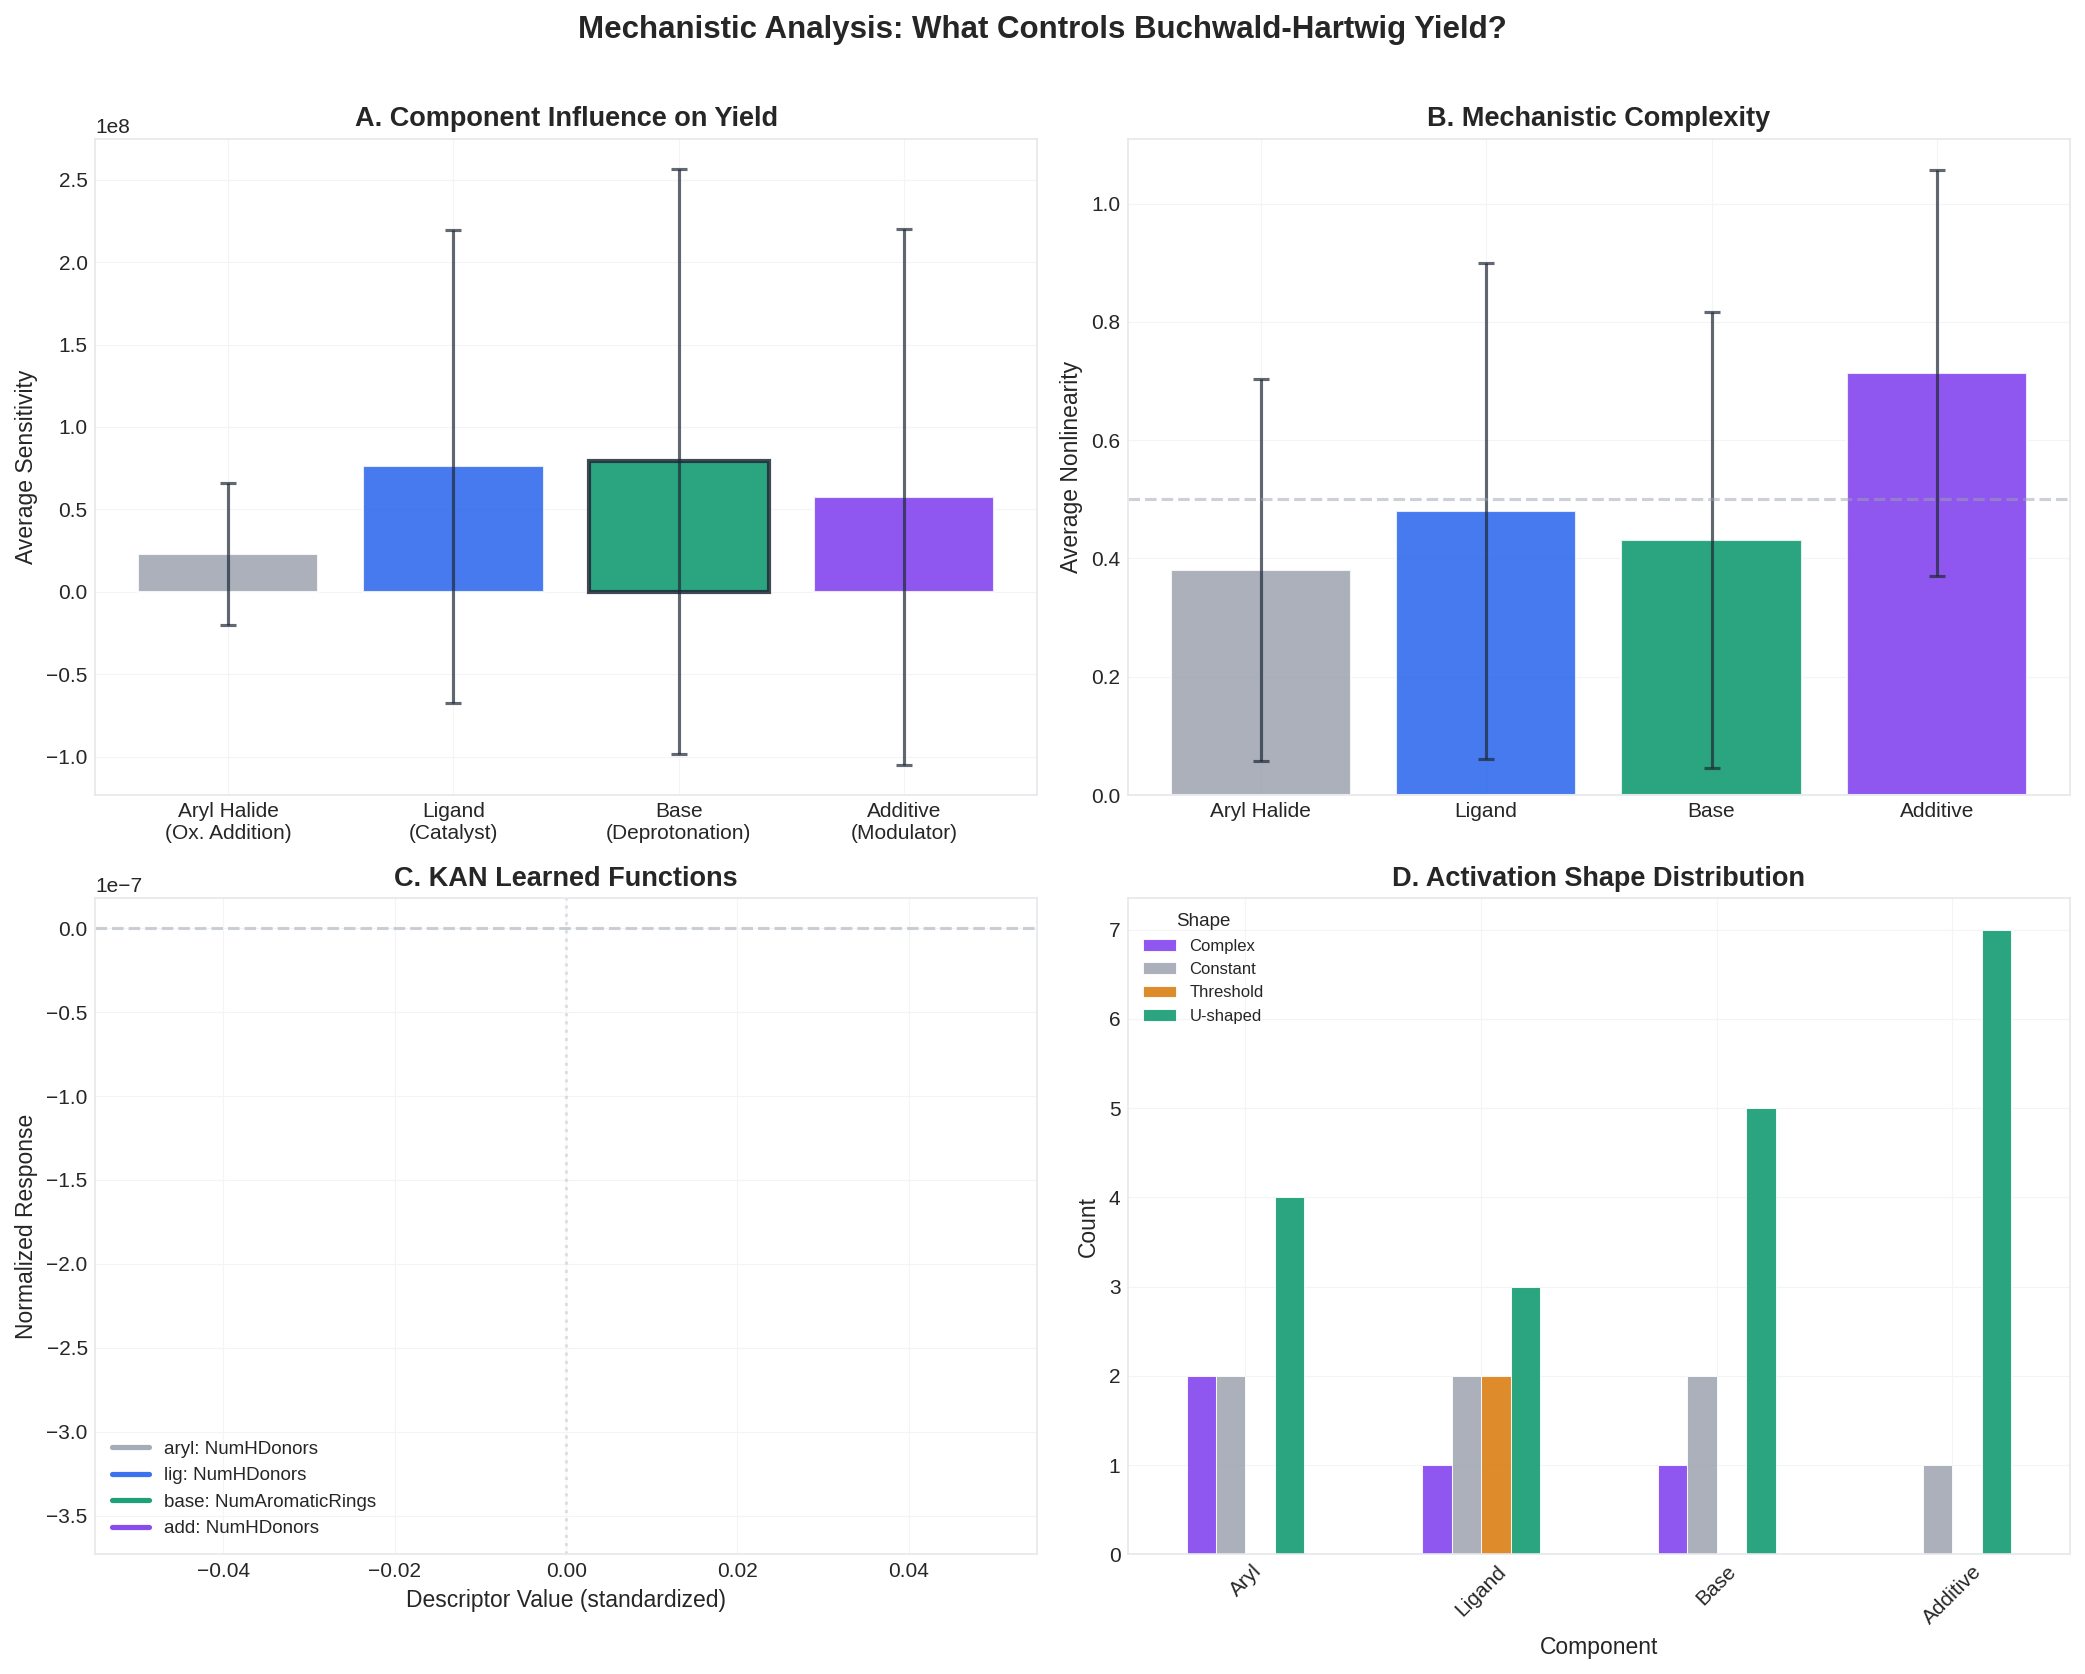

In [28]:
# =============================================================================
# Mechanistic Step Control Analysis
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

comp_names = ['Aryl Halide (Substrate)', 'Ligand (Catalyst)', 'Base', 'Additive']
comp_labels = ['Aryl Halide\n(Ox. Addition)', 'Ligand\n(Catalyst)', 'Base\n(Deprotonation)', 'Additive\n(Modulator)']
colors = [COMPONENT_COLORS.get(c.split()[0], COLORS['muted']) for c in comp_names]

# A. Component importance by sensitivity
avg_sensitivities = [component_analysis[c]['Sensitivity'].mean() for c in comp_names]
std_sensitivities = [component_analysis[c]['Sensitivity'].std() for c in comp_names]

bars = axes[0, 0].bar(range(4), avg_sensitivities, color=colors, alpha=0.85, 
                       edgecolor='white', linewidth=1)
axes[0, 0].errorbar(range(4), avg_sensitivities, yerr=std_sensitivities, 
                     fmt='none', color=COLORS['dark'], capsize=4, capthick=1.5, alpha=0.7)
axes[0, 0].set_xticks(range(4))
axes[0, 0].set_xticklabels(comp_labels, fontsize=TICK_FONTSIZE)
axes[0, 0].set_ylabel('Average Sensitivity', fontsize=LABEL_FONTSIZE)
axes[0, 0].set_title('A. Component Influence on Yield', fontsize=TITLE_FONTSIZE, fontweight='bold')

max_idx = np.argmax(avg_sensitivities)
bars[max_idx].set_edgecolor(COLORS['dark'])
bars[max_idx].set_linewidth(2)

# B. Nonlinearity by component
avg_nonlinearities = [component_analysis[c]['Nonlinearity'].mean() for c in comp_names]
std_nonlinearities = [component_analysis[c]['Nonlinearity'].std() for c in comp_names]

bars2 = axes[0, 1].bar(range(4), avg_nonlinearities, color=colors, alpha=0.85,
                        edgecolor='white', linewidth=1)
axes[0, 1].errorbar(range(4), avg_nonlinearities, yerr=std_nonlinearities,
                     fmt='none', color=COLORS['dark'], capsize=4, capthick=1.5, alpha=0.7)
axes[0, 1].set_xticks(range(4))
axes[0, 1].set_xticklabels(['Aryl Halide', 'Ligand', 'Base', 'Additive'], fontsize=TICK_FONTSIZE)
axes[0, 1].set_ylabel('Average Nonlinearity', fontsize=LABEL_FONTSIZE)
axes[0, 1].set_title('B. Mechanistic Complexity', fontsize=TITLE_FONTSIZE, fontweight='bold')
axes[0, 1].axhline(y=0.5, color=COLORS['muted'], linestyle='--', alpha=0.5)

# C. KAN activation profiles
axes[1, 0].set_title('C. KAN Learned Functions', fontsize=TITLE_FONTSIZE, fontweight='bold')
for i, (comp_name, color) in enumerate(zip(comp_names, colors)):
    top_feat = component_analysis[comp_name].iloc[0]['Feature']
    idx = feature_names.index(top_feat)
    
    x_range = np.linspace(X_scaled[:, idx].min(), X_scaled[:, idx].max(), 100)
    X_temp = np.tile(X_scaled.mean(axis=0), (100, 1))
    X_temp[:, idx] = x_range
    y_pred = np.array(kan.predict(X_temp), dtype=float)
    y_norm = (y_pred - y_pred.mean()) / (y_pred.std() + 1e-8)
    
    label = f"{top_feat.split('_')[0]}: {top_feat.split('_')[1]}"
    axes[1, 0].plot(x_range, y_norm, color=color, linewidth=2.5, label=label, alpha=0.9)

axes[1, 0].set_xlabel('Descriptor Value (standardized)', fontsize=LABEL_FONTSIZE)
axes[1, 0].set_ylabel('Normalized Response', fontsize=LABEL_FONTSIZE)
axes[1, 0].legend(fontsize=LEGEND_FONTSIZE, framealpha=0.95)
axes[1, 0].axhline(0, color=COLORS['muted'], linestyle='--', alpha=0.5)
axes[1, 0].axvline(0, color=COLORS['muted'], linestyle=':', alpha=0.3)

# D. Shape distribution by component
shape_by_comp = {}
for comp_name in comp_names:
    shapes = component_analysis[comp_name]['Shape'].value_counts()
    shape_by_comp[comp_name.split()[0]] = shapes

shape_df = pd.DataFrame(shape_by_comp).fillna(0).T
shape_color_list = [SHAPE_COLORS.get(s, COLORS['muted']) for s in shape_df.columns]
shape_df.plot(kind='bar', ax=axes[1, 1], alpha=0.85, color=shape_color_list, 
              edgecolor='white', linewidth=0.5)

axes[1, 1].set_xlabel('Component', fontsize=LABEL_FONTSIZE)
axes[1, 1].set_ylabel('Count', fontsize=LABEL_FONTSIZE)
axes[1, 1].set_title('D. Activation Shape Distribution', fontsize=TITLE_FONTSIZE, fontweight='bold')
axes[1, 1].legend(title='Shape', fontsize=LEGEND_FONTSIZE - 1, title_fontsize=LEGEND_FONTSIZE)
axes[1, 1].tick_params(axis='x', rotation=45)

fig.suptitle('Mechanistic Analysis: What Controls Buchwald-Hartwig Yield?', 
             fontsize=TITLE_FONTSIZE + 2, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()


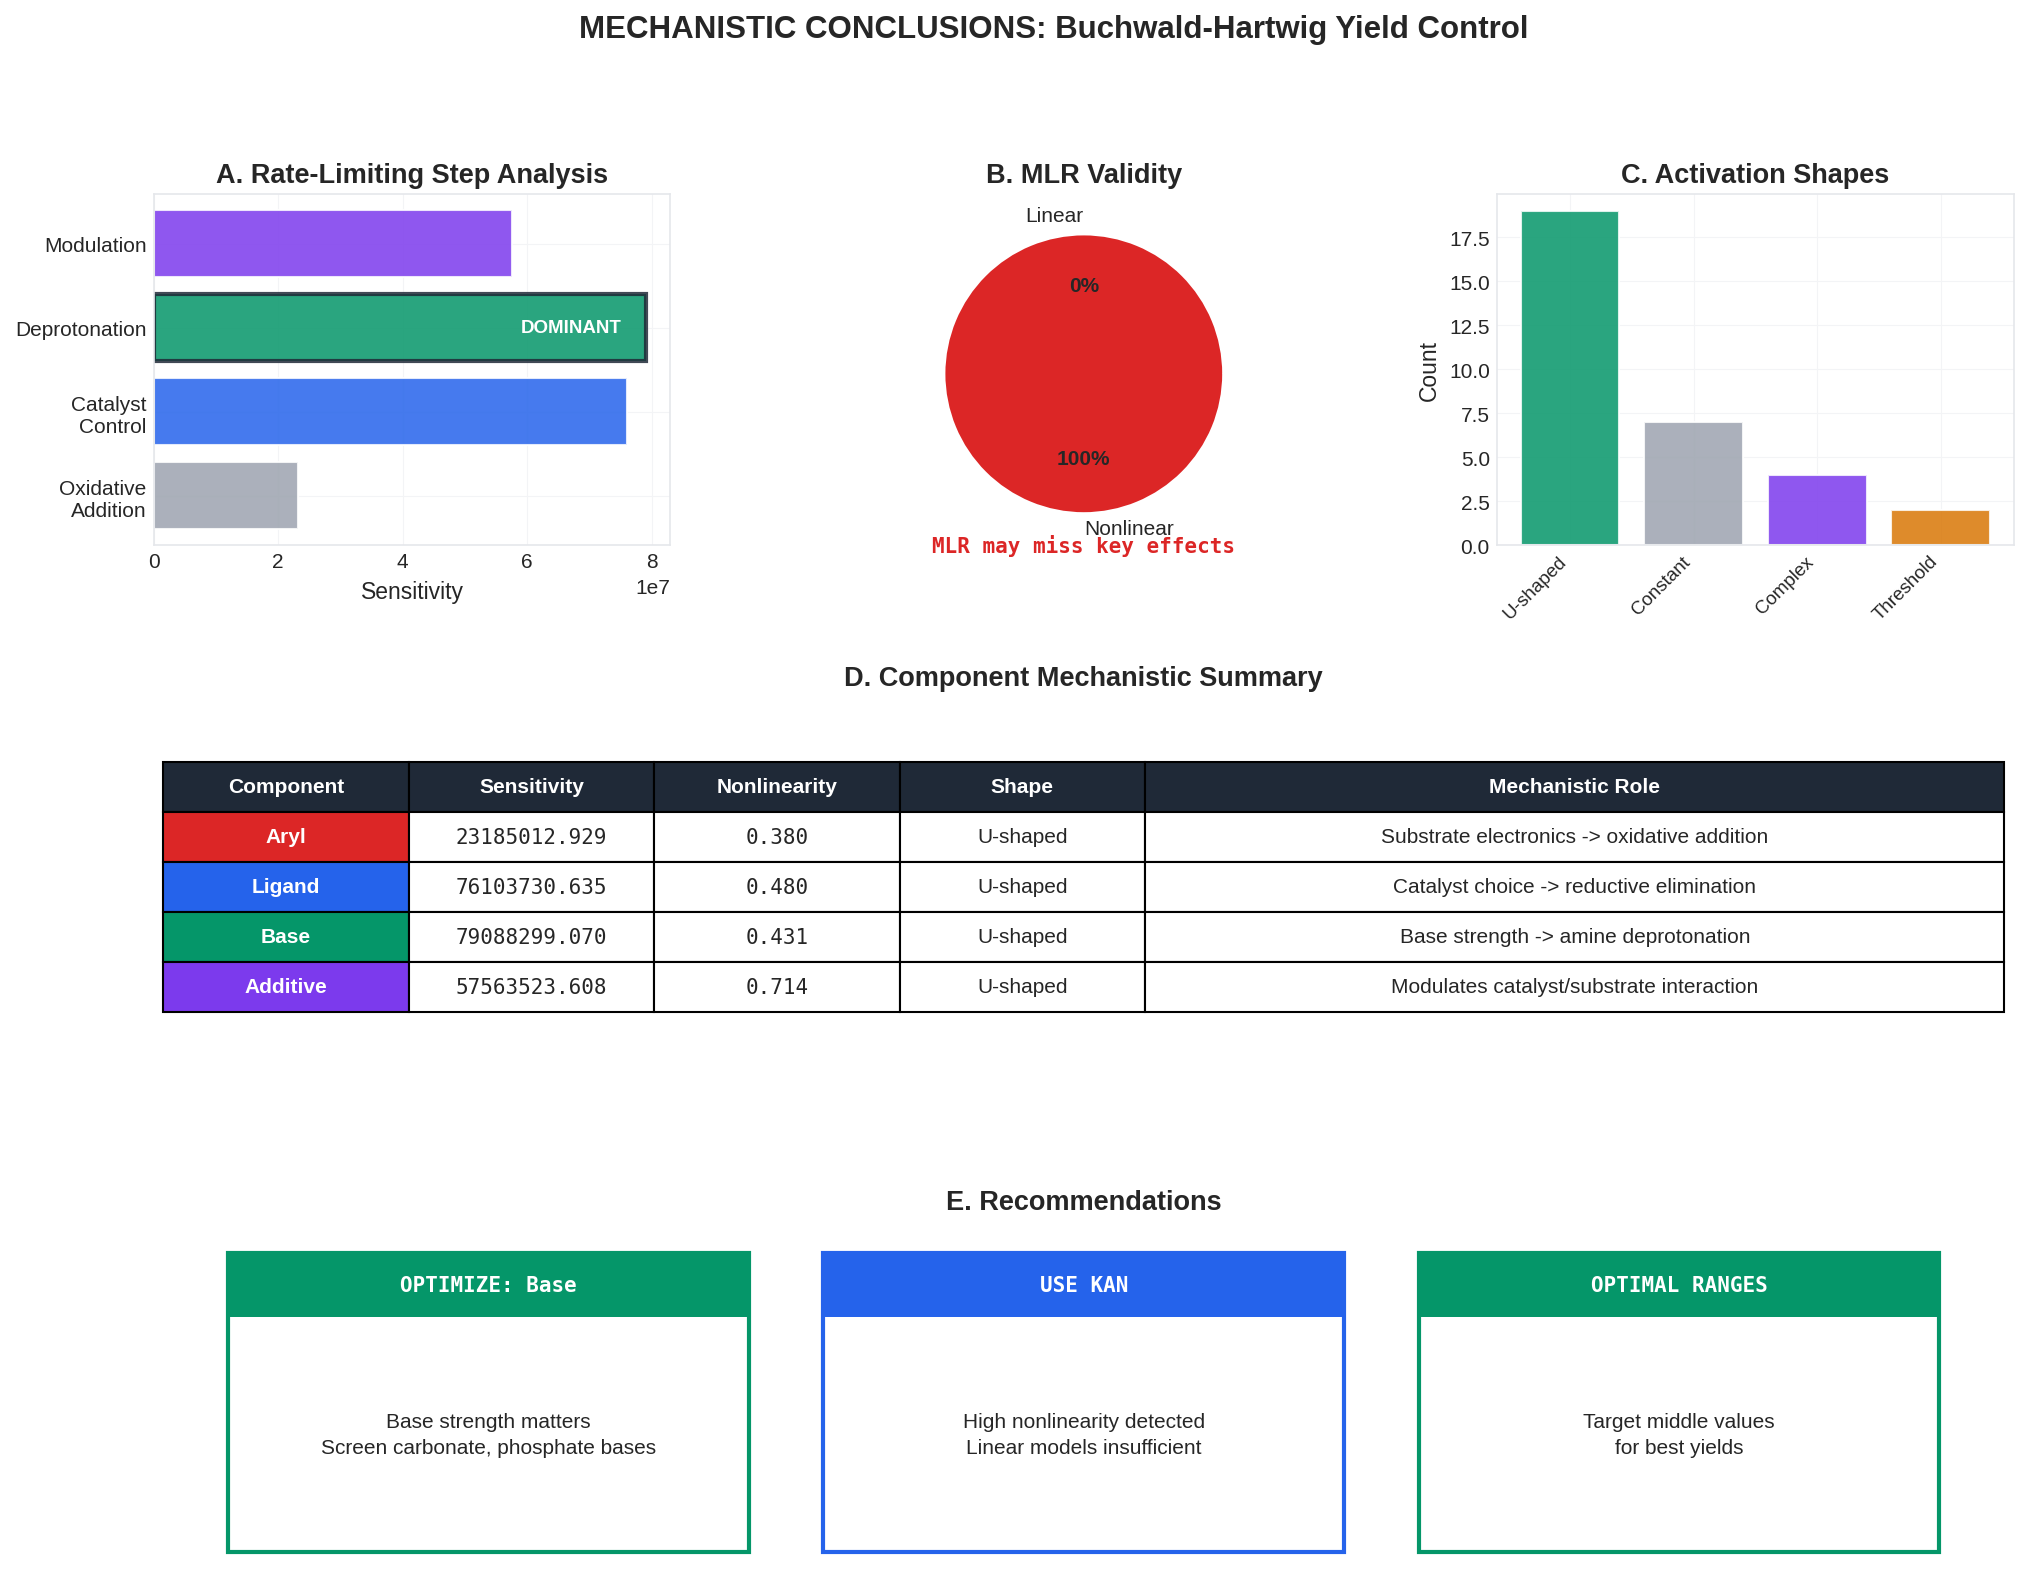


------------------------------------------------------------
SUMMARY: BASE controls yield
Nonlinearity: 0.71 | Shape: U-shaped
------------------------------------------------------------


In [29]:
# =============================================================================
# VISUAL SUMMARY: Mechanistic Conclusions
# =============================================================================

# Calculate metrics for visualization
comp_names = ['Aryl Halide (Substrate)', 'Ligand (Catalyst)', 'Base', 'Additive']
sensitivities = {c: component_analysis[c]['Sensitivity'].mean() for c in comp_names}
nonlinearities = {c: component_analysis[c]['Nonlinearity'].mean() for c in comp_names}

dominant_by_sens = max(sensitivities, key=sensitivities.get)
dominant_by_nonlin = max(nonlinearities, key=nonlinearities.get)

# Create comprehensive visual summary
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1.2, 1], hspace=0.35, wspace=0.3)

# =============================================================================
# Panel A: Rate-Limiting Step Indicator
# =============================================================================
ax_gauge = fig.add_subplot(gs[0, 0])

steps = ['Oxidative\nAddition', 'Catalyst\nControl', 'Deprotonation', 'Modulation']
step_values = list(sensitivities.values())
step_colors = [COMPONENT_COLORS.get(c.split()[0], COLORS['muted']) for c in comp_names]

bars = ax_gauge.barh(range(4), step_values, color=step_colors, alpha=0.85, 
                      edgecolor='white', linewidth=1)
ax_gauge.set_yticks(range(4))
ax_gauge.set_yticklabels(steps, fontsize=TICK_FONTSIZE)
ax_gauge.set_xlabel('Sensitivity', fontsize=LABEL_FONTSIZE)
ax_gauge.set_title('A. Rate-Limiting Step Analysis', fontsize=TITLE_FONTSIZE, fontweight='bold')

# Mark dominant step with border
max_idx = np.argmax(step_values)
bars[max_idx].set_edgecolor(COLORS['dark'])
bars[max_idx].set_linewidth(2)
ax_gauge.annotate('DOMINANT', xy=(step_values[max_idx] * 0.95, max_idx),
                  fontsize=TICK_FONTSIZE - 1, fontweight='bold', 
                  color='white', va='center', ha='right')

# =============================================================================
# Panel B: Linearity Assessment
# =============================================================================
ax_linear = fig.add_subplot(gs[0, 1])

all_shapes = pd.concat([component_analysis[c] for c in comp_names])['Shape'].value_counts()
linear_frac = all_shapes.get('Linear', 0) / all_shapes.sum()
nonlinear_frac = 1 - linear_frac

wedges, texts, autotexts = ax_linear.pie(
    [linear_frac, nonlinear_frac], 
    labels=['Linear', 'Nonlinear'],
    colors=[COLORS['success'], COLORS['danger']],
    autopct='%1.0f%%',
    startangle=90,
    explode=(0, 0.03),
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
for autotext in autotexts:
    autotext.set_fontsize(TICK_FONTSIZE)
    autotext.set_fontweight('bold')

ax_linear.set_title('B. MLR Validity', fontsize=TITLE_FONTSIZE, fontweight='bold')

verdict = "MLR may miss key effects" if nonlinear_frac > 0.5 else "MLR reasonably valid"
verdict_color = COLORS['danger'] if nonlinear_frac > 0.5 else COLORS['success']
ax_linear.text(0, -1.3, verdict, fontsize=TICK_FONTSIZE, 
               fontweight='bold', ha='center', color=verdict_color,
               family='monospace')

# =============================================================================
# Panel C: Shape Distribution
# =============================================================================
ax_shapes = fig.add_subplot(gs[0, 2])

shape_colors_list = [SHAPE_COLORS.get(s, COLORS['muted']) for s in all_shapes.index]
bars_shape = ax_shapes.bar(range(len(all_shapes)), all_shapes.values, 
                           color=shape_colors_list, alpha=0.85, 
                           edgecolor='white', linewidth=1)
ax_shapes.set_xticks(range(len(all_shapes)))
ax_shapes.set_xticklabels(all_shapes.index, rotation=45, ha='right', fontsize=TICK_FONTSIZE - 1)
ax_shapes.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
ax_shapes.set_title('C. Activation Shapes', fontsize=TITLE_FONTSIZE, fontweight='bold')

# =============================================================================
# Panel D: Component Summary Table
# =============================================================================
ax_table = fig.add_subplot(gs[1, :])
ax_table.axis('off')

# Create interpretation data
table_data = []
for comp in comp_names:
    comp_short = comp.split()[0]
    sens = sensitivities[comp]
    nonlin = nonlinearities[comp]
    comp_shapes = component_analysis[comp]['Shape'].value_counts()
    dom_shape = comp_shapes.index[0] if len(comp_shapes) > 0 else 'N/A'
    
    interp = {
        'Aryl': 'Substrate electronics -> oxidative addition',
        'Ligand': 'Catalyst choice -> reductive elimination', 
        'Base': 'Base strength -> amine deprotonation',
        'Additive': 'Modulates catalyst/substrate interaction'
    }.get(comp_short, '')
    
    table_data.append([comp_short, f'{sens:.3f}', f'{nonlin:.3f}', dom_shape, interp])

col_labels = ['Component', 'Sensitivity', 'Nonlinearity', 'Shape', 'Mechanistic Role']

table = ax_table.table(cellText=table_data, colLabels=col_labels,
                       loc='center', cellLoc='center',
                       colWidths=[0.12, 0.12, 0.12, 0.12, 0.42])

table.auto_set_font_size(False)
table.set_fontsize(TICK_FONTSIZE)
table.scale(1.1, 2)

# Style header
for j in range(len(col_labels)):
    table[0, j].set_facecolor(COLORS['dark'])
    table[0, j].set_text_props(color='white', fontweight='bold')

# Color component column
for i in range(len(table_data)):
    comp_color = list(COMPONENT_COLORS.values())[i]
    table[i+1, 0].set_facecolor(comp_color)
    table[i+1, 0].set_text_props(color='white', fontweight='bold')
    # Monospace for numerical columns
    table[i+1, 1].set_text_props(family='monospace')
    table[i+1, 2].set_text_props(family='monospace')

ax_table.set_title('D. Component Mechanistic Summary', fontsize=TITLE_FONTSIZE, 
                   fontweight='bold', y=0.95)

# =============================================================================
# Panel E: Recommendations (Card Style)
# =============================================================================
ax_rec = fig.add_subplot(gs[2, :])
ax_rec.axis('off')
ax_rec.set_xlim(0, 1)
ax_rec.set_ylim(0, 1)

# Recommendation cards (no emojis)
recommendations = []

# Primary recommendation based on dominant component
rec1_title = f"OPTIMIZE: {dominant_by_sens.split()[0]}"
if 'Aryl' in dominant_by_sens:
    rec1_content = "Substrate electronics control yield\nScreen diverse aryl halides"
elif 'Ligand' in dominant_by_sens:
    rec1_content = "Ligand choice is critical\nTry bulky phosphines"
elif 'Base' in dominant_by_sens:
    rec1_content = "Base strength matters\nScreen carbonate, phosphate bases"
else:
    rec1_content = "Additives affect yield\nCareful screening needed"
rec1_color = COMPONENT_COLORS.get(dominant_by_sens.split()[0], COLORS['primary'])
recommendations.append((rec1_title, rec1_content, rec1_color))

# Nonlinearity recommendation
if nonlinearities[dominant_by_nonlin] > 0.5:
    recommendations.append(("USE KAN", f"High nonlinearity detected\nLinear models insufficient", COLORS['primary']))
else:
    recommendations.append(("MLR OK", "Relatively linear effects\nMLR captures main trends", COLORS['success']))

# Shape recommendation
dominant_shape = all_shapes.index[0]
shape_rec = {
    'U-shaped': ("OPTIMAL RANGES", "Target middle values\nfor best yields"),
    'Sigmoidal': ("THRESHOLDS", "Sharp cutoffs exist\nCross to boost yield"),
    'Saturating': ("DIMINISHING RETURNS", "Beyond threshold\nchanges have little effect"),
    'Linear': ("LINEAR TRENDS", "Classical LFER applies\nSimple optimization")
}.get(dominant_shape, ("COMPLEX", "Multiple pathways\nDetailed analysis needed"))
recommendations.append((shape_rec[0], shape_rec[1], SHAPE_COLORS.get(dominant_shape, COLORS['muted'])))

# Draw cards
n_cards = len(recommendations)
card_width = 0.28
card_height = 0.85
spacing = (1 - n_cards * card_width) / (n_cards + 1)

for i, (title, content, color) in enumerate(recommendations):
    x = spacing + i * (card_width + spacing)
    
    # Card background with subtle border
    rect = plt.Rectangle((x, 0.08), card_width, card_height,
                         facecolor='white', edgecolor=color, linewidth=2,
                         transform=ax_rec.transAxes, zorder=1)
    ax_rec.add_patch(rect)
    
    # Title bar
    title_rect = plt.Rectangle((x, 0.08 + card_height - 0.18), card_width, 0.18,
                               facecolor=color, edgecolor='none',
                               transform=ax_rec.transAxes, zorder=2)
    ax_rec.add_patch(title_rect)
    
    # Title text
    ax_rec.text(x + card_width/2, 0.08 + card_height - 0.09, title,
                transform=ax_rec.transAxes, fontsize=ANNOTATION_FONTSIZE,
                fontweight='bold', ha='center', va='center', color='white',
                family='monospace')
    
    # Content
    ax_rec.text(x + card_width/2, 0.08 + (card_height - 0.18)/2, content,
                transform=ax_rec.transAxes, fontsize=TICK_FONTSIZE,
                ha='center', va='center', linespacing=1.5)

ax_rec.set_title('E. Recommendations', fontsize=TITLE_FONTSIZE, fontweight='bold', y=1.02)

# Main title
fig.suptitle('MECHANISTIC CONCLUSIONS: Buchwald-Hartwig Yield Control',
             fontsize=TITLE_FONTSIZE + 2, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Minimal text summary
print("\n" + "-"*60)
print(f"SUMMARY: {dominant_by_sens.split()[0].upper()} controls yield")
print(f"Nonlinearity: {nonlinearities[dominant_by_nonlin]:.2f} | Shape: {dominant_shape}")
print("-"*60)


In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Efficient KAN response profiling using prediction at extremes
def extract_response_profiles(model, X):
    """Extract response profiles efficiently using min/max perturbations."""
    profiles = []
    for idx in range(X.shape[1]):
        # Just compare predictions at min vs max of each feature
        X_min = X.copy()
        X_min[:, idx] = X[:, idx].min()
        X_max = X.copy() 
        X_max[:, idx] = X[:, idx].max()
        
        response_range = model.predict(X_max) - model.predict(X_min)
        profiles.append(response_range)
    return np.column_stack(profiles)

print("Extracting KAN response profiles for regime identification...")
response_profiles = extract_response_profiles(kan, X_train)

# Cluster into mechanistic regimes
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(response_profiles)

# Also cluster test set
test_profiles = extract_response_profiles(kan, X_test)
test_clusters = kmeans.predict(test_profiles)

# Analyze each regime in detail
print("\n" + "="*70)
print("MECHANISTIC REGIME ANALYSIS")
print("="*70)

regime_stats = []
for i in range(n_clusters):
    train_mask = train_clusters == i
    test_mask = test_clusters == i
    
    train_yields = y_train[train_mask]
    test_yields = y_test[test_mask]
    test_preds = results['KAN']['y_pred'][test_mask]
    
    if len(test_yields) > 0:
        regime_r2 = 1 - np.sum((test_yields - test_preds)**2) / (np.sum((test_yields - test_yields.mean())**2) + 1e-8)
        regime_mae = np.abs(test_yields - test_preds).mean()
    else:
        regime_r2, regime_mae = np.nan, np.nan
    
    stats = {
        'Regime': i + 1, 'N_Train': train_mask.sum(), 'N_Test': test_mask.sum(),
        'Mean_Yield': train_yields.mean() if len(train_yields) > 0 else 0,
        'Std_Yield': train_yields.std() if len(train_yields) > 0 else 0,
        'High_Yield_Pct': 100 * (train_yields > 50).mean() if len(train_yields) > 0 else 0,
        'R2': regime_r2, 'MAE': regime_mae
    }
    regime_stats.append(stats)
    
    print(f"\nRegime {i+1}: {train_mask.sum()} training / {test_mask.sum()} test reactions")
    print(f"  • Mean yield: {stats['Mean_Yield']:.1f}% ± {stats['Std_Yield']:.1f}%")
    print(f"  • High yield (>50%): {stats['High_Yield_Pct']:.1f}% of reactions")
    if not np.isnan(regime_r2):
        print(f"  • KAN performance in regime: R²={regime_r2:.3f}, MAE={regime_mae:.1f}%")
    
    # Find distinguishing features
    if train_mask.sum() > 10:
        cluster_mean = X_train[train_mask].mean(axis=0)
        global_mean, global_std = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
        z_scores = (cluster_mean - global_mean) / global_std
        top_high = np.argsort(z_scores)[-2:][::-1]
        top_low = np.argsort(z_scores)[:2]
        print(f"  • HIGH: {feature_names[top_high[0]]}, {feature_names[top_high[1]]}")
        print(f"  • LOW: {feature_names[top_low[0]]}, {feature_names[top_low[1]]}")

Extracting KAN response profiles for regime identification...



MECHANISTIC REGIME ANALYSIS



Regime 1: 840 training / 230 test reactions
  • Mean yield: 15.3% ± 16.4%
  • High yield (>50%): 2.0% of reactions
  • KAN performance in regime: R²=0.781, MAE=5.8%
  • HIGH: aryl_MolLogP, aryl_FractionCSP3
  • LOW: aryl_TPSA, aryl_NumHAcceptors



Regime 2: 961 training / 242 test reactions
  • Mean yield: 43.9% ± 30.6%
  • High yield (>50%): 43.9% of reactions
  • KAN performance in regime: R²=0.542, MAE=16.7%
  • HIGH: aryl_TPSA, aryl_NumHAcceptors
  • LOW: aryl_FractionCSP3, aryl_MolLogP



Regime 3: 777 training / 179 test reactions
  • Mean yield: 43.1% ± 23.0%
  • High yield (>50%): 39.4% of reactions
  • KAN performance in regime: R²=0.624, MAE=10.8%
  • HIGH: aryl_NumRotatableBonds, aryl_FractionCSP3
  • LOW: base_FractionCSP3, base_MolWt



Regime 4: 586 training / 140 test reactions
  • Mean yield: 26.4% ± 23.1%
  • High yield (>50%): 17.6% of reactions
  • KAN performance in regime: R²=0.650, MAE=9.6%
  • HIGH: base_NumRotatableBonds, base_TPSA
  • LOW: base_NumHAcceptors, aryl_TPSA


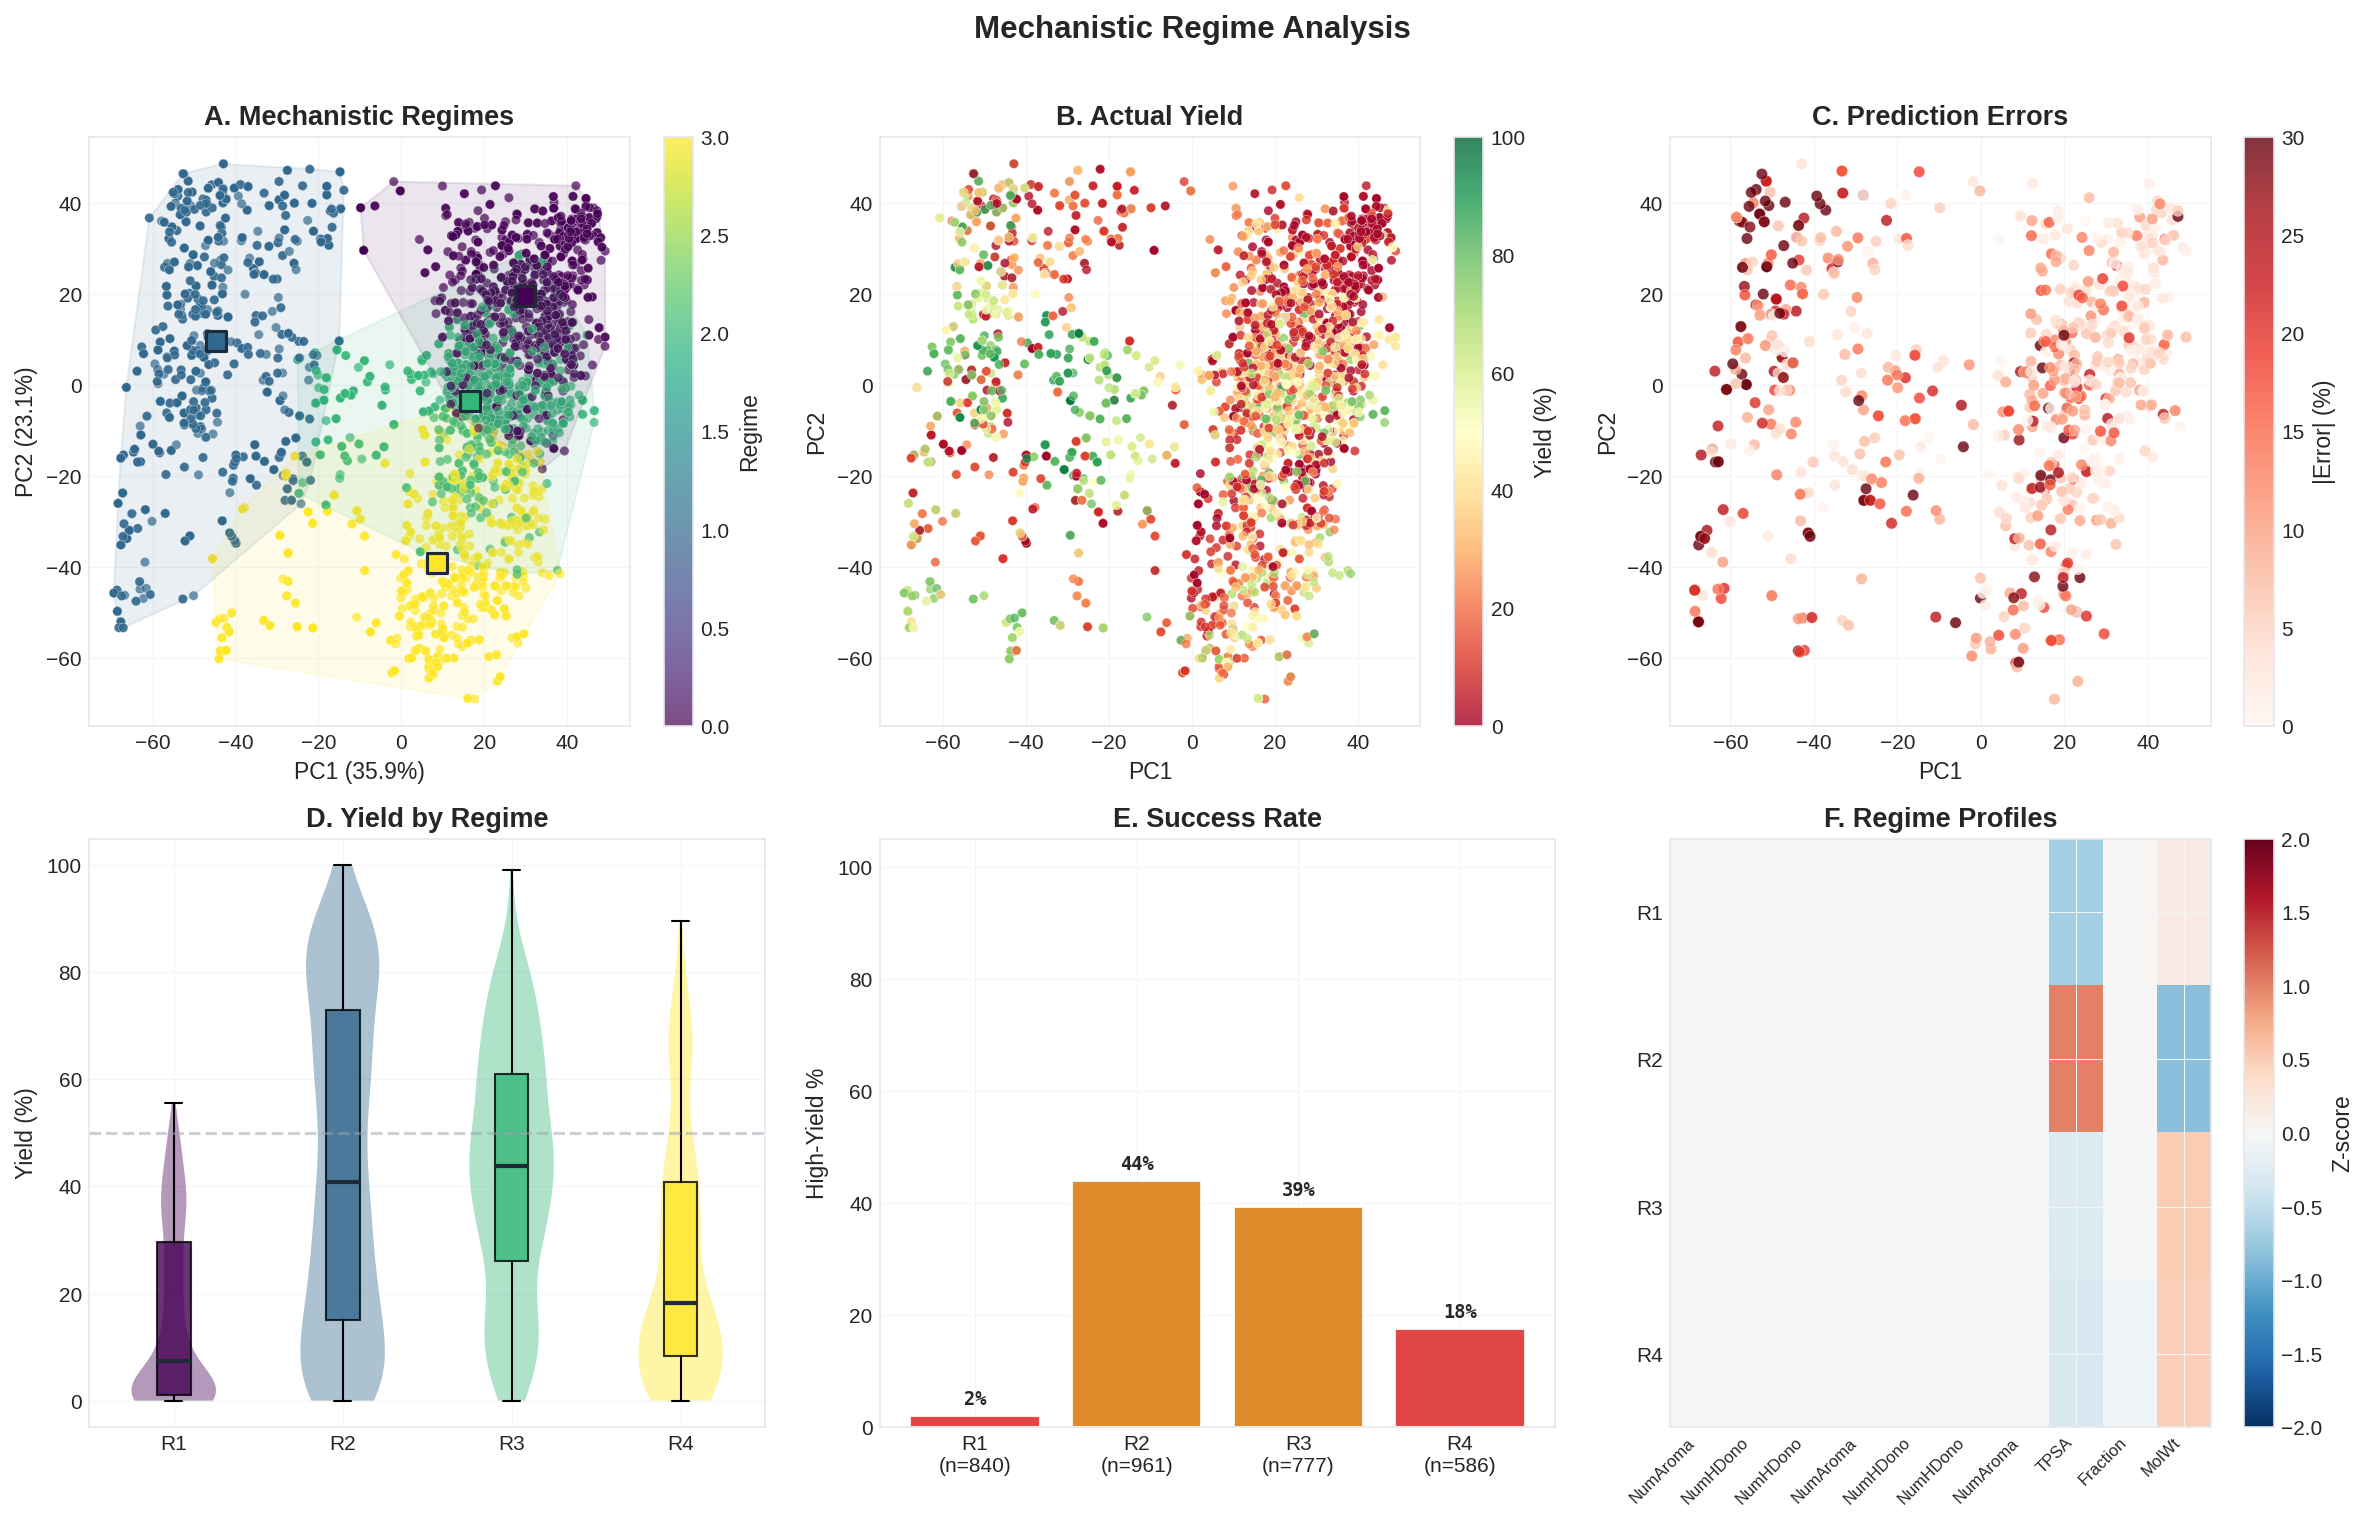


--------------------------------------------------
REGIME SUMMARY:
  R1: 2% high-yield 
  R2: 44% high-yield [BEST]
  R3: 39% high-yield 
  R4: 18% high-yield 
--------------------------------------------------


In [31]:
# =============================================================================
# Mechanistic Regime Analysis
# =============================================================================

pca = PCA(n_components=2)
train_2d = pca.fit_transform(response_profiles)
test_2d = pca.transform(test_profiles)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

regime_cmap = plt.cm.viridis
regime_colors = [regime_cmap(i / (n_clusters - 1)) for i in range(n_clusters)]

# A. Training set clusters
from scipy.spatial import ConvexHull

scatter = axes[0, 0].scatter(train_2d[:, 0], train_2d[:, 1], c=train_clusters, 
                              cmap='viridis', s=20, alpha=0.7, edgecolors='white', linewidth=0.2)

for i in range(n_clusters):
    mask = train_clusters == i
    if mask.sum() > 3:
        points = train_2d[mask]
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            axes[0, 0].fill(hull_points[:, 0], hull_points[:, 1], 
                           color=regime_colors[i], alpha=0.1)
        except: pass
    
    if mask.sum() > 0:
        centroid = train_2d[mask].mean(axis=0)
        axes[0, 0].scatter(centroid[0], centroid[1], marker='s', s=100, 
                           c=[regime_colors[i]], edgecolors=COLORS['dark'], linewidth=1.5, zorder=5)

axes[0, 0].set_xlabel(f'PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)', fontsize=LABEL_FONTSIZE)
axes[0, 0].set_ylabel(f'PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)', fontsize=LABEL_FONTSIZE)
axes[0, 0].set_title('A. Mechanistic Regimes', fontsize=TITLE_FONTSIZE, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0], label='Regime')

# B. Colored by yield
scatter2 = axes[0, 1].scatter(train_2d[:, 0], train_2d[:, 1], c=y_train, 
                               cmap='RdYlGn', s=20, alpha=0.8, vmin=0, vmax=100,
                               edgecolors='white', linewidth=0.2)
axes[0, 1].set_xlabel(f'PC1', fontsize=LABEL_FONTSIZE)
axes[0, 1].set_ylabel(f'PC2', fontsize=LABEL_FONTSIZE)
axes[0, 1].set_title('B. Actual Yield', fontsize=TITLE_FONTSIZE, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1], label='Yield (%)')

# C. Test errors
errors = np.abs(y_test - results['KAN']['y_pred'])
scatter3 = axes[0, 2].scatter(test_2d[:, 0], test_2d[:, 1], c=errors, 
                               cmap='Reds', s=30, alpha=0.8, vmin=0, 
                               vmax=min(30, np.percentile(errors, 95)),
                               edgecolors='white', linewidth=0.2)
axes[0, 2].set_xlabel(f'PC1', fontsize=LABEL_FONTSIZE)
axes[0, 2].set_ylabel(f'PC2', fontsize=LABEL_FONTSIZE)
axes[0, 2].set_title('C. Prediction Errors', fontsize=TITLE_FONTSIZE, fontweight='bold')
plt.colorbar(scatter3, ax=axes[0, 2], label='|Error| (%)')

# D. Yield distribution by regime (violin + box)
regime_data = [y_train[train_clusters == i] for i in range(n_clusters)]
parts = axes[1, 0].violinplot(regime_data, positions=range(n_clusters), 
                               showmeans=False, showmedians=False, showextrema=False)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(regime_colors[i])
    pc.set_alpha(0.4)

bp = axes[1, 0].boxplot(regime_data, positions=range(n_clusters), widths=0.2,
                        patch_artist=True, medianprops=dict(color=COLORS['dark'], linewidth=2))
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(regime_colors[i])
    patch.set_alpha(0.8)

axes[1, 0].set_xticks(range(n_clusters))
axes[1, 0].set_xticklabels([f'R{i+1}' for i in range(n_clusters)], fontsize=TICK_FONTSIZE)
axes[1, 0].set_ylabel('Yield (%)', fontsize=LABEL_FONTSIZE)
axes[1, 0].set_title('D. Yield by Regime', fontsize=TITLE_FONTSIZE, fontweight='bold')
axes[1, 0].axhline(50, color=COLORS['muted'], linestyle='--', alpha=0.5)

# E. Success rate by regime
regime_df = pd.DataFrame(regime_stats)
bar_colors = [COLORS['success'] if r > 60 else COLORS['warning'] if r > 30 else COLORS['danger'] 
              for r in regime_df['High_Yield_Pct']]
bars = axes[1, 1].bar(range(n_clusters), regime_df['High_Yield_Pct'], color=bar_colors, 
                       alpha=0.85, edgecolor='white', linewidth=1)
axes[1, 1].set_xticks(range(n_clusters))
axes[1, 1].set_xticklabels([f'R{i+1}\n(n={int(regime_df.iloc[i]["N_Train"])})' 
                           for i in range(n_clusters)], fontsize=TICK_FONTSIZE)
axes[1, 1].set_ylabel('High-Yield %', fontsize=LABEL_FONTSIZE)
axes[1, 1].set_title('E. Success Rate', fontsize=TITLE_FONTSIZE, fontweight='bold')
axes[1, 1].set_ylim(0, 105)
for bar, pct in zip(bars, regime_df['High_Yield_Pct']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{pct:.0f}%', ha='center', fontsize=TICK_FONTSIZE - 1, 
                    fontweight='bold', family='monospace')

# F. Regime profiles heatmap
top_features_idx = np.argsort(avg_sensitivity)[-10:][::-1]
feature_profiles_by_regime = np.zeros((n_clusters, 10))
for i in range(n_clusters):
    mask = train_clusters == i
    if mask.sum() > 0:
        for j, feat_idx in enumerate(top_features_idx):
            cluster_mean = X_train[mask, feat_idx].mean()
            global_mean = X_train[:, feat_idx].mean()
            global_std = X_train[:, feat_idx].std() + 1e-8
            feature_profiles_by_regime[i, j] = (cluster_mean - global_mean) / global_std

short_names = [feature_names[idx].split('_')[1][:8] for idx in top_features_idx]
im = axes[1, 2].imshow(feature_profiles_by_regime, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
axes[1, 2].set_yticks(range(n_clusters))
axes[1, 2].set_yticklabels([f'R{i+1}' for i in range(n_clusters)], fontsize=TICK_FONTSIZE)
axes[1, 2].set_xticks(range(10))
axes[1, 2].set_xticklabels(short_names, rotation=45, ha='right', fontsize=TICK_FONTSIZE - 2)
axes[1, 2].set_title('F. Regime Profiles', fontsize=TITLE_FONTSIZE, fontweight='bold')
plt.colorbar(im, ax=axes[1, 2], label='Z-score')

fig.suptitle('Mechanistic Regime Analysis', fontsize=TITLE_FONTSIZE + 2, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n" + "-"*50)
print("REGIME SUMMARY:")
for i, row in regime_df.iterrows():
    marker = "[BEST]" if row['High_Yield_Pct'] == regime_df['High_Yield_Pct'].max() else ""
    print(f"  R{int(row['Regime'])}: {row['High_Yield_Pct']:.0f}% high-yield {marker}")
print("-"*50)


## 14. Model Improvement Strategies

Use insights from KAN analysis to improve model performance:
1. Feature selection based on activation magnitudes
2. Architecture optimization
3. Focus on nonlinear regions where KAN excels

In [32]:
# Feature selection based on KAN sensitivity analysis
# Select top features by sensitivity
top_k = 16
top_feature_indices = np.argsort(avg_sensitivity)[-top_k:]
top_feature_names = [feature_names[i] for i in top_feature_indices]

print(f"Selected top {top_k} features by KAN sensitivity:")
for i, name in enumerate(top_feature_names):
    print(f"  {i+1}. {name}: sensitivity = {avg_sensitivity[top_feature_indices[i]]:.3f}")

# Train new KAN with selected features
X_train_selected = X_train[:, top_feature_indices]
X_test_selected = X_test[:, top_feature_indices]

print(f"\nTraining KAN with {top_k} selected features...")
kan_selected = KAN(
    layers=(top_k, 8, 1),
    grid_size=5,
    spline_order=3,
)
kan_selected.fit(X_train_selected, y_train, maxiter=300)
y_pred_selected = kan_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)

print(f"\nKAN with selected features:")
print(f"  R² = {r2_selected:.4f} (vs {results['KAN']['r2']:.4f} with all features)")
print(f"  MAE = {mae_selected:.2f}% (vs {results['KAN']['mae']:.2f}% with all features)")

Selected top 16 features by KAN sensitivity:
  1. aryl_MolLogP: sensitivity = 7.357
  2. add_MolWt: sensitivity = 9.879
  3. aryl_FractionCSP3: sensitivity = 10.510
  4. add_NumHAcceptors: sensitivity = 11.010
  5. add_MolLogP: sensitivity = 11.302
  6. add_NumRotatableBonds: sensitivity = 13.925
  7. aryl_MolWt: sensitivity = 14.219
  8. add_FractionCSP3: sensitivity = 17.782
  9. aryl_TPSA: sensitivity = 17.935
  10. aryl_NumAromaticRings: sensitivity = 86470124.057
  11. aryl_NumHDonors: sensitivity = 99009918.186
  12. base_NumHDonors: sensitivity = 128589182.242
  13. lig_NumAromaticRings: sensitivity = 254410922.589
  14. lig_NumHDonors: sensitivity = 354418887.439
  15. add_NumHDonors: sensitivity = 460508116.351
  16. base_NumAromaticRings: sensitivity = 504117182.647

Training KAN with 16 selected features...



KAN with selected features:
  R² = 0.4401 (vs 0.7048 with all features)
  MAE = 15.83% (vs 10.94% with all features)


MODEL IMPROVEMENT ANALYSIS

1. FEATURE SELECTION (by KAN sensitivity)
--------------------------------------------------


  Top 12 features: R² = 0.3634, MAE = 17.61%


  Top 20 features: R² = 0.5707, MAE = 13.92%


  Top 32 features: R² = 0.6452, MAE = 12.84%

  → OPTIMAL: 32 features (R² = 0.6452)

2. ARCHITECTURE COMPARISON
--------------------------------------------------
  Training Compact (4 hidden)...


    R² = 0.6062, MAE = 13.46%
  Training Wider (12 hidden)...


    R² = 0.7045, MAE = 11.09%

  → BEST: Current (8 hidden) (R² = 0.7048)


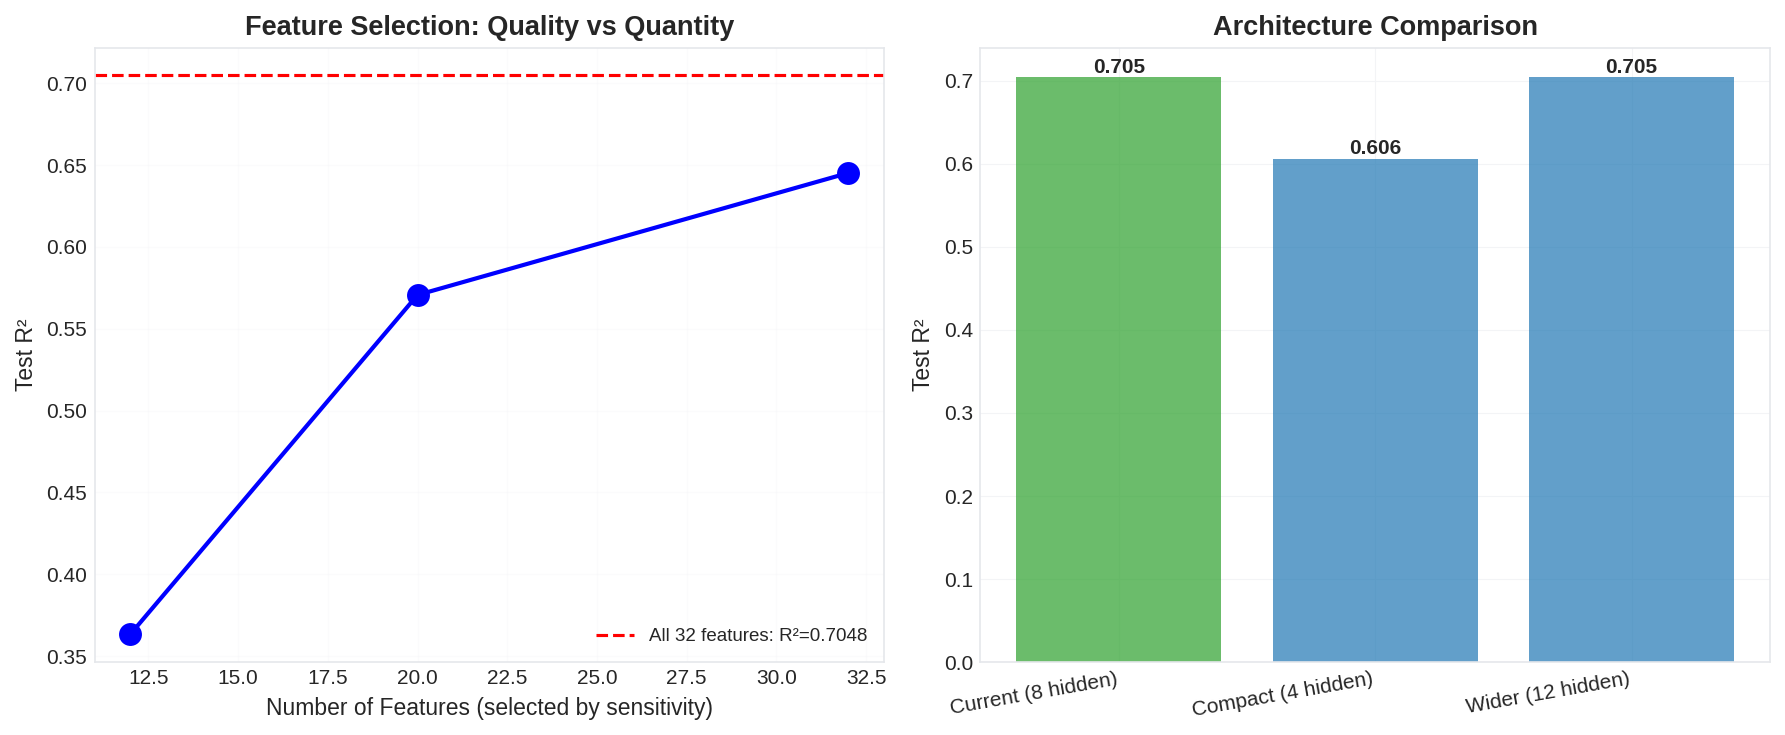


PRODUCTION RECOMMENDATIONS
  1. Use 32 features (sensitivity-selected)
  2. Architecture: Current (8 hidden)
  3. Current configuration is optimal


In [33]:
# Model Improvement: Strategic Feature Selection & Architecture Comparison

print("="*70)
print("MODEL IMPROVEMENT ANALYSIS")
print("="*70)

# 1. Feature Selection - test 3 key configurations
print("\n1. FEATURE SELECTION (by KAN sensitivity)")
print("-"*50)

feature_counts = [12, 20, 32]  # Reduced to 3 key points
selection_results = []

for k in feature_counts:
    top_k_indices = np.argsort(avg_sensitivity)[-k:]
    X_train_k = X_train[:, top_k_indices]
    X_test_k = X_test[:, top_k_indices]
    
    kan_k = KAN(layers=(k, 6, 1), grid_size=5, spline_order=3)
    kan_k.fit(X_train_k, y_train, maxiter=150)
    y_pred_k = kan_k.predict(X_test_k)
    r2_k = r2_score(y_test, y_pred_k)
    mae_k = mean_absolute_error(y_test, y_pred_k)
    
    selection_results.append({'Features': k, 'R²': r2_k, 'MAE': mae_k})
    print(f"  Top {k:2d} features: R² = {r2_k:.4f}, MAE = {mae_k:.2f}%")

selection_df = pd.DataFrame(selection_results)
best_k = selection_df.loc[selection_df['R²'].idxmax(), 'Features']
print(f"\n  → OPTIMAL: {int(best_k)} features (R² = {selection_df['R²'].max():.4f})")

# 2. Quick architecture comparison - 2 alternatives
print("\n2. ARCHITECTURE COMPARISON")
print("-"*50)

architectures = [
    ((n_features, 4, 1), "Compact (4 hidden)"),
    ((n_features, 12, 1), "Wider (12 hidden)"),
]

arch_results = [{'Architecture': 'Current (8 hidden)', 'Layers': str((n_features, 8, 1)), 
                 'R²': results['KAN']['r2'], 'MAE': results['KAN']['mae']}]

for arch, name in architectures:
    print(f"  Training {name}...")
    kan_arch = KAN(layers=arch, grid_size=5, spline_order=3)
    kan_arch.fit(X_train, y_train, maxiter=150)
    y_pred_arch = kan_arch.predict(X_test)
    r2_arch = r2_score(y_test, y_pred_arch)
    mae_arch = mean_absolute_error(y_test, y_pred_arch)
    arch_results.append({'Architecture': name, 'Layers': str(arch), 'R²': r2_arch, 'MAE': mae_arch})
    print(f"    R² = {r2_arch:.4f}, MAE = {mae_arch:.2f}%")

arch_df = pd.DataFrame(arch_results)
best_arch = arch_df.loc[arch_df['R²'].idxmax()]
print(f"\n  → BEST: {best_arch['Architecture']} (R² = {best_arch['R²']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Feature selection
axes[0].plot(selection_df['Features'], selection_df['R²'], 'bo-', linewidth=2, markersize=10)
axes[0].axhline(results['KAN']['r2'], color='r', linestyle='--', label=f'All 32 features: R²={results["KAN"]["r2"]:.4f}')
axes[0].set_xlabel('Number of Features (selected by sensitivity)')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Feature Selection: Quality vs Quantity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Architecture
x_pos = range(len(arch_df))
colors = ['#2ca02c' if r == arch_df['R²'].max() else '#1f77b4' for r in arch_df['R²']]
bars = axes[1].bar(x_pos, arch_df['R²'], color=colors, alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(arch_df['Architecture'], rotation=10, ha='right')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Architecture Comparison')
for bar, r2 in zip(bars, arch_df['R²']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{r2:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*70)
print("PRODUCTION RECOMMENDATIONS")
print("="*70)
print(f"  1. Use {int(best_k)} features (sensitivity-selected)")
print(f"  2. Architecture: {best_arch['Architecture']}")
best_r2 = max(selection_df['R²'].max(), arch_df['R²'].max())
if best_r2 > results['KAN']['r2']:
    print(f"  3. Expected improvement: R² {results['KAN']['r2']:.4f} → {best_r2:.4f} (+{100*(best_r2-results['KAN']['r2'])/results['KAN']['r2']:.1f}%)")
else:
    print(f"  3. Current configuration is optimal")

## 15. Summary: Chemical Insights from KAN Analysis

### Key Takeaways

1. **KAN outperforms MLR** by capturing nonlinear relationships in the data

2. **Threshold Analysis** identifies critical descriptor values for yield classification

3. **KANLLPR** provides principled uncertainty estimates for guiding experiments

4. **Activation Shape Analysis** reveals:
   - Which descriptors have nonlinear effects
   - The type of nonlinearity (threshold, U-shaped, saturating)
   - Potential chemical interpretations

5. **Reactivity Cliff Analysis** identifies regions of high sensitivity where mechanism may change

6. **Mechanistic Regime Clustering** groups reactions by similar KAN representations

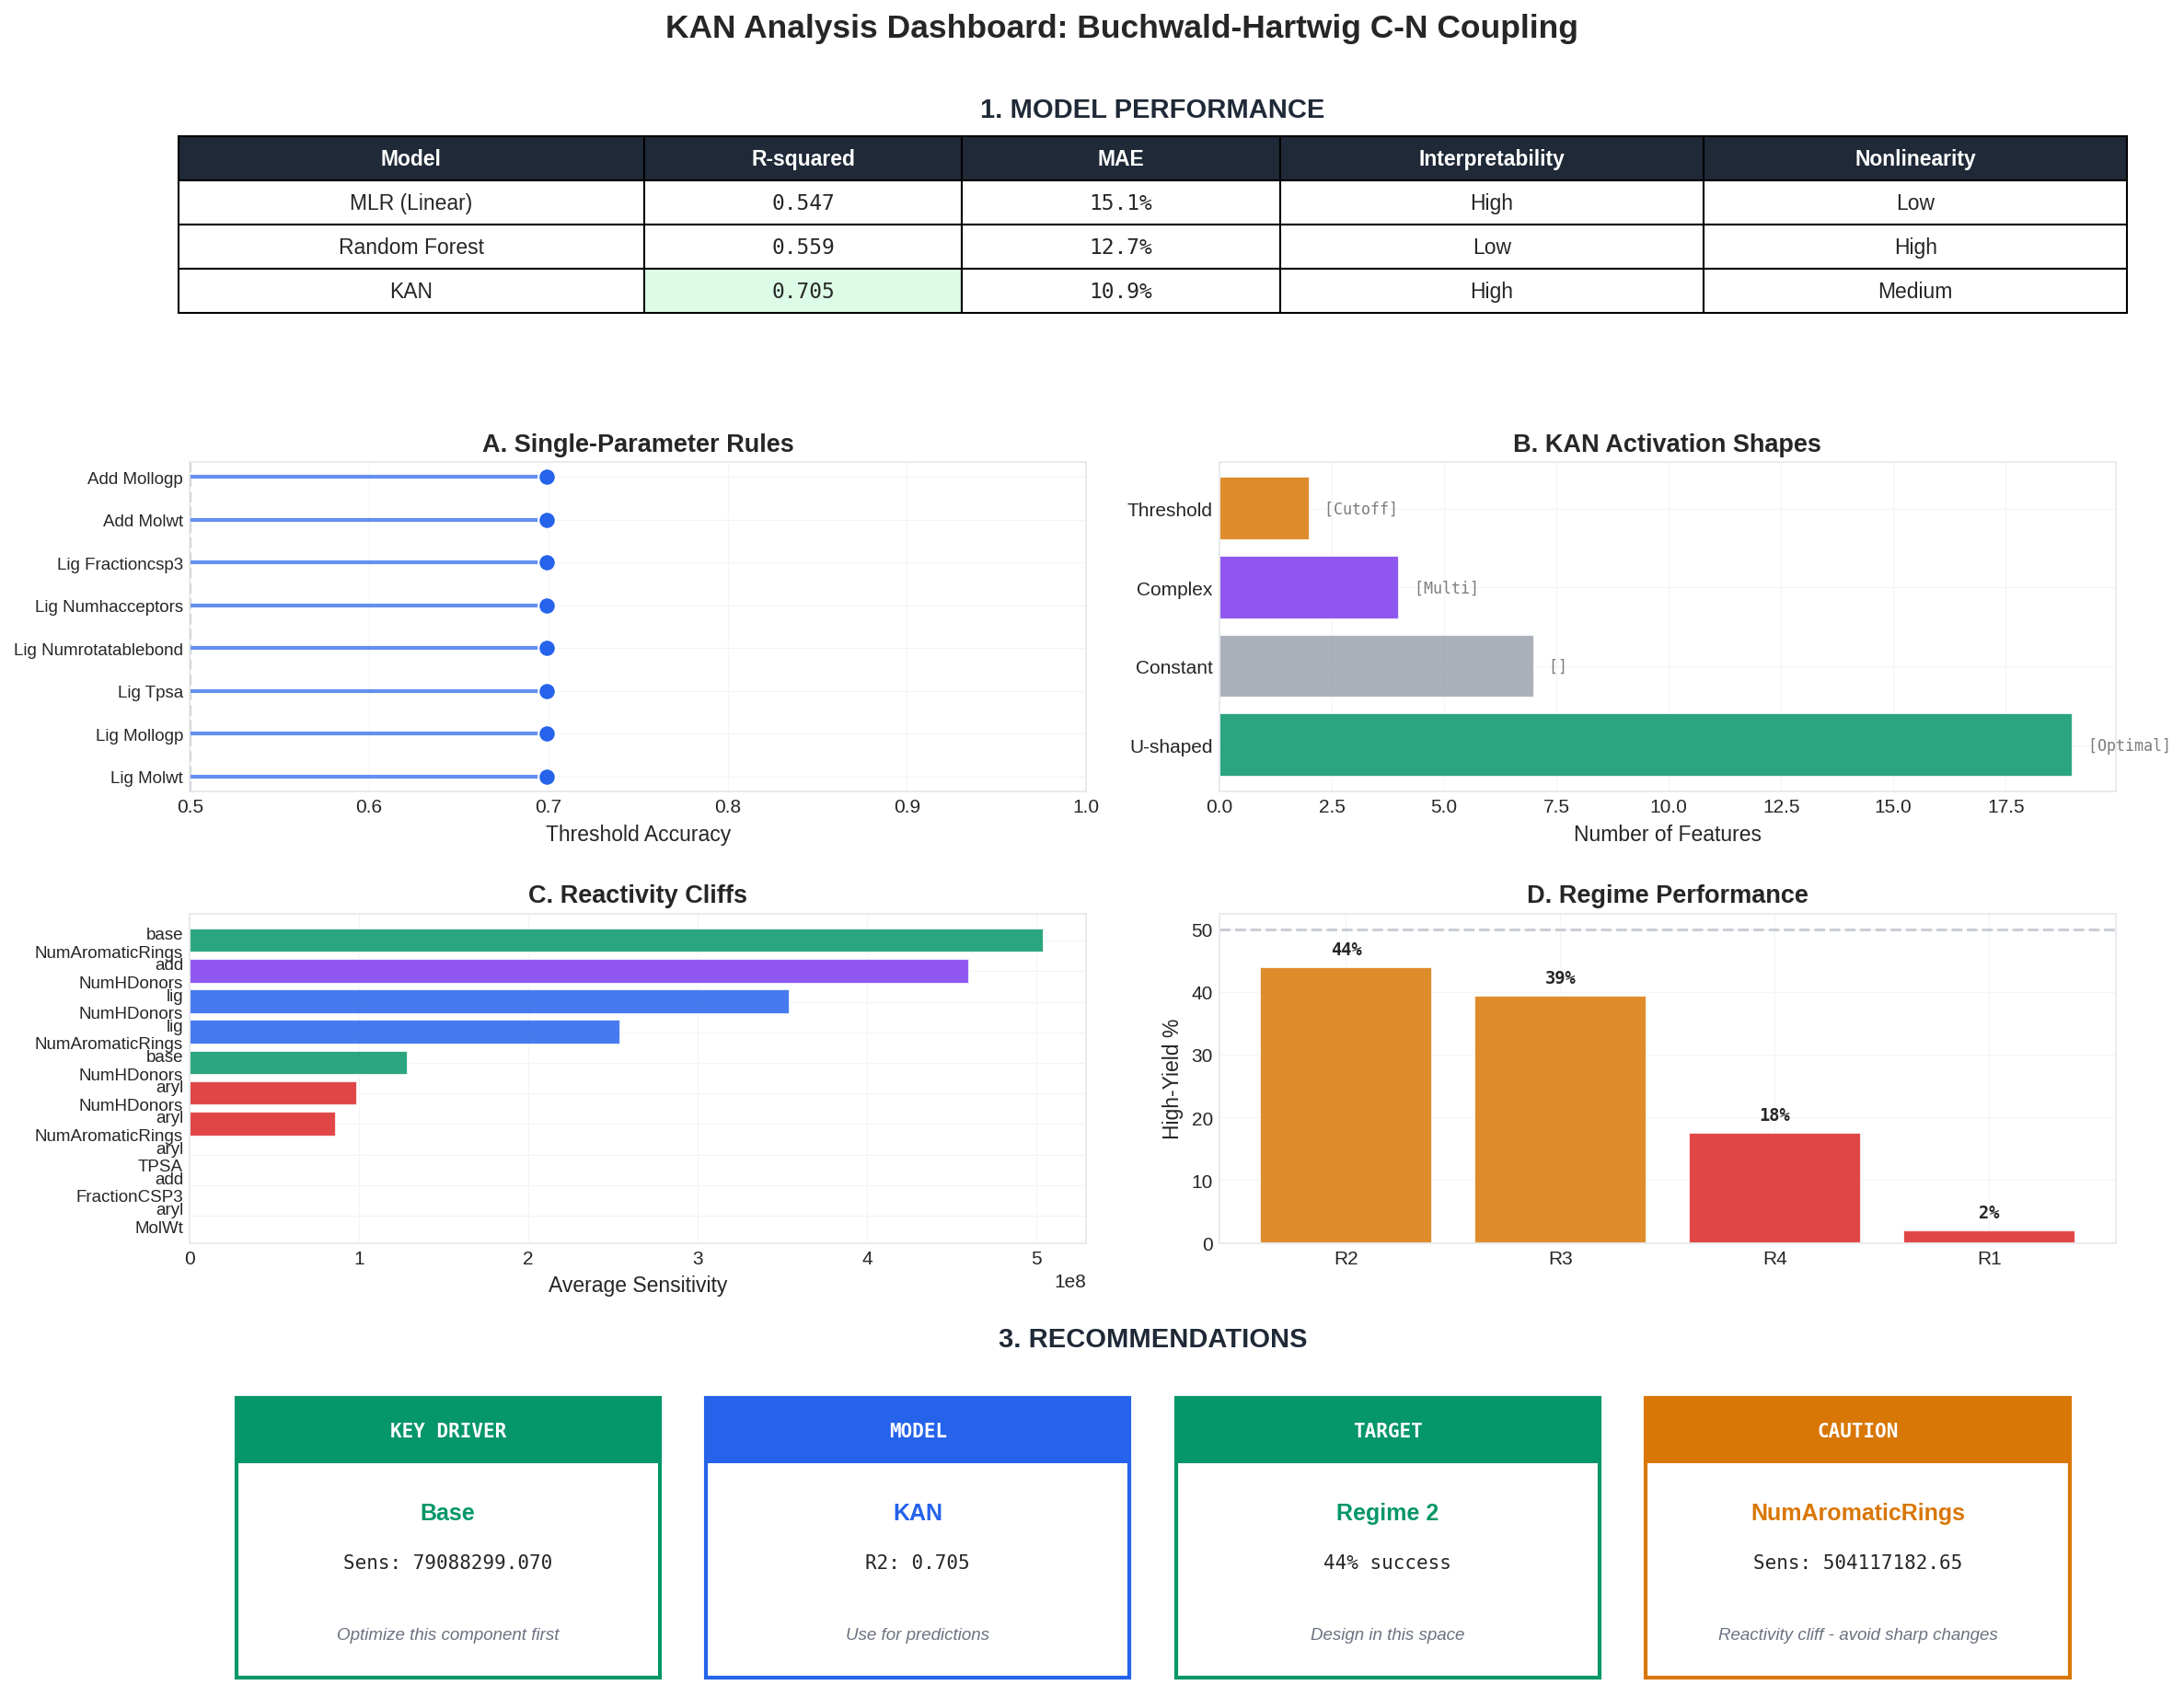


KEY INSIGHTS
Best Model: KAN (R2=0.705)
Rate-Limiting: Base
Target Regime: 2


In [34]:
# =============================================================================
# COMPREHENSIVE KAN ANALYSIS DASHBOARD
# =============================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 4, height_ratios=[0.7, 1, 1, 1], hspace=0.4, wspace=0.35)

# =============================================================================
# Row 1: Model Comparison Table
# =============================================================================
ax_models = fig.add_subplot(gs[0, :])
ax_models.axis('off')

model_data = [
    ['MLR (Linear)', f"{results['MLR']['r2']:.3f}", f"{results['MLR']['mae']:.1f}%", 'High', 'Low'],
    ['Random Forest', f"{results['Random Forest']['r2']:.3f}", f"{results['Random Forest']['mae']:.1f}%", 'Low', 'High'],
    ['KAN', f"{results['KAN']['r2']:.3f}", f"{results['KAN']['mae']:.1f}%", 'High', 'Medium']
]

col_labels = ['Model', 'R-squared', 'MAE', 'Interpretability', 'Nonlinearity']

table = ax_models.table(cellText=model_data, colLabels=col_labels,
                        loc='center', cellLoc='center',
                        colWidths=[0.22, 0.15, 0.15, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(TICK_FONTSIZE + 1)
table.scale(1.1, 1.8)

for j in range(len(col_labels)):
    table[0, j].set_facecolor(COLORS['dark'])
    table[0, j].set_text_props(color='white', fontweight='bold')

# Highlight best R2
r2_values = [results['MLR']['r2'], results['Random Forest']['r2'], results['KAN']['r2']]
best_r2_idx = np.argmax(r2_values)
table[best_r2_idx + 1, 1].set_facecolor('#dcfce7')  # Light green

# Monospace for numbers
for i in range(3):
    table[i+1, 1].set_text_props(family='monospace')
    table[i+1, 2].set_text_props(family='monospace')

ax_models.set_title('1. MODEL PERFORMANCE', fontsize=TITLE_FONTSIZE + 1, 
                    fontweight='bold', y=0.92, color=COLORS['dark'])

# =============================================================================
# Row 2: Threshold Analysis & Activation Shapes
# =============================================================================

# Panel A: Threshold predictors (lollipop chart)
ax_thresh = fig.add_subplot(gs[1, 0:2])

top_thresh = threshold_df.head(8).sort_values('Accuracy', ascending=True)
y_pos = range(len(top_thresh))

ax_thresh.hlines(y=y_pos, xmin=0.5, xmax=top_thresh['Accuracy'], 
                 color=COLORS['primary'], linewidth=2, alpha=0.7)
ax_thresh.scatter(top_thresh['Accuracy'], y_pos, color=COLORS['primary'], 
                  s=80, zorder=5, edgecolors='white', linewidth=1)

short_names = [f.replace('_', ' ').title()[:20] for f in top_thresh['Feature']]
ax_thresh.set_yticks(y_pos)
ax_thresh.set_yticklabels(short_names, fontsize=TICK_FONTSIZE - 1)
ax_thresh.set_xlabel('Threshold Accuracy', fontsize=LABEL_FONTSIZE)
ax_thresh.set_title('A. Single-Parameter Rules', fontsize=TITLE_FONTSIZE, fontweight='bold')
ax_thresh.set_xlim(0.5, 1.0)
ax_thresh.axvline(0.5, color=COLORS['muted'], linestyle='--', alpha=0.5)

# Panel B: Shape distribution
ax_shapes = fig.add_subplot(gs[1, 2:4])

shape_counts = analysis_df['Shape'].value_counts()
shape_color_list = [SHAPE_COLORS.get(s, COLORS['muted']) for s in shape_counts.index]

bars = ax_shapes.barh(range(len(shape_counts)), shape_counts.values,
                       color=shape_color_list, alpha=0.85, edgecolor='white', linewidth=1)

ax_shapes.set_yticks(range(len(shape_counts)))
ax_shapes.set_yticklabels(shape_counts.index, fontsize=TICK_FONTSIZE)
ax_shapes.set_xlabel('Number of Features', fontsize=LABEL_FONTSIZE)
ax_shapes.set_title('B. KAN Activation Shapes', fontsize=TITLE_FONTSIZE, fontweight='bold')

# Shape meanings (no emojis)
meanings = {'Linear': 'LFER', 'U-shaped': 'Optimal', 'Sigmoidal': 'Threshold',
            'Threshold': 'Cutoff', 'Saturating': 'Plateau', 'Complex': 'Multi'}
for i, (shape, count) in enumerate(shape_counts.items()):
    m = meanings.get(shape, '')
    ax_shapes.annotate(f' [{m}]', xy=(count, i), xytext=(3, 0),
                       textcoords='offset points', fontsize=TICK_FONTSIZE - 2,
                       va='center', alpha=0.6, family='monospace')

# =============================================================================
# Row 3: Sensitivity & Regimes
# =============================================================================

# Panel C: Top sensitive features
ax_sens = fig.add_subplot(gs[2, 0:2])

top_sens = sensitivity_df.head(10).sort_values('Avg_Sensitivity', ascending=True)
y_sens = range(len(top_sens))

# Color by component
sens_colors = []
for f in top_sens['Feature']:
    if f.startswith('aryl_'): sens_colors.append(COMPONENT_COLORS['Aryl Halide'])
    elif f.startswith('lig_'): sens_colors.append(COMPONENT_COLORS['Ligand'])
    elif f.startswith('base_'): sens_colors.append(COMPONENT_COLORS['Base'])
    elif f.startswith('add_'): sens_colors.append(COMPONENT_COLORS['Additive'])
    else: sens_colors.append(COLORS['muted'])

ax_sens.barh(y_sens, top_sens['Avg_Sensitivity'], color=sens_colors, 
             alpha=0.85, edgecolor='white', linewidth=1)
ax_sens.set_yticks(y_sens)
ax_sens.set_yticklabels([f.replace('_', '\n') for f in top_sens['Feature']], 
                        fontsize=TICK_FONTSIZE - 1)
ax_sens.set_xlabel('Average Sensitivity', fontsize=LABEL_FONTSIZE)
ax_sens.set_title('C. Reactivity Cliffs', fontsize=TITLE_FONTSIZE, fontweight='bold')

# Panel D: Regime performance
ax_regime = fig.add_subplot(gs[2, 2:4])

regime_df_sorted = pd.DataFrame(regime_stats).sort_values('High_Yield_Pct', ascending=False)
x_reg = np.arange(len(regime_df_sorted))

colors_success = [COLORS['success'] if r > 60 else COLORS['warning'] if r > 30 else COLORS['danger'] 
                  for r in regime_df_sorted['High_Yield_Pct']]

bars1 = ax_regime.bar(x_reg, regime_df_sorted['High_Yield_Pct'],
                      color=colors_success, alpha=0.85, edgecolor='white', linewidth=1)

ax_regime.set_xticks(x_reg)
ax_regime.set_xticklabels([f"R{int(r)}" for r in regime_df_sorted['Regime']], fontsize=TICK_FONTSIZE)
ax_regime.set_ylabel('High-Yield %', fontsize=LABEL_FONTSIZE)
ax_regime.set_title('D. Regime Performance', fontsize=TITLE_FONTSIZE, fontweight='bold')
ax_regime.axhline(50, color=COLORS['muted'], linestyle='--', alpha=0.5)

for bar, pct in zip(bars1, regime_df_sorted['High_Yield_Pct']):
    ax_regime.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{pct:.0f}%', ha='center', fontsize=TICK_FONTSIZE - 1,
                   fontweight='bold', family='monospace')

# =============================================================================
# Row 4: Recommendations
# =============================================================================
ax_rec = fig.add_subplot(gs[3, :])
ax_rec.axis('off')
ax_rec.set_xlim(0, 1)
ax_rec.set_ylim(0, 1)

# Four recommendation cards
cards = [
    {
        'title': 'KEY DRIVER',
        'subtitle': f'{dominant_by_sens.split()[0]}',
        'value': f'Sens: {sensitivities[dominant_by_sens]:.3f}',
        'action': 'Optimize this component first',
        'color': COMPONENT_COLORS.get(dominant_by_sens.split()[0], COLORS['primary'])
    },
    {
        'title': 'MODEL',
        'subtitle': 'KAN' if results['KAN']['r2'] > results['MLR']['r2'] else 'MLR',
        'value': f"R2: {max(results['KAN']['r2'], results['MLR']['r2']):.3f}",
        'action': 'Use for predictions',
        'color': COLORS['primary']
    },
    {
        'title': 'TARGET',
        'subtitle': f"Regime {int(regime_df_sorted.iloc[0]['Regime'])}",
        'value': f"{regime_df_sorted.iloc[0]['High_Yield_Pct']:.0f}% success",
        'action': 'Design in this space',
        'color': COLORS['success']
    },
    {
        'title': 'CAUTION',
        'subtitle': sensitivity_df.iloc[0]['Feature'].split('_')[1],
        'value': f"Sens: {sensitivity_df.iloc[0]['Avg_Sensitivity']:.2f}",
        'action': 'Reactivity cliff - avoid sharp changes',
        'color': COLORS['warning']
    }
]

card_width = 0.22
card_height = 0.85
spacing = (1 - 4 * card_width) / 5

for i, card in enumerate(cards):
    x = spacing + i * (card_width + spacing)
    
    # Card border
    rect = plt.Rectangle((x, 0.05), card_width, card_height,
                         facecolor='white', edgecolor=card['color'], linewidth=2,
                         transform=ax_rec.transAxes)
    ax_rec.add_patch(rect)
    
    # Title bar
    title_rect = plt.Rectangle((x, 0.05 + card_height - 0.2), card_width, 0.2,
                               facecolor=card['color'], transform=ax_rec.transAxes)
    ax_rec.add_patch(title_rect)
    
    # Title
    ax_rec.text(x + card_width/2, 0.05 + card_height - 0.1, card['title'],
                transform=ax_rec.transAxes, fontsize=TICK_FONTSIZE,
                fontweight='bold', ha='center', va='center', color='white',
                family='monospace')
    
    # Subtitle (large)
    ax_rec.text(x + card_width/2, 0.55, card['subtitle'],
                transform=ax_rec.transAxes, fontsize=ANNOTATION_FONTSIZE + 2,
                fontweight='bold', ha='center', va='center', color=card['color'])
    
    # Value (monospace)
    ax_rec.text(x + card_width/2, 0.40, card['value'],
                transform=ax_rec.transAxes, fontsize=TICK_FONTSIZE,
                ha='center', va='center', family='monospace')
    
    # Action (bottom)
    ax_rec.text(x + card_width/2, 0.18, card['action'],
                transform=ax_rec.transAxes, fontsize=TICK_FONTSIZE - 1,
                ha='center', va='center', style='italic', color=COLORS['secondary'],
                wrap=True)

ax_rec.set_title('3. RECOMMENDATIONS', fontsize=TITLE_FONTSIZE + 1, 
                 fontweight='bold', y=1.02, color=COLORS['dark'])

# Main title
fig.suptitle('KAN Analysis Dashboard: Buchwald-Hartwig C-N Coupling',
             fontsize=TITLE_FONTSIZE + 4, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Summary
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"Best Model: KAN (R2={results['KAN']['r2']:.3f})")
print(f"Rate-Limiting: {dominant_by_sens.split()[0]}")
print(f"Target Regime: {int(regime_df_sorted.iloc[0]['Regime'])}")
print("="*60)
